# **HR-аналитика**

# Описание проекта

**Цель проекта:**

Разработать модели машинного обучения для прогнозирования уровня удовлетворенности сотрудников и их оттока, чтобы помочь компании «Работа с заботой» минимизировать риски, связанные с внезапными увольнениями, и снизить финансовые потери за счет оптимизации управления персоналом.

**Задачи проекта:**

*1. Предобработка и анализ данных:*
- Очистка данных от пропусков, дубликатов и аномалий.
- Исследование распределения признаков и их взаимосвязи с целевыми переменными (уровень удовлетворенности и отток).
- Визуализация ключевых тенденций в данных (например, зависимость удовлетворенности от стажа, должности или зарплаты).
- Корреляционный анализ для выявления взаимосвязей между признаками.

*2. Построение модели прогнозирования удовлетворенности сотрудников:*
- Подготовка признаков для моделирования
- Выбор и обучение регрессионных моделей для предсказания уровня удовлетворенности (от 0 до 1).
- Оценка качества моделей с использованием метрик SMAPE.
- Выявление ключевых факторов, влияющих на удовлетворенность (через важность признаков в моделях).

*3. Построение модели прогнозирования оттока сотрудников:*
- Формирование датасета для классификации (целевой признак: уволился/не уволился).
- Обучение классификаторов.
- Оценка качества моделей с учетом бизнес-последствий (метрики: AUC-ROC).
- Выявление ключевых факторов, влияющих на увольнение.

*4. Исследование взаимосвязи удовлетворенности и оттока:*
- Анализ корреляции между уровнем удовлетворенности и вероятностью оттока.
- Построение визуализаций для демонстрации связи между этими переменными.

*5. Рекомендации для бизнеса:*
- Разработка стратегий удержания сотрудников на основе ключевых факторов, выявленных моделями.
- Предоставление интерпретируемых результатов (например, топ-5 факторов риска оттока).
- Составление портрета "уволившегося сотрудника".

**В распоряжении три датасета для прогнозирования уровня удовлетворенности:**
- `train_job_satisfaction_rate.csv`
- `test_features.csv`
- `test_target_job_satisfaction_rate.csv`

**Для прогнозирования увольнения сотрудника добавляются еще два датасета:**
- `train_quit.csv`
- `test_target_quit.csv`

Данные содержат следующие признаки:
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за
последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал
руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в
компании, целевой признак.
- `quit` — уволился/не уволился

# Импорт библиотек, определение констант 

In [1]:
# Стандартные библиотеки
import warnings
from collections import defaultdict

# Сторонние библиотеки
from IPython.display import display, HTML

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

from phik.report import plot_correlation_matrix

import plotly.express as px
import plotly.graph_objects as go

import scipy.stats as st

import seaborn as sns

import shap

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    make_scorer,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Глобальные настройки
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None

# Игнорирование предупреждений
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# константа RANDOM_STATE
RANDOM_STATE = 42

# Используемые в проекте основные собственные функции

In [3]:
def plot_distribution_with_boxplot(df, features, target_col, category_order=None):
    """Визуализирует распределения признаков с разделением по категориям целевой переменной.

    Создает сетку графиков:
    - Для каждого признака отображаются 2 строки:
      1) Гистограмма с наложениями категорий (stacked) и KDE-кривой
      2) Горизонтальный boxplot, где категории размещены по оси y
    - Цвета категорий согласованы между графиками и указаны в легенде
    - Графики автоматически размещаются в сетке (до 4 столбцов)
    - Убираются пустые оси для незаполненных ячеек сетки
    - Настройки: сетка, поворот меток, оптимизация макета

    Args:
        df (pd.DataFrame): DataFrame с данными
        features (List[Tuple[str, str]]): Список кортежей (колонка, человекочитаемая метка)
        target_col (str): Название целевой колонки (категориальный признак)
        category_order (Optional[List[str]]): Список категорий в нужном порядке. Если None,
            используется отсортированный порядок (по умолчанию None)

    Notes:
        - Целевая переменная должна быть категориальной (уникальных значений ≤ 10)
        - features ожидает кортежи (колонка, человекочитаемая метка)
    """
    n_features = len(features)
    ncols = min(4, n_features) # количество столбцов в сетке графиков (не более 4)
    rows_per_feature = 2 # количество строк на каждый признак (2 строки: одна для гистограммы, другая для boxplot)
    nrows = (n_features + ncols - 1) // ncols * rows_per_feature # общее количество строк в сетке графиков

    # Создание сетки графиков
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(14, 3 * nrows),
        squeeze=False # гарантирует, что axes всегда будет двумерным массивом
    )

    # Получаем категории в нужном порядке (удалив строки с пропусками, если они имеются) и создаем цвета
    if category_order is None:
        categories = sorted(df[target_col].dropna().unique())  # Сортируем категории для воспроизводимости
    else:
        categories = category_order

    palette = plt.cm.Paired(np.linspace(0, 1, len(categories)))
    category_to_color = {cat: color for cat, color in zip(categories, palette)}

    # Создаем элементы легенды
    legend_elements = [
        Patch(facecolor=color, label=str(cat), alpha=0.6)
        for cat, color in category_to_color.items()
    ]

    # Цикл по признакам для создания графиков
    for i, (feature_col, feature_label) in enumerate(features):
        col = i % ncols # столбец для текущего признака
        row_base = (i // ncols) * rows_per_feature # базовая строка для текущего признака

        # Гистограмма
        ax_hist = axes[row_base, col]
        sns.histplot(
            data=df,
            x=feature_col,
            hue=target_col,
            kde=True,
            multiple='stack',
            palette=category_to_color,  # Используем словарь цветов
            ax=ax_hist,
            legend=False
        )

        # Настройка гистограммы
        ax_hist.set_title(f'Распределение {feature_label}', fontsize=10)
        ax_hist.set_xlabel('')

        if i == 0:
            ax_hist.set_ylabel('Частота', fontsize=9)
        else:
            ax_hist.set_ylabel('')

        if i == n_features - 1:
            ax_hist.legend(
                handles=legend_elements,
                title=target_col,
                fontsize=8,
                title_fontsize=8,
                loc='upper right'
            )

        ax_hist.grid(axis='y', alpha=0.3)
        ax_hist.tick_params(axis='x', labelrotation=0)

        # Boxplot
        ax_box = axes[row_base + 1, col]
        sns.boxplot(
            data=df,
            x=feature_col,
            y=target_col,
            order=categories,  # Указываем порядок категорий
            palette=category_to_color,  # Используем тот же цвет
            orient='h',
            ax=ax_box,
            width=0.6
        )

        # Настройка Boxplot
        if i == 0:
            ax_box.tick_params(axis='y', labelrotation=45, labelsize=8)
        else:
            ax_box.set_yticklabels([])

        ax_box.set_xlabel(feature_label, fontsize=9)
        ax_box.grid(axis='y', alpha=0.3)
        ax_box.tick_params(axis='x', labelrotation=0)
        ax_box.set_ylabel('')

    # Скрываем пустые оси
    for row in range(nrows):
        for col in range(ncols):
            current_idx = (row // rows_per_feature) * ncols + col
            if current_idx >= n_features:
                axes[row, col].set_visible(False)
            else:
                if row % rows_per_feature not in [0, 1]:
                    axes[row, col].set_visible(False)

    # Настройка макета и отображение графиков
    plt.tight_layout(h_pad=1.5, w_pad=1.5)
    plt.show()

In [4]:
def plot_distribution_with_countplot(df, features, target_col, category_order=None):
    
    """Визуализирует распределение дискретных признаков с разбивкой по категориям целевой переменной.

    Создает сетку графиков countplot для каждого признака:
    - Использует countplot для отображения частот дискретных значений
    - Цвета категорий согласованы между всеми графиками
    - Автоматически формирует сетку (максимум 4 столбца)
    - Добавляет легенду и подписи осей
    - Оптимизировано для дискретных/целочисленных признаков

    Args:
        df (pd.DataFrame): Датасет с данными для визуализации
        features (List[Tuple[str, str]]): Список признаков для анализа в формате (столбец_датасета, человекочитаемое_название).
            Пример: [('age', 'Возраст'), ('category_id', 'Категория')]
        target_col (str): Название столбца с целевой переменной (категориальной)
        category_order (Optional[List[str]]): Список категорий в нужном порядке. Если None,
            используется отсортированный порядок (по умолчанию None)

    Returns:
        None: Выводит сетку графиков в matplotlib

    Notes:
        - Целевая переменная должна быть категориальной (уникальных значений ≤ 10)
        - Функция автоматически оптимизирует макет для удобства чтения
    """    
    
    n_features = len(features)
    ncols = min(4, n_features)
    nrows = (n_features + ncols - 1) // ncols

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(14, 3 * nrows),
        squeeze=False
    )

    # Фиксируем порядок категорий из параметра или из данных
    if category_order is None:
        categories = sorted(df[target_col].dropna().unique())
    else:
        categories = category_order

    # Создаем палитру цветов
    rgba_colors = plt.cm.Paired(np.linspace(0, 1, len(categories)))
    hex_colors = [mcolors.to_hex(color) for color in rgba_colors]
    palette = {cat: color for cat, color in zip(categories, hex_colors)}  # Теперь словарь
    category_to_color = palette  # Для легенды

    # Создаем элементы легенды
    legend_elements = [
        Patch(facecolor=color, label=str(cat), alpha=0.6)
        for cat, color in category_to_color.items()
    ]

    for i, (feature_col, feature_label) in enumerate(features):
        row = i // ncols
        col = i % ncols
        ax = axes[row, col]

        # Важное изменение: добавлен hue_order=categories
        sns.countplot(
            data=df,
            x=feature_col,
            hue=target_col,
            palette=hex_colors,  # Используем список HEX-цветов
            ax=ax,
            edgecolor=".2",
            order=sorted(df[feature_col].unique()),
            hue_order=categories  # Фиксируем порядок категорий
        )

        ax.set_title(f'Распределение {feature_label}', fontsize=10)
        ax.set_xlabel(feature_label, fontsize=9)
        if col == 0:
            ax.set_ylabel('Частота', fontsize=9)
        else:
            ax.set_ylabel('')

        # Легенда только для первого графика
        if i == 0:
            ax.legend(
                handles=legend_elements,
                title=target_col,
                fontsize=8,
                title_fontsize=8,
                loc='upper right'
            )
        else:
            ax.legend_.remove()

        ax.grid(axis='y', alpha=0.3)
        ax.tick_params(axis='both', labelsize=8, labelrotation=0)

    # Скрываем пустые оси
    for row in range(nrows):
        for col in range(ncols):
            idx = row * ncols + col
            if idx >= n_features:
                axes[row, col].set_visible(False)

    plt.tight_layout(h_pad=1.5, w_pad=1.5)
    plt.show()

In [5]:
def create_sunburst_plot(df, category_columns=None):
    """Создаёт диаграмму Sunburst для визуализации категориальных данных в DataFrame.

    Если список category_columns не указан, функция автоматически определяет категориальные столбцы.

    Args:
        df (pd.DataFrame): Исходный DataFrame, содержащий данные.
        category_columns (Optional[List[str]]): Список столбцов, которые следует рассматривать как категориальные.
            Если None, функция определяет категориальные столбцы автоматически (по умолчанию None).

    Returns:
        Figure: Объект диаграммы Sunburst (plotly.graph_objects.Figure).

    Notes:
        - Категориальные столбцы должны содержать строковые или категориальные значения.
        - Диаграмма отображает вложенность категорий в иерархическом виде.
    """

    # Создаем копию DataFrame
    df_copy = df.copy()

    # Заполняем пропущенные значения 'Unknown', чтобы избежать ошибок при построении диаграммы
    df_copy.fillna('Unknown', inplace=True)

    # Определяем категориальные столбцы
    if category_columns is None:
        category_columns = df_copy.select_dtypes(include=['object']).columns.tolist()

    # Списки для диаграммы Sunburst
    labels, parents, values, text = [], [], [], []
    label_map = {}

    for i, column in enumerate(category_columns):
        group_columns = category_columns[:i + 1]
        df_group = df_copy.groupby(group_columns).size().reset_index(name='count')

        total_count = df_group['count'].sum()

        for _, row in df_group.iterrows():
            current_label = row[column]
            parent_label = "" if i == 0 else label_map[tuple(row[category_columns[:i]])]

            # Добавляем пробел, если текущая метка уже существует
            while current_label in labels:
                current_label += " "

            # Добавляем значения
            labels.append(current_label)
            parents.append(parent_label)
            percentage = row['count'] / total_count * 100
            values.append(percentage)
            text.append(f'{column}: {row["count"]} ({percentage:.2f}%)')
            label_map[tuple(row[category_columns[:i+1]])] = current_label

    # Создаем диаграмму Sunburst с градиентом цвета для процентного содержания
    fig = go.Figure(go.Sunburst(
        labels=labels,
        parents=parents,
        values=values,
        marker=dict(
            colors=values,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Проценты")
        ),
        branchvalues="total",
        text=text,
        hovertemplate='<b>%{label}</b><br>%{text}<extra></extra>',
    ))

    fig.update_layout(
        margin=dict(t=0, l=0, r=0, b=0),
        width=800,
        height=800,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )

    return fig

In [6]:
def phik_correlation_matrix(df, threshold=0.9, output_interval_cols=True):
    """Строит матрицу корреляции Фи-К и выводит пары признаков с корреляцией выше порога.

    Args:
        df (pd.DataFrame): DataFrame с данными для анализа.
        threshold (float): Пороговое значение корреляции (в диапазоне [0, 1]). Значения выше порога будут отображены (по умолчанию 0.3).
        output_interval_cols (bool): Флаг, указывающий возвращать ли список непрерывных числовых столбцов (по умолчанию False).

    Returns:
        Tuple[pd.DataFrame, Optional[List[str]]]: 
            - DataFrame с парами признаков и их коэффициентами корреляции Фи-К.
            - Список непрерывных числовых столбцов (если output_interval_cols=True).

    Notes:
        - Корреляция Фи-К (Phi-K) рассчитывается для категориальных признаков.
        - Порог threshold должен быть в интервале [0, 1].
        - Числовые столбцы автоматически определяются как необъектные.
    """
    # Получение списка непрерывных числовых столбцов
    interval_cols = [
        col 
        for col in df.select_dtypes(include=['number']).columns 
        # Если в столбце есть хотя бы одно нецелое число или уникальных значений больше 50 — оставляем
        if (df[col].nunique() > 50) or ((df[col] % 1 != 0).any()) 
    ]

    # Вычисление матрицы phi_k
    phik_overview = (df
                     .phik_matrix(interval_cols=interval_cols)
                     .round(2)
                    )

    # Визуализация матрицы
    plot_correlation_matrix(phik_overview.values,
                            x_labels=phik_overview.columns,
                            y_labels=phik_overview.index,
                            vmin=0, vmax=1, color_map="Greens",
                            title=r"Матрица корреляции $\phi_K$",
                            fontsize_factor=1,
                            figsize=(10, 8))
    plt.tight_layout()
    plt.show()

    # Фильтрация значений выше порога (только положительные значения, так как phi_k >=0)
    close_to_one = phik_overview[phik_overview >= threshold]

    # Удаление диагонали и нижней треугольной матрицы
    close_to_one = close_to_one.where(np.triu(np.ones(close_to_one.shape), k=1).astype(bool))

    # Преобразование в формат "длинной таблицы"
    close_to_one_stacked = close_to_one.stack().reset_index()
    close_to_one_stacked.columns = ['признак_1', 'признак_2', 'корреляция']
    close_to_one_stacked = close_to_one_stacked.dropna(subset=['корреляция'])

    # Классификация по шкале Чеддока (адаптировано для phi_k)
    def classify_correlation(corr):
        if corr >= 0.9:
            return 'Очень высокая'
        elif corr >= 0.7:
            return 'Высокая'
        elif corr >= 0.5:
            return 'Заметная'
        elif corr >= 0.3:
            return 'Умеренная'
        elif corr >= 0.1:
            return 'Слабая'
        else:
            return '-'
        
    close_to_one_stacked['класс_корреляции'] = close_to_one_stacked['корреляция'].apply(classify_correlation)

    # Сортировка по убыванию корреляции
    close_to_one_sorted = close_to_one_stacked.sort_values(
        by='корреляция', 
        ascending=False
    ).reset_index(drop=True)

    # Вывод сообщения, если нет значимых корреляций
    if len(close_to_one_sorted) == 0 and threshold >= 0.9:
        print('\033[1mМультиколлинеарность между парами входных признаков отсутствует\033[0m')

    # Возврат результатов
    if output_interval_cols:
        return close_to_one_sorted, interval_cols
    else:
        return close_to_one_sorted

In [7]:
def vif_(X, font_size=12):
    """Строит столбчатую диаграмму с коэффициентами инфляции дисперсии (VIF) для всех входных признаков.

    Args:
        X (pd.DataFrame): DataFrame с входными признаками для анализа.
        font_size (int): Размер шрифта для текстовых элементов графика (по умолчанию 12).

    Notes:
        - Коэффициент инфляции дисперсии (VIF) показывает степень мультиколлинеарности между признаками.
        - График отображается напрямую через matplotlib.
    """
    # Кодируем категориальные признаки
    X_encoded = pd.get_dummies(X, drop_first=True, dtype=int)
    
    # Добавляем константу для корректного расчета VIF
    X_with_const = sm.add_constant(X_encoded)
    
    # Вычисляем VIF для всех признаков, кроме константы (индексы начинаются с 1)
    vif = [variance_inflation_factor(X_with_const.values, i) 
           for i in range(1, X_with_const.shape[1])]  # Исключаем константу (0-й столбец)
    
    # Построение графика с использованием исходных названий признаков (без константы)
    num_features = X_encoded.shape[1]
    fig_width = num_features * 1.2
    fig_height = 12

    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(x=X_encoded.columns, y=vif)
    
    # Настройки графика
    ax.set_ylabel('VIF', fontsize=font_size)
    ax.set_xlabel('Входные признаки', fontsize=font_size)
    plt.title('Коэффициент инфляции дисперсии для входных признаков (VIF)', fontsize=font_size)
    
    # Метки на осях
    plt.xticks(rotation=90, ha='right', fontsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)
    
    # Добавляем значения на столбцы (опционально)
    # ax.bar_label(ax.containers[0], fmt='%.2f', padding=3, fontsize=font_size)
    
    plt.tight_layout()
    plt.show()

In [8]:
# создаём функцию для оценки качества модели
def smape(y_true, y_pred):
    """Рассчитывает метрику SMAPE (Симметричная Средняя Абсолютная Ошибка в Процентах).

    Args:
        y_true (Union[np.ndarray, list, pd.Series]): Массив истинных значений.
        y_pred (Union[np.ndarray, list, pd.Series]): Массив предсказанных значений.

    Returns:
        float: Значение метрики SMAPE в процентах (0 ≤ SMAPE ≤ 200).

    Notes:
        - Формула SMAPE: (1/n) * Σ(2 * |y_pred - y_true| / (|y_true| + |y_pred|)) * 100
        - Значение 0% означает идеальное совпадение, 200% — максимальная ошибка.
    """
    # Печатаем типы данных
    print("Тип y_true:", type(y_true))
    print("Тип y_pred:", type(y_pred))
    
    # Печатаем первые 5 значений
    print("Первые 5 значений y_true:", y_true[:5])
    print("Первые 5 значений y_pred:", y_pred[:5])
    
    # Преобразуем данные в numpy массивы
    # Проверяем наличие атрибута values
    if hasattr(y_true, "values"):
        y_true = y_true.values  # Получаем numpy массив из pandas DataFrame
    
    y_true = np.asarray(y_true).flatten()  # Преобразуем в одномерный массив
    y_pred = np.asarray(y_pred).flatten()  # Убеждаемся, что y_pred тоже одномерный
    
    # Печатаем размерности после преобразования
    print("Размерность y_true после преобразования:", y_true.shape)
    print("Размерность y_pred после преобразования:", y_pred.shape)
    
    # Проверяем размерности
    if len(y_true) != len(y_pred):
        raise ValueError(f"Несовпадение длин: len(y_true)={len(y_true)}, len(y_pred)={len(y_pred)}")
    
    # Вычисляем SMAPE
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    denominator = np.where(denominator == 0, 1e-10, denominator)
    
    smape = (200 / len(y_true)) * np.sum(numerator / denominator)
    return smape

In [9]:
def analyze_residuals(y_test, y_pred, units, bins=30, figsize=(20, 6), title=None):
    """Анализирует остатки модели и визуализирует результаты.

    Создаёт графики для анализа распределения остатков:
    - Гистограмма остатков с KDE-кривой
    - График остатков vs прогнозных значений
    - График остатков vs номера наблюдения

    Args:
        y_test (Union[np.ndarray, list]): Вектор истинных значений.
        y_pred (Union[np.ndarray, list]): Вектор прогнозных значений.
        units (str): Единицы измерения для осей.
        bins (int): Количество бинов для гистограммы (по умолчанию 30).
        figsize (Optional[Tuple[float, float]]): Размер фигуры (ширина, высота). 
            По умолчанию (20, 6).
        title (Optional[str]): Общий заголовок для графика (по умолчанию None).

    Returns:
        None: Выводит сетку графиков анализа остатков.

    Notes:
        - Использует matplotlib для визуализации.
        - Остатки вычисляются как y_test - y_pred.
        - Графики помогают проверить гомоскедастичность и нормальность распределения.
    """
    
    # Преобразование входных данных в numpy-массивы
    y_test = np.array(y_test).ravel()
    y_pred = np.array(y_pred).ravel()

    # Проверка совпадения размерностей
    if len(y_test) != len(y_pred):
        raise ValueError("Длины y_test и y_pred должны совпадать")

    # Рассчитываем остатки
    error = y_test - y_pred

    # Создаем фигуру
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Добавляем общий заголовок
    if title:
        fig.suptitle(title)

    # Гистограмма остатков
    sns.histplot(error, bins=bins, kde=True, ax=axes[0])
    axes[0].axvline(
        x=0,
        color='r',
        linestyle='--',
        label='Нулевая линия'
    )
    axes[0].axvline(
        x=error.mean(),
        color='b',
        linestyle='--',
        label='Среднее'
    )
    axes[0].axvline(
        x=error.mean() + error.std(),
        color='g',
        linestyle='--',
        label='Среднее ± std'
    )
    axes[0].axvline(
        x=error.mean() - error.std(),
        color='g',
        linestyle='--'
    )
    axes[0].set_title('Гистограмма остатков')
    axes[0].set_xlabel(f'Остатки ({units})')
    axes[0].set_ylabel('Частота')
    axes[0].legend()

    # Диаграмма рассеяния
    sns.scatterplot(x=y_pred, y=error, ax=axes[1])
    axes[1].axhline(
        y=0,
        color='r',
        linestyle='--',
        label='Нулевая линия'
    )
    axes[1].axhline(
        y=error.mean(),
        color='b',
        linestyle='--',
        label='Среднее'
    )
    axes[1].axhline(
        y=error.mean() + error.std(),
        color='g',
        linestyle='--',
        label='Среднее ± std'
    )
    axes[1].axhline(
        y=error.mean() - error.std(),
        color='g',
        linestyle='--'
    )
    axes[1].set_title('Диаграмма рассеяния прогнозов и остатков')
    axes[1].set_xlabel(f'Прогнозы ({units})')
    axes[1].set_ylabel(f'Остатки ({units})')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [10]:
def t_test_group_comparison(df, column, alpha=0.05):
    """Выполняет t-тест для сравнения двух групп 'no' и 'yes' в столбце 'quit' по указанному столбцу.

    Args:
        df (pd.DataFrame): Датафрейм с данными для анализа.
        column (str): Название числового столбца, по которому проводится сравнение.
        alpha (float): Уровень значимости (по умолчанию 0.05).

    Returns:
        None: Выводит результаты t-теста в консоль.

    Notes:
        - Группы формируются по значению столбца 'quit' ('no' и 'yes').
        - Используется двухвыборочный t-тест для независимых выборок.
        - Столбец column должен содержать числовые данные.
    """
    # Разделение данных на группы
    group_no = df[df['quit'] == 'no'][column]
    group_yes = df[df['quit'] == 'yes'][column]

    # Расчет средних значений
    mean_no = group_no.mean().round(2)
    mean_yes = group_yes.mean().round(2)

    # Расчет стандартных отклонений
    std_no = round(group_no.std(), 2)
    std_yes = round(group_yes.std(), 2)

    # Вывод средних значений
    print(f'''Среднее значение по столбцу '{column}' со стандартным отклонением:
    группа 'no' — {mean_no}±{std_no},
    группа 'yes' — {mean_yes}±{std_yes}''')

    # Проведение t-теста
    results = st.ttest_ind(group_no, group_yes, alternative='greater')

    # Вывод результатов
    print(f'\np-value: {results.pvalue:.4f}')

    # Проверка нулевой гипотезы
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')

In [11]:
def compare_distributions(df1, df2, train_name='Тренировочная', test_name='Тестовая', n_cols=4):
    """
    Сравнивает распределения общих признаков между двумя датафреймами и отображает графики.
    
    Аргументы:
    df1 (pd.DataFrame): Первый датафрейм для сравнения.
    df2 (pd.DataFrame): Второй датафрейм для сравнения.
    train_name (str, optional): Название первого датафрейма в легенде (по умолчанию 'Тренировочная').
    test_name (str, optional): Название второго датафрейма в легенде (по умолчанию 'Тестовая').
    n_cols (int, optional): Количество столбцов в сетке графиков (по умолчанию 4).
    
    Возвращает:
    None: Функция отображает графики, не возвращает значения.
    """
    # Определение общих признаков
    common_features = list(set(df1.columns) & set(df2.columns))
    
    # Настройка сетки графиков
    n_features = len(common_features)
    n_rows = (n_features + n_cols - 1) // n_cols
    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(20, 5 * n_rows),
        squeeze=False,
    )
    axes = axes.ravel()
    
    for i, feature in enumerate(common_features):
        ax = axes[i]
        
        # Определение типа признака
        if df1[feature].dtype == 'object':
            # Обработка категориальных признаков
            train_counts = (
                df1[feature]
                .value_counts(normalize=True, dropna=False)
                .reset_index()
            )
            train_counts.columns = ['Category', 'Proportion']
            train_counts['Source'] = train_name
            
            test_counts = (
                df2[feature]
                .value_counts(normalize=True, dropna=False)
                .reset_index()
            )
            test_counts.columns = ['Category', 'Proportion']
            test_counts['Source'] = test_name
            
            combined = pd.concat([train_counts, test_counts])
            combined['Category'] = combined['Category'].astype(str)
            all_categories = sorted(combined['Category'].unique())
            
            # Добавление пустых категорий, если нужно
            sources = combined['Source'].unique()
            if len(sources) < 2:
                missing = test_name if train_name in sources else train_name
                dummy = pd.DataFrame({
                    'Category': [''],
                    'Proportion': [0],
                    'Source': [missing],
                })
                combined = pd.concat([combined, dummy], ignore_index=True)
            
            palette = {
                train_name: '#1f77b4',
                test_name: '#ff7f0e',
            }
            
            sns.barplot(
                x='Category',
                y='Proportion',
                hue='Source',
                data=combined,
                order=all_categories,
                ax=ax,
                palette=palette,
                hue_order=[train_name, test_name],
            )
            
            ax.set_title(f'Категория: {feature}', fontsize=10)
            ax.legend(
                title='Выборка',
                loc='upper right',
                fontsize=8,
                frameon=True,
            )
            ax.set_ylabel('Доля', fontsize=8)
            ax.set_xlabel('')
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
            
        else:
            # Обработка числовых признаков
            train_data = df1[[feature]].assign(Source=train_name)
            test_data = df2[[feature]].assign(Source=test_name)
            combined = pd.concat([train_data, test_data], ignore_index=True)
            
            sns.kdeplot(
                data=combined,
                x=feature,
                hue='Source',
                ax=ax,
                palette=['#1f77b4', '#ff7f0e'],
                hue_order=[train_name, test_name],
                bw_method=0.15,
                common_norm=False,
            )
            
            ax.set_title(f'Числовой признак: {feature}', fontsize=10)
            ax.legend(
                title='Выборка',
                labels=[train_name, test_name],
                loc='upper right',
                fontsize=8,
                frameon=True,
            )
            ax.set_ylabel('Плотность', fontsize=8)
            ax.set_xlabel('')
    
    # Скрытие пустых осей
    for ax in axes[n_features:]:
        ax.set_visible(False)
    
    # Настройка общего вида
    plt.tight_layout()
    plt.subplots_adjust(top=0.97)
    plt.suptitle('Сравнение распределений признаков между выборками', fontsize=14, y=1.02)
    plt.show()

In [12]:
def analyze_categorical_distributions(dataframe):
    """
    Функция для анализа распределения категориальных признаков по целевому признаку 'quit' 
    с компактным выводом таблиц в один ряд.
    
    Параметры:
    dataframe (pd.DataFrame): Датафрейм с данными, включая категориальные признаки и целевой признак 'quit'.
    """
    # Список категориальных признаков (исключая целевой 'quit')
    categorical_features = [
        'dept',
        'level',
        'workload',
        'last_year_promo',
        'last_year_violations'
    ]
    
    html_content = []  # Храним HTML-код для всех таблиц

    for feature in categorical_features:
        # Создаем таблицу сопряженности
        cross_tab = pd.crosstab(
            index=dataframe[feature],
            columns=dataframe['quit'],
            normalize='index'
        )
        
        # Переименовываем столбцы
        cross_tab.columns = [f"Уволился ({col})" for col in cross_tab.columns]
        
        # Сортировка по убыванию доли уволившихся
        cross_tab = cross_tab.sort_values(
            by="Уволился (yes)",
            ascending=False,
            na_position='last'
        )
        
        # Преобразуем таблицу в HTML с оформлением
        table_html = cross_tab.style.\
            set_table_attributes("style='display:inline-block; margin: 20px'").\
            set_caption(f"<strong>Распределение по '{feature}'</strong>").\
            background_gradient(cmap='Blues').\
            _repr_html_()
        
        html_content.append(table_html)
    
    # Собираем HTML-код для вывода
    full_html = '<div>' + ''.join(html_content) + '</div>'
    
    # Выводим все таблицы одновременно
    display(HTML(full_html))

# Первая часть

## Загрузка данных

In [13]:
# считываем данные из csv-файлов в датафреймы и сохраняем в переменные
try:
    test_features = pd.read_csv('/datasets/test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
    train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
except:
    test_features = pd.read_csv('test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('test_target_job_satisfaction_rate.csv')
    train_job_satisfaction_rate = pd.read_csv('train_job_satisfaction_rate.csv')

In [14]:
# сделаем копии датафреймов
test_features_df = test_features.copy()
test_target_jsrate_df = test_target_job_satisfaction_rate.copy()
train_jsrate_df = train_job_satisfaction_rate.copy()

In [15]:
# просматриваем по три последних строки в данных 

# создаем словарь: ключ — название датафрейма, значение — сам датафрейм
dataframes = {
    'test_features_df' : test_features_df,
    'test_target_jsrate_df' : test_target_jsrate_df,
    'train_jsrate_df' : train_jsrate_df,
}

# выводим по три последних строки в каждом датафрейме
for name, df in dataframes.items():
    print(f'\033[1mДатафрейм {name}\033[0m')
    display(df.tail(3))
    print('')

Датафрейм test_features_df


id        dept   level workload  employment_years last_year_promo  \
1997  305653  technology  junior      low                 1              no   
1998  160233  technology  middle      low                 8              no   
1999  771859  purchasing  middle   medium                 1              no   

     last_year_violations  supervisor_evaluation  salary  
1997                   no                      3   14400  
1998                   no                      1   32400  
1999                   no                      4   38400


Датафрейм test_target_jsrate_df


id  job_satisfaction_rate
1997  857722                   0.39
1998  303402                   0.26
1999  648995                   0.62


Датафрейм train_jsrate_df


id        dept   level workload  employment_years last_year_promo  \
3997  533318       sales  middle      low                 7              no   
3998  706868       sales  junior   medium                 2              no   
3999  338347  technology  middle   medium                 5              no   

     last_year_violations  supervisor_evaluation  salary  \
3997                   no                      5   24000   
3998                   no                      3   24000   
3999                  yes                      1   44400   

      job_satisfaction_rate  
3997                   0.76  
3998                   0.48  
3999                   0.18

**Промежуточный вывод**

Все данные из описания присутствуют, загрузка прошла успешно. Данные готовы к предобработке.

## Предобработка данных

Проверим данные на наличие дубликатов и пропусков. Узнаем, корректный ли тип данных у каждого признака.

Скорректируем тип данных, обработаем сначала дубликаты и наконец пропуски. Такая последовательность действий обусловлена тем, что, во-первых, мы можем избежать удаления или заполнения пропусков в записях, которые в конечном итоге будут удалены как дубликаты. Это может сэкономить вычислительные ресурсы и упростить процесс очистки данных. Во-вторых, после удаления дубликатов и корректировки типа данных, у нас останутся уникальные записи, и мы сможем более точно оценить, как обработать пропуски (например, заполнить средним значением, медианой или удалить записи с пропусками).

In [16]:
# выведем общую информацию о датафреймах
# воспользуемся items() и словарем dataframes для обращения к каждому датафрейму в цикле
for name, df in dataframes.items():
    print(f'\033[1mОбщая информация для {name}:\033[0m')
    df.info()
    print('')

Общая информация для test_features_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

Общая информация для test_target_jsrate_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 -----------

Мы наблюдаем пропуски в столбцах `dept`, `level` датасетов `test_features_df` и `train_jsrate_df`. Заполним их в pipeline наиболее часто встречающимся значением. Тип данных везде соответствует описанию.

Теперь проанализируем дубликаты во всех датафреймах. Для начала узнаем количество явных дубликатов.

In [17]:
# выведем количество дубликатов в каждом датафрейме
# воспользуемся items() и словарем dataframes для обращения к каждому датафрейму в цикле
for name, df in dataframes.items():
    print(f'\033[1mКоличество явных дубликатов в {name}: {df.duplicated().sum()}\033[0m')

Количество явных дубликатов в test_features_df: 0
Количество явных дубликатов в test_target_jsrate_df: 0
Количество явных дубликатов в train_jsrate_df: 0


Явные дубликаты отсутствуют. Теперь проверим наличие неявных дубликатов и пропусков. Для этого выведем уникальные значения всех категориальных признаков.

In [18]:
# выведем уникальные значения для каждого категориального признака каждого DataFrame
for name, df in dataframes.items():
    print(f'\033[1mУникальные значения для признаков {name}:\033[0m')
    for column in df.select_dtypes(include='object').columns:
        unique_values = df[column].unique()
        print(f'  \033[1m{column}:\033[0m {unique_values}')
    print('')

Уникальные значения для признаков test_features_df:
  dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
  level: ['junior' 'middle' 'sinior' nan]
  workload: ['medium' 'low' 'high' ' ']
  last_year_promo: ['no' 'yes']
  last_year_violations: ['no' 'yes']

Уникальные значения для признаков test_target_jsrate_df:

Уникальные значения для признаков train_jsrate_df:
  dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
  level: ['junior' 'middle' 'sinior' nan]
  workload: ['medium' 'high' 'low']
  last_year_promo: ['no' 'yes']
  last_year_violations: ['no' 'yes']



Вывод уникальных значений показал сразу несколько особенностей:
- наличие неявных пропусков в виде пробела в датафрейме `test_features_df`
- орфографическая ошибка: `sinior` → `senior`

Наличие неявных пропусков может быть связано с опечаткой или некорректной обработкой пропусков. В любом случе пробел не является валидным значением для категориальных признаков и его нужно заменить на `NaN`. Орфографическая ошибка некритична, так как данный класс указан во всех датасетах одинаково, но для положительного впечатления лучше исправить ее. Что касается неявных дубликатов, то кроме пробела в качестве пропуска другие дубликаты отсутствуют.

Устраним найденные особенности.

In [19]:
# Исправление опечатки "sinior" на "senior" в столбце level
test_features_df['level'] = (
    test_features_df['level']
    .replace('sinior', 'senior')
)
train_jsrate_df['level'] = (
    train_jsrate_df['level']
    .replace('sinior', 'senior')
)

# Замена пробелов (' ') на NaN в dept и workload
test_features_df[['dept', 'workload']] = (
    test_features_df[['dept', 'workload']]
    .replace(' ', np.nan)
)

In [20]:
# проверям результат устранения особенностей
for name, df in dataframes.items():
    print(f'\033[1mУникальные значения для признаков {name}:\033[0m')
    for column in df.select_dtypes(include='object').columns:
        unique_values = df[column].unique()
        print(f'  \033[1m{column}:\033[0m {unique_values}')
    print('')

Уникальные значения для признаков test_features_df:
  dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
  level: ['junior' 'middle' 'senior' nan]
  workload: ['medium' 'low' 'high' nan]
  last_year_promo: ['no' 'yes']
  last_year_violations: ['no' 'yes']

Уникальные значения для признаков test_target_jsrate_df:

Уникальные значения для признаков train_jsrate_df:
  dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
  level: ['junior' 'middle' 'senior' nan]
  workload: ['medium' 'high' 'low']
  last_year_promo: ['no' 'yes']
  last_year_violations: ['no' 'yes']



Ошибки исправлены.

In [21]:
# выведем количество дубликатов в каждом датафрейме
# воспользуемся items() и словарем dataframes для обращения к каждому датафрейму в цикле
for name, df in dataframes.items():
    print(f'\033[1mКоличество явных дубликатов в {name}: {df.duplicated().sum()}\033[0m')

Количество явных дубликатов в test_features_df: 0
Количество явных дубликатов в test_target_jsrate_df: 0
Количество явных дубликатов в train_jsrate_df: 0


Явные дубликаты не появились. 

Теперь в качестве индекса установим столбец `id` и отсортируем датафреймы по возрастанию индекса.

In [22]:
# проведем через цикл все датасеты:
# установим столбец id за индексы
# отсортируем по возрастанию индекса
for df in dataframes.values():
    df.set_index('id', inplace=True)
    df.sort_index(inplace=True)

**Выводы по предобработке данных**

1. Пропуски в категориальных данных имеются, их незначительное количество, оставлены.
2. Тип данных корректный во всех датафреймах.
3. Один из классов в категориальном признаке `level` имел опечатку, ошибка исправлена.
4. Дубликаты не обнаружены.
5. Неявные пропуски в виде пробела заменены на `NaN`. 

Датафреймы готовы для анализа.

## Исследовательский анализ

### Числовое описание данных

In [23]:
## просмотрим числовое описание данных train_jsrate_df

# создадим таблицу с числовым описанием данных
pivot_train_jsrate_df = train_jsrate_df.describe(include='all')

# добавим рассогласование медианного (medium) и среднего (mean) значений как ((mean-medium)/medium)*100%
# в данном случае берется абсолютная разница (mean-medium) без модуля, чтобы сразу было понятно mean больше или меньше medium
pivot_train_jsrate_df.loc['mismatch%'] = ((pivot_train_jsrate_df.loc['mean']-pivot_train_jsrate_df.loc['50%'])/pivot_train_jsrate_df.loc['50%'])*100
# добавим соотношение стандартного отклонения к медианному значению в процентах,
# чтобы оценить разброс и сравнить его для всех количественных признаков, так как они отличаются по масштабу
pivot_train_jsrate_df.loc['rel_std%'] = pivot_train_jsrate_df.loc['std']/pivot_train_jsrate_df.loc['mean']*100
# добавим долю наиболее популярного класса в категориальных признаках в процентах,
# чтобы оценить дисбаланс целевого класса
pivot_train_jsrate_df.loc['cat_top_ratio%'] = pivot_train_jsrate_df.loc['freq']/pivot_train_jsrate_df.loc['count']*100

# преобразуем в HTML
styled_table = pivot_train_jsrate_df.round(2).T.to_html()

print('\033[1mЧисловое описание данных train_jsrate_df\033[0m')
HTML(styled_table)

Числовое описание данных train_jsrate_df


На основе числового описания данных датафрейма `train_jsrate_df` можно констатировать следующее:

1. Больше всего сотрудников работает в отделе `sales` — 38%. Специалистов `junior` среди других категорий максимальное количество — 1894 (48%). Загруженность сотрудников преимущественно `medium` — ее имеет 52% штата. Большинство сотрудников не имели повышения (97%), а также не нарушали трудовой договор (86%) за последний год.
2. Для количественных признаков наблюдается рассогласование в средних и медианных значениях на 24%, 13%, 13% и 5% для `employment_years`, `supervisor_evaluation`, `salary` и `job_satisfaction_rate` соответственно. Причем для `supervisor_evaluation` и `job_satisfaction_rate` среднее значение меньше, чем медианное, по сравнению с другими числовыми признаками. Для целевого признака `job_satisfaction_rate` рассогласование незначительное, а вот для других признаков больше 10%, что указывает на то, что в них присутствуют аномальные значения и/или выбросы, а знак указывает преимущественное их расположение относительно медианного значения: минус означает слева, а плюс — справа на оси значений.   
3. Относительное стандартное отклонение, которое характеризует разброс данных и является стандартным отклонением в процентном соотношении от медианного значения, для всех числовых признаков имеет достаточно большое значение, чтобы сделать предположение, о том, что все числовые признаки могут вносить некий вклад в предсказательную способность модели (в случае корреляции с целевым признаком `job_satisfaction_rate`). По этому показателю лидирует признак — `employment_years`.

Важно понимать, что описание выше относится ко всем данным. Безусловно, для более точного анализа количественных признаков, требуется смотреть распределение данных для каждой категории каждого категориального признака, что будет проделано далее.

Далее рассмотрим категориальные и количественные данные раздельно с помощью графиков. Будем сразу делать срезы и анализ по разным категориям. Отобразим диаграммы размаха для непрерывных признаков, чтобы продемонстрировать как расположены данные и их разброс. Гистограммы будем использовать для непрерывных признаков и столбчатые диаграммы для дискретных, чтобы выяснить как для каждого признака данные распределены между собой. 

### Количественные признаки в зависимости от категориального признака level 

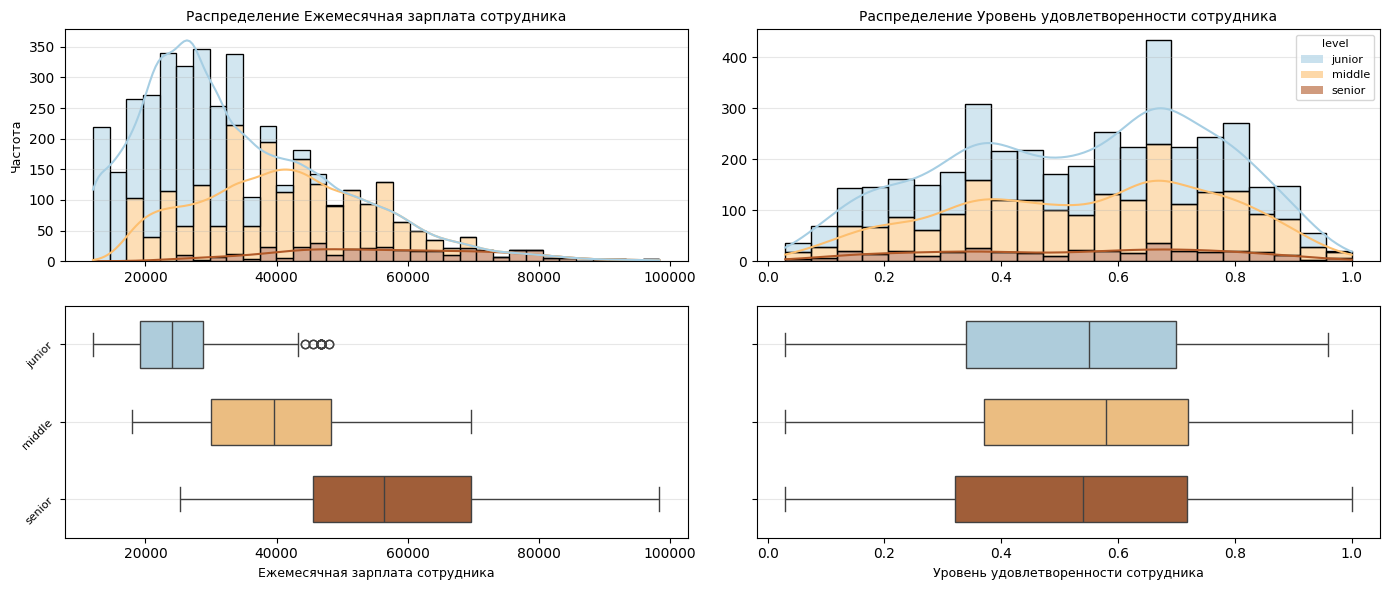

In [24]:
# Применение функции plot_distribution_with_boxplot к количественным непрерывным признакам
features = [
    ('salary', 'Ежемесячная зарплата сотрудника'),
    ('job_satisfaction_rate', 'Уровень удовлетворенности сотрудника')
]

plot_distribution_with_boxplot(
    train_jsrate_df,
    features,
    'level'
)

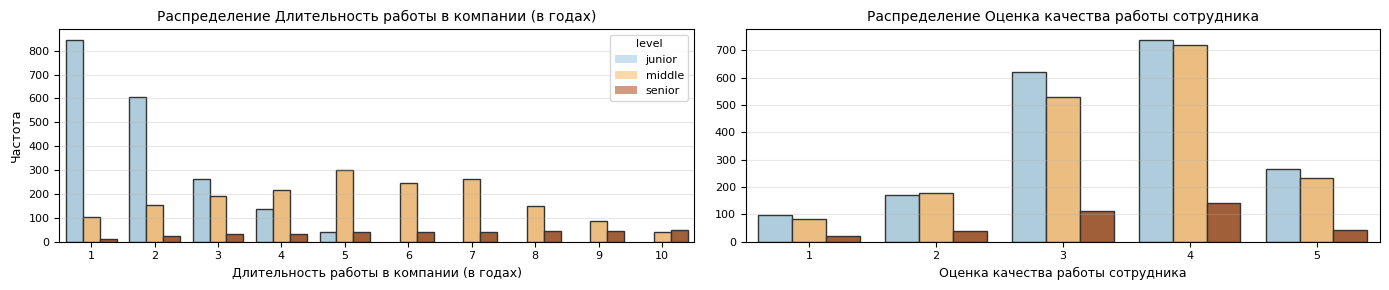

In [25]:
# Применение функции plot_distribution_with_countplot к количественным дискретным признакам
features = [
    ('employment_years', 'Длительность работы в компании (в годах)'),
    ('supervisor_evaluation', 'Оценка качества работы сотрудника')
]

plot_distribution_with_countplot(
    df=train_jsrate_df,
    features=features,
    target_col='level'
)

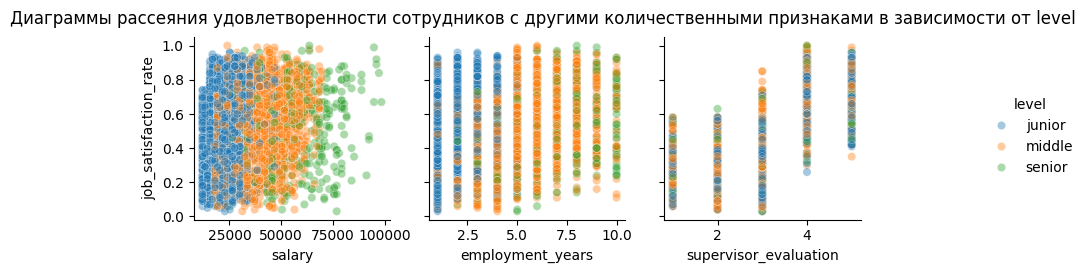

In [26]:
# используем PairGrid для визуализации диаграмм рассеяния
x_vars = ["salary", "employment_years", "supervisor_evaluation"]
y_vars = ["job_satisfaction_rate"]
g = sns.PairGrid(train_jsrate_df, hue="level", x_vars=x_vars, y_vars=y_vars)
#g.map_diag(sns.histplot, color=".3")
g.map_offdiag(sns.scatterplot, alpha=0.4)
g.add_legend()
g.fig.suptitle('Диаграммы рассеяния удовлетворенности сотрудников с другими количественными признаками в зависимости от level', y=1.05)
plt.show()

**Выводы по распределениям в зависимости от Level**

1. Зарплата увеличивается по мере роста уровня занимаемой должности. При этом растет и вилка зарплаты. Выбросы по зарплате есть лишь у `junior`-специалиста.
2. Распределение уровня удовлетворенности работой достаточно равномерное в основной части со спадающими "хвостами" и с максимумом в диапазоне 0.6-0.7 независимо от уровня занимаемой должности. 
3. Распределение длительности работы в компании у `junior`-специалистов спадает на всем промежутке. У специалистов `middle` распределение куполообразное и имеет максимум на уровне 5 лет. У `senior`-специалистов распределение в целом возрастает на всем промежутке.
4. Распределение оценки качества работы сотрудника, которую дал руководитель, для всех уровней должности одного колоколообразного типа с максимумом, смещенным в сторону больших значений и равным 4.
5. Согласно диаграмме рассеяния уровень удовлетворенности сотрудника заметно возрастает по мере увеличения оценки качества работы сотрудника, которую дал руководитель, для всех уровней должности. Кроме этого видна едва заметное увеличение уровня удовлетворенности сотрудника по мере увеличения длительности работы в компании опять же для всех уровней должности. При этом уровень удовлетворенности сотрудника для разной зарплаты может варьироваться во всем диапазоне, что на первый взгляд указывает на отсутствие зависимости, но с увеличением зарплаты оценка удовлетворенности преимущественно высокая.

### Количественные признаки в зависимости от категориального признака dept 

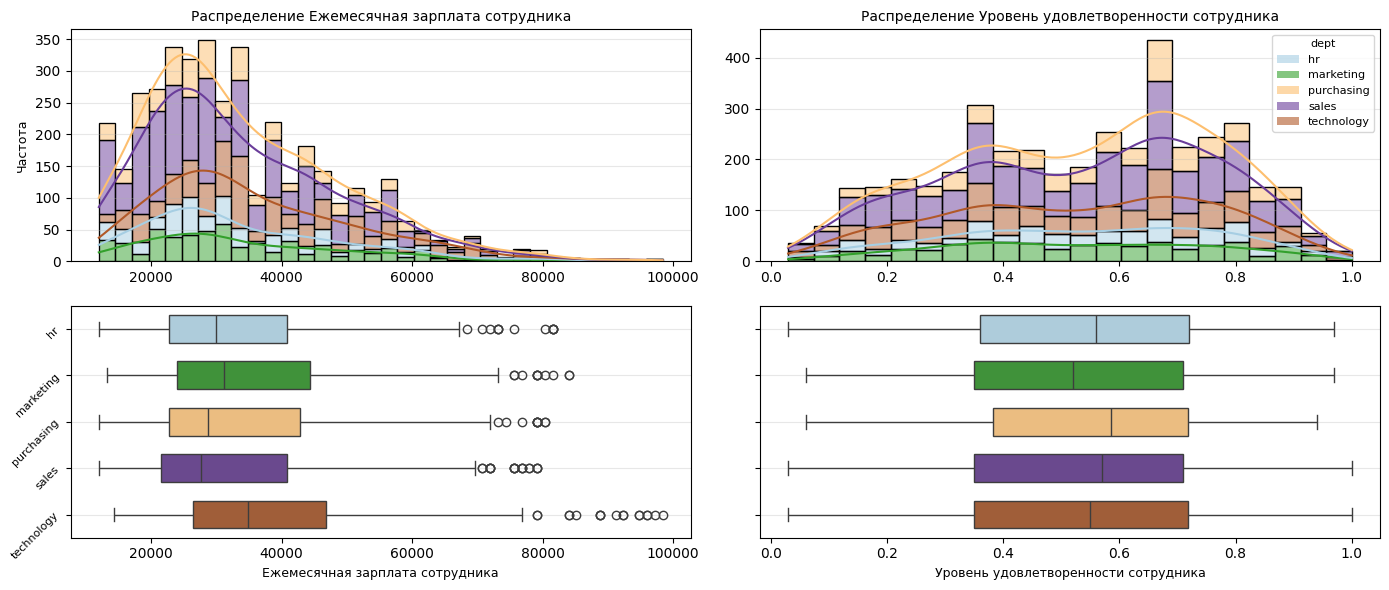

In [27]:
# Применение функции plot_distribution_with_boxplot к количественным непрерывным признакам
features = [
    ('salary', 'Ежемесячная зарплата сотрудника'),
    ('job_satisfaction_rate', 'Уровень удовлетворенности сотрудника')
]

plot_distribution_with_boxplot(
    train_jsrate_df,
    features,
    'dept'
)

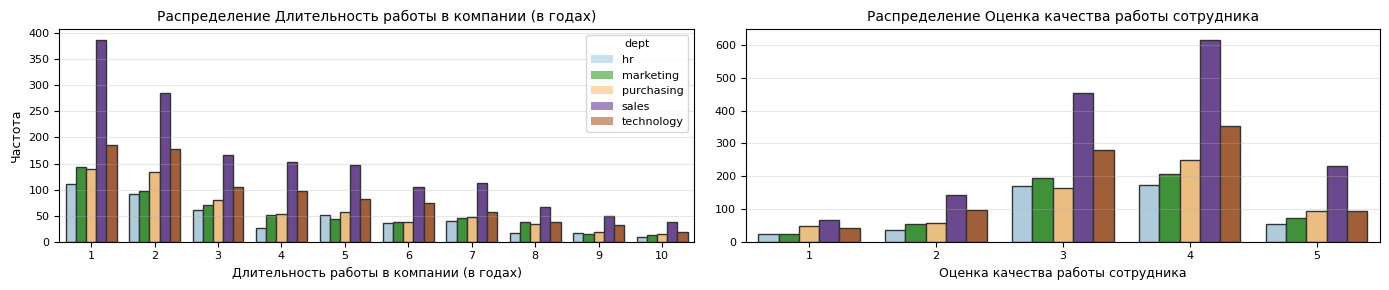

In [28]:
# Применение функции plot_distribution_with_countplot к количественным дискретным признакам
features = [
    ('employment_years', 'Длительность работы в компании (в годах)'),
    ('supervisor_evaluation', 'Оценка качества работы сотрудника')
]

plot_distribution_with_countplot(
    df=train_jsrate_df,
    features=features,
    target_col='dept'
)

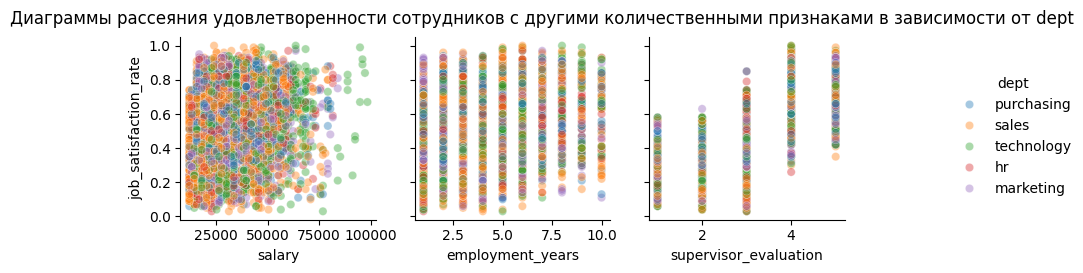

In [29]:
# используем PairGrid для визуализации диаграмм рассеяния
x_vars = ["salary", "employment_years", "supervisor_evaluation"]
y_vars = ["job_satisfaction_rate"]
g = sns.PairGrid(train_jsrate_df, hue="dept", x_vars=x_vars, y_vars=y_vars)
#g.map_diag(sns.histplot, color=".3")
g.map_offdiag(sns.scatterplot, alpha=0.4)
g.add_legend()
g.fig.suptitle('Диаграммы рассеяния удовлетворенности сотрудников с другими количественными признаками в зависимости от dept', y=1.05)
plt.show()

**Выводы по распределениям в зависимости от dept**

1. Медианное значение зарплаты сотрудника и вилка по зарплате больше у отдела `technology`. У остальных отделов оба параметра зарплаты близки друг к другу.
2. Распределение уровня удовлетворенности работой достаточно равномерное в основной части со спадающими "хвостами" и с максимумом в диапазоне 0.6-0.7 для большинства отделов.  
3. Распределение длительности работы в компании в целом спадает для всех отделов на всем промежутке.
4. Распределение оценки качества работы сотрудника, которую дал руководитель, для всех отделов одного колоколообразного типа с максимумом, смещенным в сторону больших значений и равным 4.
5. Согласно диаграмме рассеяния уровень удовлетворенности сотрудника заметно возрастает по мере увеличения оценки качества работы сотрудника, которую дал руководитель, для всех отделов. Однако увеличение уровня удовлетворенности сотрудника по мере увеличения длительности работы едва проявляется на диаграмме рассеяния. При этом уровень удовлетворенности сотрудника для разной зарплаты может варьироваться во всем диапазоне, что на первый взгляд указывает на отсутствие зависимости, но с увеличением зарплаты оценка удовлетворенности преимущественно высокая.

### Количественные признаки в зависимости от категориального признака workload 

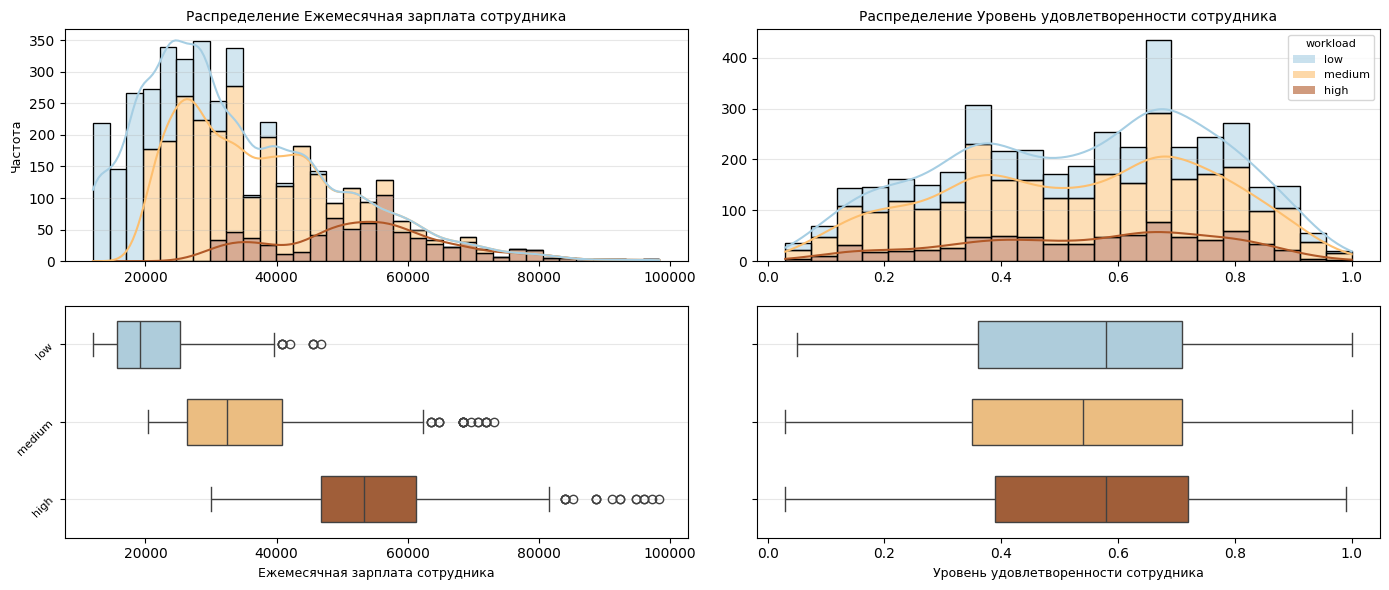

In [30]:
# Применение функции plot_distribution_with_boxplot к количественным непрерывным признакам
features = [
    ('salary', 'Ежемесячная зарплата сотрудника'),
    ('job_satisfaction_rate', 'Уровень удовлетворенности сотрудника')
]

plot_distribution_with_boxplot(
    train_jsrate_df,
    features,
    'workload',
    category_order=['low', 'medium', 'high']
)

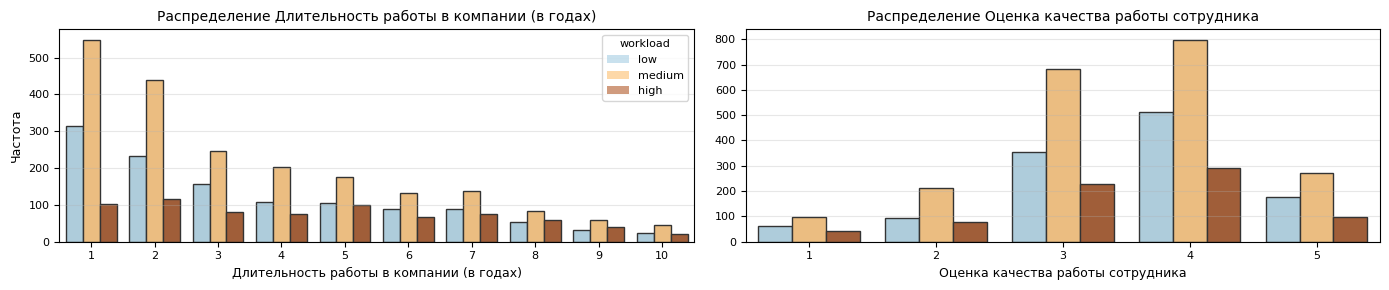

In [31]:
# Применение функции plot_distribution_with_countplot к количественным дискретным признакам
features = [
    ('employment_years', 'Длительность работы в компании (в годах)'),
    ('supervisor_evaluation', 'Оценка качества работы сотрудника')
]

plot_distribution_with_countplot(
    train_jsrate_df,
    features,
    'workload',
    category_order=['low', 'medium', 'high']
)

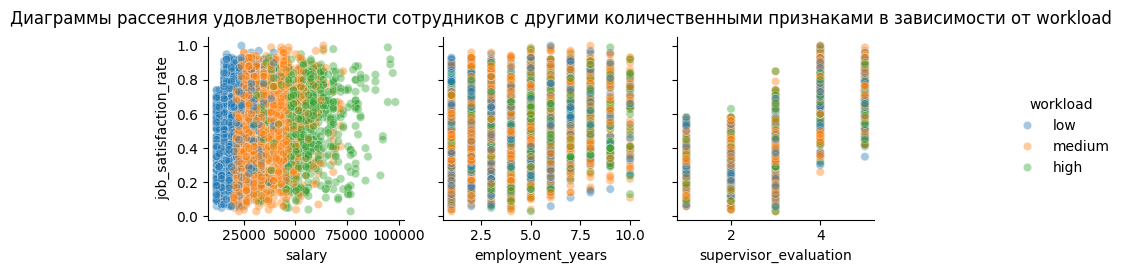

In [32]:
# используем PairGrid для визуализации диаграмм рассеяния
x_vars = ["salary", "employment_years", "supervisor_evaluation"]
y_vars = ["job_satisfaction_rate"]
g = sns.PairGrid(train_jsrate_df, hue="workload", x_vars=x_vars, y_vars=y_vars)
#g.map_diag(sns.histplot, color=".3")
g.map_offdiag(sns.scatterplot, alpha=0.4)
g.add_legend()
g.fig.suptitle('Диаграммы рассеяния удовлетворенности сотрудников с другими количественными признаками в зависимости от workload', y=1.05)
plt.show()

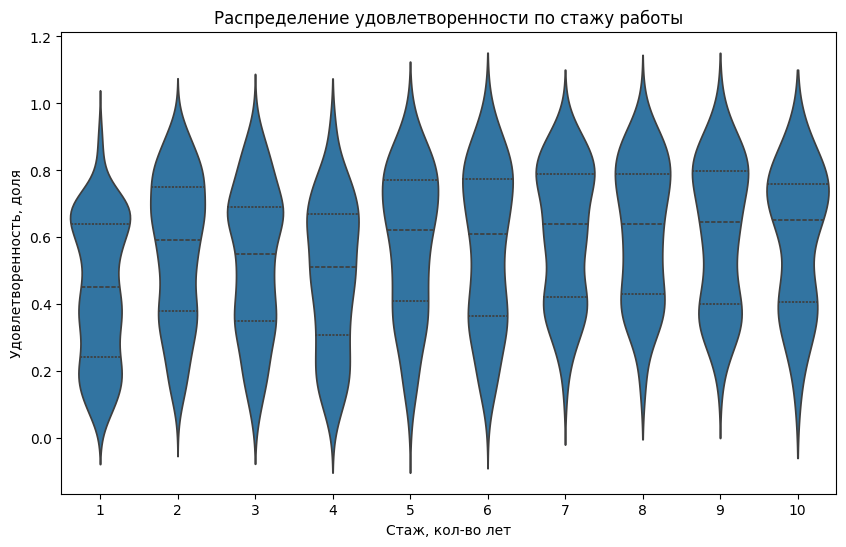

In [33]:
# Создание violinplot
plt.figure(figsize=(10, 6))
sns.violinplot(
    x="employment_years",        # Дискретный признак - стаж (ось X)
    y="job_satisfaction_rate",   # Непрерывный признак - удовлетворенность (ось Y)
    data=train_jsrate_df,          # Датасет
    inner="quartile"    # Визуализация квартилей внутри "скрипки"
)

# Настройка подписей и заголовка
plt.title("Распределение удовлетворенности по стажу работы")
plt.xlabel("Стаж, кол-во лет")
plt.ylabel("Удовлетворенность, доля")

# Отображение графика
plt.show()

**Выводы по распределениям в зависимости от workload**

1. Медианное значение зарплаты сотрудника и вилка по зарплате возрастает с увеличением загруженности сотрудника.
2. Распределение уровня удовлетворенности работой достаточно равномерное в основной части со спадающими "хвостами" и с максимумом в диапазоне 0.6-0.7 независимо от уровня загруженности.
3. Распределение длительности работы в компании в общем спадает на всем промежутке только для двух уровней загруженности: `low`, `medium`. Однако для уровня загруженности `high` распределение длительности работы преимущественно равномерно до 7 лет с последующим уменьшением.
4. Распределение оценки качества работы сотрудника, которую дал руководитель, для всех уровней загруженности одного колоколообразного типа с максимумом, смещенным в сторону больших значений и равным 4.
5. Согласно диаграмме рассеяния уровень удовлетворенности сотрудника заметно возрастает по мере увеличения оценки качества работы сотрудника, которую дал руководитель, для всех уровней загруженности. Однако увеличение уровня удовлетворенности сотрудника по мере увеличения длительности работы едва проявляется на диаграмме рассеяния. При этом уровень удовлетворенности сотрудника для разной зарплаты может варьироваться во всем диапазоне, что на первый взгляд указывает на отсутствие зависимости, но с увеличением зарплаты оценка удовлетворенности преимущественно высокая.

### Количественные признаки в зависимости от категориального признака last_year_promo 

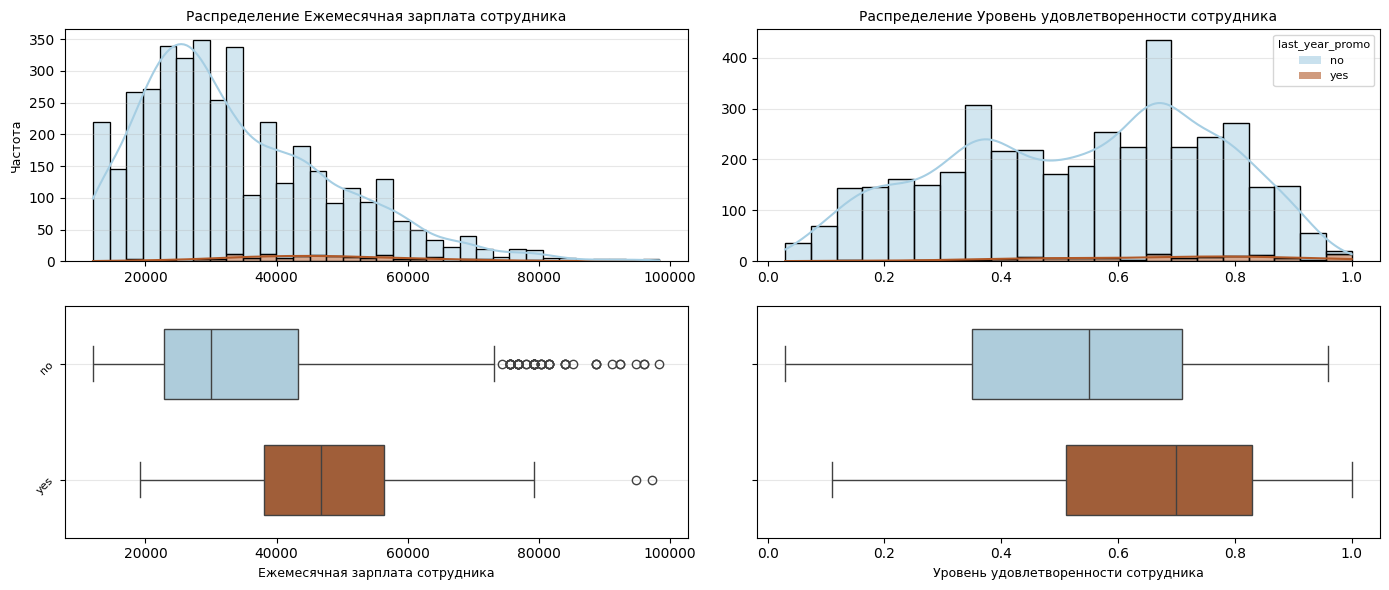

In [34]:
# Применение функции plot_distribution_with_boxplot к количественным непрерывным признакам
features = [
    ('salary', 'Ежемесячная зарплата сотрудника'),
    ('job_satisfaction_rate', 'Уровень удовлетворенности сотрудника')
]

plot_distribution_with_boxplot(
    train_jsrate_df,
    features,
    'last_year_promo'
)

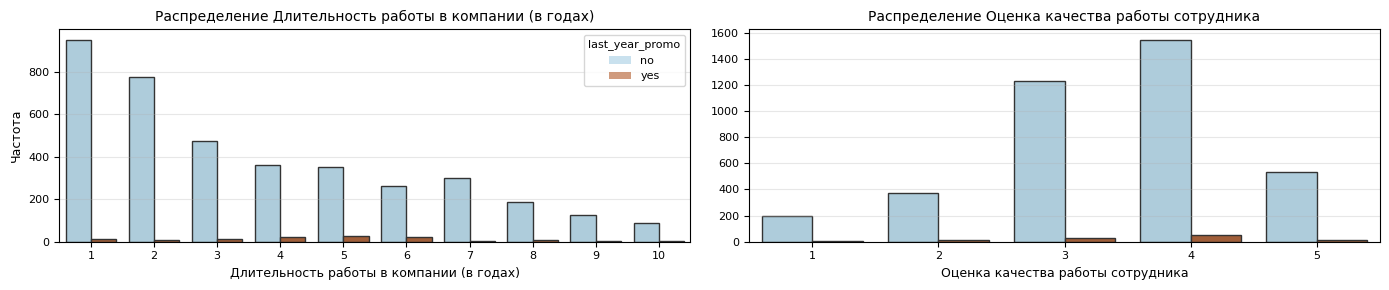

In [35]:
# Применение функции plot_distribution_with_countplot к количественным дискретным признакам
features = [
    ('employment_years', 'Длительность работы в компании (в годах)'),
    ('supervisor_evaluation', 'Оценка качества работы сотрудника'),
]

plot_distribution_with_countplot(
    df=train_jsrate_df,
    features=features,
    target_col='last_year_promo'
)

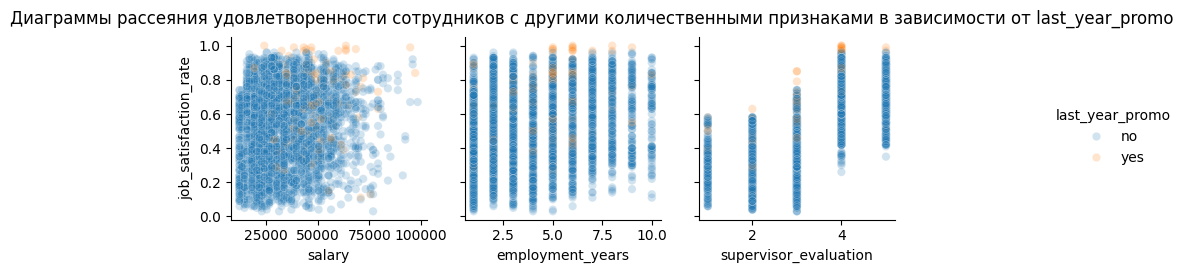

In [36]:
# используем PairGrid для визуализации диаграмм рассеяния
x_vars = ["salary", "employment_years", "supervisor_evaluation"]
y_vars = ["job_satisfaction_rate"]
g = sns.PairGrid(train_jsrate_df, hue="last_year_promo", x_vars=x_vars, y_vars=y_vars)
#g.map_diag(sns.histplot, color=".3")
g.map_offdiag(sns.scatterplot, alpha=0.2)
g.add_legend()
g.fig.suptitle('Диаграммы рассеяния удовлетворенности сотрудников с другими количественными признаками в зависимости от last_year_promo', y=1.05)
plt.show()

**Выводы по распределениям в зависимости от last_year_promo**

1. Медианное значение зарплаты сотрудника, у которого было повышение уровня должности, больше, что, вероятно, связано непосредственно с повышением зарплаты.
2. Распределение уровня удовлетворенности работой достаточно равномерное в основной части со спадающими "хвостами". Однако для сотрудников с повышением в течение года медианное значения уровня удовлетворенности выше.
3. Распределение длительности работы в общем спадает на всем промежутке только для сотрудников, у которых не было повышения за последний год. Однако для сотрудников, которые имели повышение за последний год, распределение длительности работы максимально в диапазоне 4-6 лет.
4. Распределение для всех сотрудников оценки качества работы, которую дал руководитель, одного колоколообразного типа с максимумом, смещенным в сторону больших значений и равным 4.
5. Согласно диаграмме рассеяния уровень удовлетворенности сотрудника заметно возрастает по мере увеличения оценки качества работы сотрудника, которую дал руководитель, для всех категорий: с повышением и без него за последний год. Однако увеличение уровня удовлетворенности сотрудника по мере увеличения длительности работы в компании едва проявляется на диаграмме рассеяния. При этом уровень удовлетворенности сотрудника для разной зарплаты может варьироваться во всем диапазоне, что на первый взгляд указывает на отсутствие зависимости, но с увеличением зарплаты оценка удовлетворенности преимущественно высокая.

### Количественные признаки в зависимости от категориального признака last_year_violations 

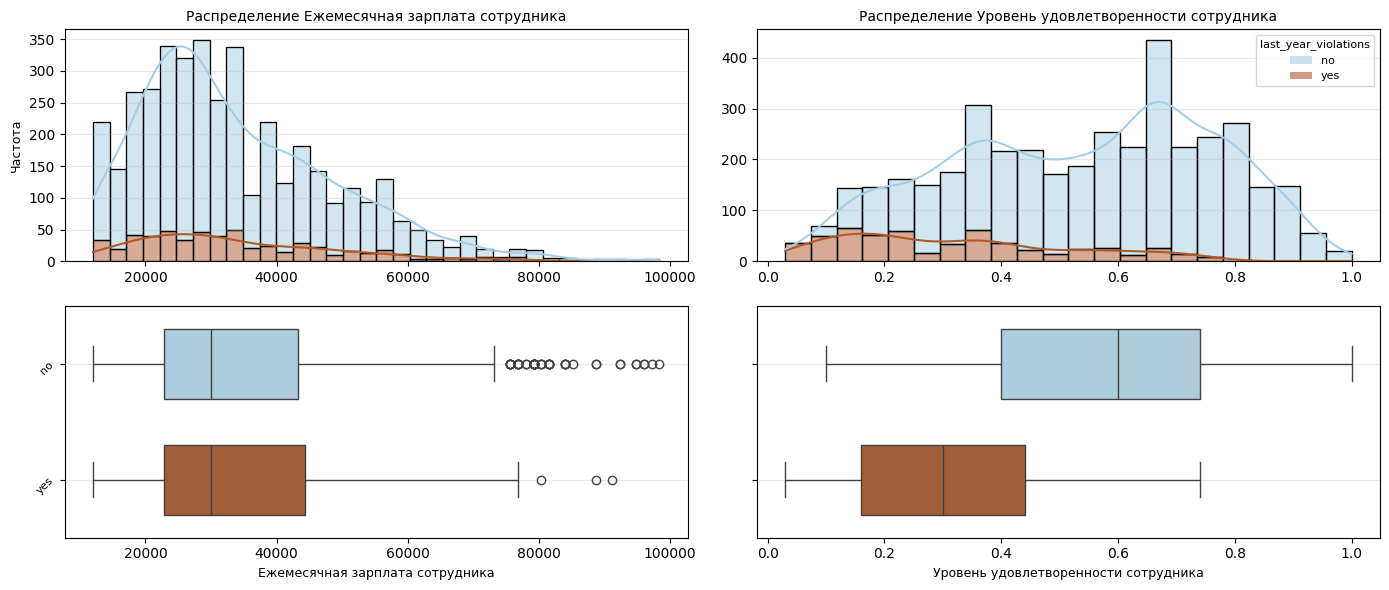

In [37]:
# Применение функции plot_distribution_with_boxplot к количественным непрерывным признакам
features = [
    ('salary', 'Ежемесячная зарплата сотрудника'),
    ('job_satisfaction_rate', 'Уровень удовлетворенности сотрудника')
]

plot_distribution_with_boxplot(
    train_jsrate_df,
    features,
    'last_year_violations'
)

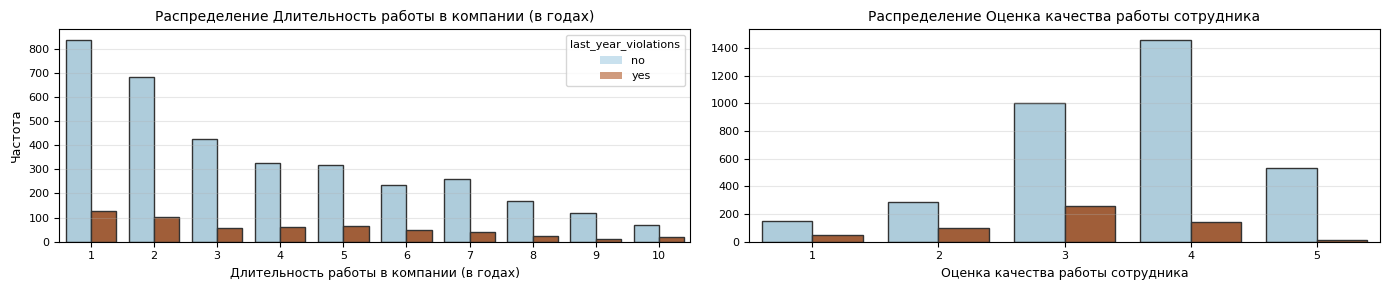

In [38]:
# Применение функции plot_distribution_with_countplot к количественным дискретным признакам
features = [
    ('employment_years', 'Длительность работы в компании (в годах)'),
    ('supervisor_evaluation', 'Оценка качества работы сотрудника'),
]

plot_distribution_with_countplot(
    df=train_jsrate_df,
    features=features,
    target_col='last_year_violations'
)

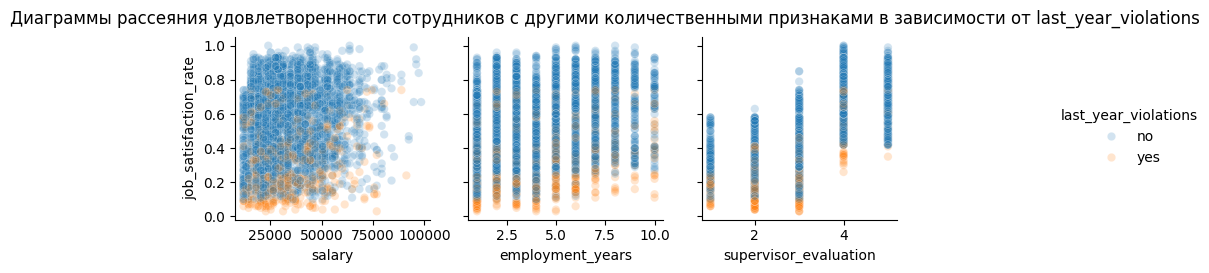

In [39]:
# используем PairGrid для визуализации диаграмм рассеяния
x_vars = ["salary", "employment_years", "supervisor_evaluation"]
y_vars = ["job_satisfaction_rate"]
g = sns.PairGrid(train_jsrate_df, hue="last_year_violations", x_vars=x_vars, y_vars=y_vars)
#g.map_diag(sns.histplot, color=".3")
g.map_offdiag(sns.scatterplot, alpha=0.2)
g.add_legend()
g.fig.suptitle('Диаграммы рассеяния удовлетворенности сотрудников с другими количественными признаками в зависимости от last_year_violations', y=1.05)
plt.show()

**Выводы по распределениям в зависимости от last_year_violations**

1. Медианное значение зарплаты сотрудника не зависит от нарушения трудового договора за последний год.
2. Медианное значение уровня удовлетворенности сильно падает при наличии нарушения трудового договора за последний год с 0.6 до 0.3.
3. Распределение длительности работы в компании в общем спадает на всем промежутке для всех сотрудников, независимо нарушал ли он трудовой договор за последний год или нет.
4. Распределение оценки качества работы, которую дал руководитель, колоколообразного типа с максимумами равными 4 и 3 для сотрудников без нарушений и с нарушениями трудового договора за последний год соответственно.
5. Согласно диаграмме рассеяния уровень удовлетворенности сотрудника заметно возрастает по мере увеличения оценки качества работы сотрудника, которую дал руководитель, для всех категорий: с нарушенями и без них за последний год. Однако увеличение уровня удовлетворенности сотрудника по мере увеличения длительности работы едва проявляется на диаграмме рассеяния. При этом уровень удовлетворенности сотрудника для разной зарплаты может варьироваться во всем диапазоне, что на первый взгляд указывает на отсутствие зависимости, но с увеличением зарплаты оценка удовлетворенности преимущественно выше.

### Выводы по распределениям числовых признаков в зависимости от категориальных

*Анализ данных показал следующие ключевые зависимости:*
1. **Зарплата**:  
   - Растет с уровнем должности, более высокая в отделе **technology**.  
   - Выше у сотрудников с повышением за год и высокой загруженностью (high workload).  

2. **Удовлетворенность работой**:  
   - **Основной фактор**: прямая зависимость от оценки руководителя (пик удовлетворенности при оценке 4+).  
   - **Дополнительные влияния**:  
     - Повышение уровня должности за год → повышает удовлетворенность (медиана увеличивается до 0.7 против 0.55 без повышения).  
     - Нарушения трудового договора → резкое падение удовлетворенности (медиана опускается до 0.3 с 0.6).  
     - Высокая зарплата → чаще ассоциируется с высокими оценками.  

3. **Оценка руководителя**:  
   - Распределение с пиком в 4 балла, но снижается до 3 у сотрудников с нарушениями.  

4. **Стаж**:  
   - У junior — кол-во специалистов сокращается с ростом стажа.
   - У middle — кол-во специалистов максимально со стажем 5 лет
   - У senior — кол-во специалистов растет с увеличением стажа до 10 лет.  

---

*Причины снижения удовлетворенности:*
1. **Низкая оценка руководителя** (особенно у нарушителей).  
2. **Нарушения трудового договора** → стресс, конфликты, наказание.  
3. **Низкий уровень зарплаты/должности** → недовольство junior-сотрудников.  
4. **Высокая загруженность без мотивации** → несбалансированность нагрузки/вознаграждения.  
5. **Отсутствие карьерного роста** → застой у сотрудников без повышений.  

---

Ключевой драйвер — связь между оценкой руководителя и удовлетворенностью. Необходимо усилить фидбэк и карьерные возможности.

### Исследование категориальных признаков

Построим Sunburst-диаграммы для того, чтобы проанализировать различные срезы категориальных признаков.

##### Общая Sunburst-диаграмма

In [40]:
# общая Sunburst-диаграмма для наглядной демонстрации иерархической связи
create_sunburst_plot(test_features_df)

Для проверки гипотез и выявления новых инсайтов можно использовать срезы категориальных признаков в Sunburst-диаграмме, которые будут представлены далее. Это поможет более детально визуализировать иерархические связи и проследить влияние признаков на целевой признак (удовлетворенность).

##### Влияние отдела (dept) и уровня должности (level) на удовлетворенность

In [41]:
# Агрегируем данные: медиана удовлетворенности по dept → level
df_grouped = train_jsrate_df.groupby(['dept', 'level'], as_index=False)[
    'job_satisfaction_rate'
].median()

# Создаем Sunburst-диаграмму
fig = px.sunburst(
    df_grouped,
    path=['dept', 'level'],  # Иерархия категорий
    values='job_satisfaction_rate',  # Значение для визуализации (медиана)
    color='job_satisfaction_rate',  # Цветовая карта
    title='Медианная удовлетворенность работой в зависимости от департамента и уровня',
    color_continuous_scale='RdYlGn',  # Цвета от красного (низкая) к зеленому (высокая)
    width=1000,  # Ширина в пикселях
    height=800  # Высота в пикселях
)
fig.show()

**Выводы по срезу dept->level:**
- отдел purchasing по медианному значению самый удовлетворенный (0.59), причем с равной медианной удовлетворенностью для каждого уровня;
- отдел hr второй по медианному значению удовлетворенности (0.58), причем junior-специалисты данного отдела имеют отличающееся от остальных значение в меньшую сторону — 0.51 против 0.60-0.61;
- отдел marketing самый не удовлетворенный по медианному значению (0.52): 0.55, 0.52, 0.50 для junior, senior, middle соответственно;
- отдел sales (медианное значение удовлетворенности 0.55) имеет самую контрастную удовлетворенность по уровням: самая низкая у senior (0.46), а самая высокая у middle (0.61);
- отдел technology имеет среднюю удовлетворенность для всех уровней в районе 0.55.

Получается, что в отделе technology на высоких уровнях (senior) специалисты не являются более удовлетворенными, а наоборот на всех уровнях данного отдела удовлетворенность одинаковая. Кроме того примечательным является то, что низкая удовлетворенность junior-специалистов у отдела hr (медианное значение 0.51) по сравнению с другими отделами (медианное значение 0.59 у отдела purchasing и 0.55 у остальных отделов).

##### Зависимость удовлетворенности от повышения (last_year_promo) и нарушений (last_year_violations)

In [42]:
# Агрегируем данные: медиана удовлетворенности и количество записей в каждой группе
df_grouped = train_jsrate_df.groupby(
    ['last_year_promo', 'last_year_violations'], 
    as_index=False
).agg(
    job_satisfaction_median=('job_satisfaction_rate', 'median'),
    count=('job_satisfaction_rate', 'count')  # Добавляем подсчет количества записей
)

# Создаем новые столбцы с объединенными названиями признаков и значений
df_grouped['last_year_promo_full'] = (
    'Повышение за последний год: ' + df_grouped['last_year_promo'].astype(str)
)
df_grouped['last_year_violations_full'] = (
    'Нарушения за последний год: ' + df_grouped['last_year_violations'].astype(str)
)

# Строим Sunburst-диаграмму
fig = px.sunburst(
    df_grouped,
    path=['last_year_promo_full', 'last_year_violations_full'],
    values='count',  # Теперь values — количество записей (для правильных процентов)
    color='job_satisfaction_median',  # Цвет — медиана удовлетворенности
    color_continuous_scale='RdYlGn',
    title='Удовлетворенность работой в зависимости от повышения и нарушений',
    width=1000,
    height=800
)

# Добавляем проценты относительно родительской категории
fig.update_traces(
    textinfo='label+percent parent',  # label — название категории, percent parent — % от родительской
    insidetextorientation='radial'    # Улучшает расположение текста
)

fig.show()

**Выводы по срезу last_year_promo->last_year_violations:**
- минимальную удовлетворенность демонстрируют сотрудники с нарушениями и без повышения — медианное значение удовлетворенности 0.29;
- обнаружены аномалии: среди 3% сотрудников, которые получили повышение уровня должности за последний год, от всего количества сотрудников совершили нарушение за последний год 11% (это 13 человек из 4000, то есть примерно 0.3% от общего числа сотрудников).

##### Взаимосвязь загруженности (workload) и оценки руководителя (supervisor_evaluation)

In [43]:
# Агрегируем данные: медиана удовлетворенности и количество записей в каждой группе
df_grouped = train_jsrate_df.groupby(
    ['workload', 'supervisor_evaluation'], 
    as_index=False
).agg(
    job_satisfaction_median=('job_satisfaction_rate', 'median'),
    count=('job_satisfaction_rate', 'count')  # Добавляем подсчет количества записей
)

# Создаем новые столбцы с объединенными названиями признаков и значений
df_grouped['workload_full'] = (
    'Рабочая нагрузка: ' + df_grouped['workload'].astype(str)
)
df_grouped['supervisor_evaluation_full'] = (
    'Оценка руководителя: ' + df_grouped['supervisor_evaluation'].astype(str)
)

# Строим Sunburst-диаграмму
fig = px.sunburst(
    df_grouped,
    path=['workload_full', 'supervisor_evaluation_full'],
    values='count',  # Теперь values — количество записей (для правильных процентов)
    color='job_satisfaction_median',  # Цвет — медиана удовлетворенности
    color_continuous_scale='RdYlGn',
    title='Удовлетворенность работой в зависимости от рабочей нагрузки и оценки руководителя',
    width=1000,
    height=800
)

# Добавляем проценты относительно родительской категории
fig.update_traces(
    textinfo='label+percent parent',  # label — название категории, percent parent — % от родительской
    insidetextorientation='radial'    # Улучшает расположение текста
)

fig.show()

**Выводы по срезу workload->supervisor_evaluation:**
- примечательно, что высокая загруженность не выделяется высокой оценкой руководителя, то есть распределение сотрудников по оценкам руководителя, примерно, одинаково для каждого уровня загруженности — этот факт может ослаблять мотивацию сотрудников для увеличения нагрузки;
- также важным является тот факт, что процент максимально загруженных сотрудников с низкой оценкой руководителя (1,2) среди всех сотрудников в своей категории загруженности больше, чем для сотрудников менее загруженных — этот факт может привести к выгоранию и стрессу.
- уровень удовлетворенности примерно одинаковый для всех загруженностей: 0.54, 0.53, 0.55 для низкой, средней и высокой соответственно.

##### Уровень должности (level) и срок работы (employment_years)

In [44]:
# Создаем категорию для employment_years (диапазоны: ≤2, 3–5, 6–10 лет)
bins = [0, 3, 6, 11]  # Границы диапазонов
labels = ['≤2 года', '3–5 лет', '6–10 лет']  # Названия групп
train_jsrate_df['employment_years_range'] = pd.cut(
    train_jsrate_df['employment_years'],
    bins=bins,
    labels=labels,
    right=False  # Закрываем левую границу (включаем правую)
)

# Агрегируем данные: медиана удовлетворенности и количество записей
df_grouped = train_jsrate_df.groupby(
    ['level', 'employment_years_range']
).agg(
    job_satisfaction_median=('job_satisfaction_rate', 'median'),
    count=('job_satisfaction_rate', 'count')  # Количество записей в группе
).reset_index()  # Сброс индекса после группировки

# Удаляем группы с нулевым количеством записей
df_grouped = df_grouped[df_grouped['count'] > 0]

# Создаем новые столбцы с полными названиями категорий
df_grouped['level_full'] = (
    'Уровень: ' + df_grouped['level'].astype(str)
)
df_grouped['employment_years_range_full'] = (
    'Стаж: ' + df_grouped['employment_years_range'].astype(str)
)

# Строим Sunburst-диаграмму
fig = px.sunburst(
    df_grouped,
    path=['level_full', 'employment_years_range_full'],
    values='count',  # Количество записей для процентов
    color='job_satisfaction_median',  # Цвет — медиана удовлетворенности
    color_continuous_scale='RdYlGn',
    title='Удовлетворенность работой в зависимости от уровня и стажа',
    width=1000,
    height=800
)

# Настройка текста с процентами
fig.update_traces(
    textinfo='label+percent parent',
    insidetextorientation='radial'
)

fig.show()

**Выводы по срезу level->employment_years:**
- наиболее удовлетворенными по медианному значению являются сотрудники уровня middle (0.58), а менее удволетворенные — senior (0.54);
- сотрудники с максимальным опытом работы в своей категории уровня должности являются самыми удовлетворенными;
- при этом самый удоволетворенный класс — уровень middle со стажем 6-10 лет (0.64).
- наличие сотрудников в категориях стажа ≤2 для уровней должности middle и senior указывает на карьерный прыжок.

##### Отдел (dept) и наличие нарушений (last_year_violations)

In [45]:
# Агрегируем данные: медиана удовлетворенности и количество записей в каждой группе
df_grouped = train_jsrate_df.groupby(
    ['dept', 'last_year_violations']
).agg(
    job_satisfaction_median=('job_satisfaction_rate', 'median'),
    count=('job_satisfaction_rate', 'count')  # Количество записей в группе
).reset_index()  # Сброс индекса после группировки

# Удаляем группы с нулевым количеством записей
df_grouped = df_grouped[df_grouped['count'] > 0]

# Создаем новые столбцы с полными названиями категорий
df_grouped['dept_full'] = (
    'Отдел: ' + df_grouped['dept'].astype(str)
)
df_grouped['last_year_violations_full'] = (
    'Нарушения за последний год: ' + 
    df_grouped['last_year_violations'].astype(str)
)

# Строим Sunburst-диаграмму
fig = px.sunburst(
    df_grouped,
    path=['dept_full', 'last_year_violations_full'],
    values='count',  # Количество записей для расчета процентов
    color='job_satisfaction_median',  # Цвет — медиана удовлетворенности
    color_continuous_scale='RdYlGn',
    title='Удовлетворенность работой в зависимости от отдела и нарушений',
    width=1000,
    height=800
)

# Настройка текста с процентами
fig.update_traces(
    textinfo='label+percent parent',  # Название категории и процент от родительской
    insidetextorientation='radial'    # Улучшает расположение текста
)

fig.show()

**Выводы по срезу dept->last_year_violations:**
- доля сотрудников с нарушениями в самом высокооплачиваемом отделе tecnology хоть минимальна (0.13) среди остальных отделов, но не сильно (0.13-0.16 в остальных отделах);
- и самое важное здесь — наглядно подтверждается предположение о том, что сотрудники с нарушениями имеют минимальную удволетворенность.

##### Оценка руководителя (supervisor_evaluation) и уровень загруженности (workload)

In [46]:
# Агрегируем данные: медиана удовлетворенности и количество записей в каждой группе
df_grouped = train_jsrate_df.groupby(
    ['supervisor_evaluation', 'workload']
).agg(
    job_satisfaction_median=('job_satisfaction_rate', 'median'),
    count=('job_satisfaction_rate', 'count')  # Количество записей в группе
).reset_index()  # Сброс индекса после группировки

# Удаляем группы с нулевым количеством записей
df_grouped = df_grouped[df_grouped['count'] > 0]

# Создаем новые столбцы с полными названиями категорий
df_grouped['supervisor_evaluation_full'] = (
    'Оценка руководителя: ' + df_grouped['supervisor_evaluation'].astype(str)
)
df_grouped['workload_full'] = (
    'Рабочая нагрузка: ' + df_grouped['workload'].astype(str)
)

# Строим Sunburst-диаграмму
fig = px.sunburst(
    df_grouped,
    path=['supervisor_evaluation_full', 'workload_full'],  # Иерархия: оценка → загруженность
    values='count',  # Размер сектора = количество записей (для процентов)
    color='job_satisfaction_median',  # Цвет = медиана удовлетворенности
    title='Удовлетворенность сотрудников: оценка руководителя и загруженность',
    color_continuous_scale='RdYlGn',  # Цвета от красного к зеленому
    width=1000,
    height=800
)

# Настройка текста с процентами
fig.update_traces(
    textinfo='label+percent parent',  # Название категории и процент от родительской
    insidetextorientation='radial'    # Улучшает расположение текста
)

fig.show()

**Выводы по срезу supervisor_evaluation->workload:**
- высокая удовлетворенность связана с высокой оценкой и высокой загрузкой;
- сотрудники с высокой оценкой руководителя (4,5), но низкой загрузкой составляют аж 32% от сотрудников, которые получили данную оценку от руководителя, что указывает на неэффективное распределение задач.

##### Повышение (last_year_promo) и уровень должности (level)

In [47]:
# новый столбец с диапазонами стажа перед группировкой
train_jsrate_df['employment_years_range'] = pd.cut(
    train_jsrate_df['employment_years'],
    bins=[0, 2, 5, 10],
    labels=['≤2', '3–5', '6–10']
)

# Агрегируем данные: медиана удовлетворенности и количество сотрудников
df_grouped = train_jsrate_df.groupby(
    ['last_year_promo', 'level', 'employment_years_range']  # Используем новый столбец
).agg(
    job_satisfaction_median=('job_satisfaction_rate', 'median'),
    count=('job_satisfaction_rate', 'count')  # Количество сотрудников в группе
).reset_index()  # Сброс индекса после группировки

# Удаляем группы с нулевым количеством сотрудников
df_grouped = df_grouped[df_grouped['count'] > 0]

# Создаем новые столбцы с полными названиями категорий
df_grouped['last_year_promo_full'] = (
    'Повышение за последний год: ' + df_grouped['last_year_promo'].astype(str)
)
df_grouped['level_full'] = (
    'Уровень: ' + df_grouped['level'].astype(str)
)
df_grouped['employment_years_full'] = (
    'Стаж работы: ' + df_grouped['employment_years_range'].astype(str)  # Используем диапазоны
)

# Остальной код визуализации остается без изменений
fig = px.sunburst(
    df_grouped,
    path=['last_year_promo_full', 'level_full', 'employment_years_full'],  # Обновленный путь
    values='count',  # Значения для расчета (не влияют на размеры секторов)
    color='job_satisfaction_median',  # Цвет = медиана удовлетворенности
    title='Распределение сотрудников по повышениям, уровням должности и стажу работы',
    color_continuous_scale='RdYlGn',  # Цвета от красного (низкая) к зеленому (высокая)
    width=1000,
    height=800,
)

# Настройка текста с процентами
fig.update_traces(
    textinfo='label+percent parent',  # Название категории и процент от родительской
    insidetextorientation='radial'    # Улучшает расположение текста
)

fig.show()

**Выводы по срезу last_year_promo->level->employment_years:**
- сотрудники с повышением уровня должности за год значительно более удовлетворены: 0.71 против 0.55;
- повышение уровня должности дают чаще сотрудникам при переходе на уровень senior, чем middle — 8% против 5%;
- повышение уровня должности дают чаще сотрудникам со стажем работы ≥3, чем ≤2.

##### Комбинация всех ключевых факторов

In [48]:
# Создаем иерархию dept → level → workload → last_year_promo
df_grouped = train_jsrate_df.groupby(
    ['dept', 'level', 'workload', 'last_year_promo'], 
    as_index=False
)['job_satisfaction_rate'].median()

fig = px.sunburst(
    df_grouped,
    path=['dept', 'level', 'workload', 'last_year_promo'],
    values='job_satisfaction_rate',
    color='job_satisfaction_rate',
    title='Удовлетворенность в зависимости от отдела, уровня должности, нагрузки и повышения позиции',
    color_continuous_scale='RdYlGn',
    width=1000,
    height=800
)
fig.show()

**Выводы по срезу ключевых факторов:**
- найден сектор с низкой удовлетворенностью (0.35) несмотря на повышение уровня должности за последний год: отдел purchasing, уровень senior, высокая загруженность;
- также достаточно низкая удовлетворенность (0.49) у сотрудников с повышением уровня должности за последний год в отделе hr, уровень senior, средняя загруженность;
- остальные острудники с низкой удовлетворенностью находятся преимущественно в категориях без повышения уровня должности за последний год, что является логичным;
- для высокой удовлетворенности оптимальными факторами являются следующие:
    - отдел sales, уровень senior, низкая загруженность, повышение уровня должности за последний год (медианное значение удовлетворенности 0.97);
    - отдел HR, уровень middle, низкая загруженность, повышение уровня должности за последний год (медианное значение удовлетворенности 0.90);
    - отдел purchasing, уровень senior, средняя загруженность, повышение уровня должности за последний год (медианное значение удовлетворенности 0.90);
    - отдел technology, уровень senior, средняя загруженность, повышение уровня должности за последний год (медианное значение удовлетворенности 0.87);
    - отдел marketing, уровень senior, средняя загруженность, повышение уровня должности за последний год (медианное значение удовлетворенности 0.85).

Очевидным является тот факт, что для высокой удовлетворенности сотруднику нужно повышение уровня должности. Более удовлетворенными повышению уровня должности являются сотрудники с более высоким уровнем должности (senior) и низкой или средней загруженностью. 

### Выводы по исследовательскому анализу

**Ключевые факторы влияния на удовлетворенность:**
1. **Повышение уровня должности**  
   - **+40% удовлетворенности** (медиана 0.71 vs 0.55 без повышения).  
   - Наибольший эффект у **senior** с **низкой загруженностью** (например, 0.97 в sales).  
   - **Аномалия**: 0.3% сотрудников с повышением нарушили правила (13 человек).

2. **Оценка руководителя**  
   - **Прямая зависимость**: пик удовлетворенности при оценке 4+ (медиана 0.7).  
   - Низкие оценки (1–2) → медиана 0.3 (особенно у нарушителей).

3. **Отдел и уровень должности**  
   - **Лучшие**: purchasing (медиана 0.59), HR (0.58).  
   - **Самые низкие**: marketing (0.52), sales senior (0.46).  
   - **Проблема в HR**: junior-сотрудники недовольны (0.51).  

4. **Загруженность и оценка**  
   - Высокая загрузка без высокой оценки → стресс (медиана удовлетворенности 0.53–0.55).  
   - **Аномалия**: 32% сотрудников с оценкой 4–5 имеют низкую загрузку.

---

**Основные причины снижения удовлетворенности:**
1. **Низкая оценка руководителя** (особенно у нарушителей).  
2. **Высокая загруженность без мотивации** (низкая оценка/зарплата).  
3. **Работа в «проблемных» отделах**: marketing, sales senior.  
4. **Нарушения** → медиана удовлетворенности 0.29 (даже в technology с повышенной зарплатой).

---

**Ключевой драйвер**: Связь между **оценкой руководителя** и удовлетворенностью. Нужна прозрачность критериев оценки и быстрый фидбэк.


## Корреляционный анализ

### *Phik-коэффициенты*

Проведем корреляционный анализ признаков в датафрейме `train_jsrate_df` для моделирования. Будем рассчитывать Phik-коэффициенты, так как планируется обучать в числе прочего нелинейные модели. Такой метод является универсальным и подходит для любых типов данных: числовых, категориальных или их сочетания. Поэтому будем рассчитывать Phik-коэффициенты для всех признаков датафрейма.

Используем созданную функцию для построения матрицы корреляции Phik и датафрейма с отсортированными строками по значению коэффициента по убыванию, но превышающему порог, устанавливаемый пользователем. Будем считать, что присутствует мультиколлинеарность, если хотя бы у одной пары признаков коэффициент Phik будет больше или равен 0.9. В качестве порога в функции выберем 0.9, чтобы можно было бы сразу вывести пары признаков с мультиколлинеарностью.

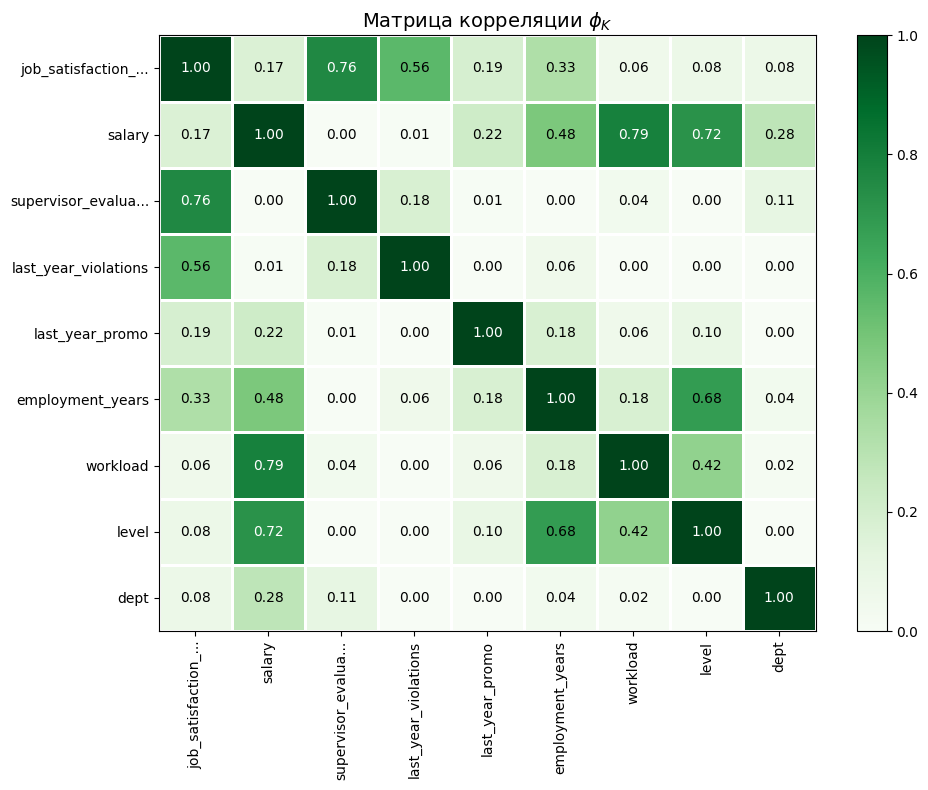

Мультиколлинеарность между парами входных признаков отсутствует


In [49]:
# рассчитаем матрицу корреляции Phik
# присвоем переменной phik_sorted датафрейм с парами признаков и их корреляцией Фи
# присвоем переменной threshold пороговое значение
# присвоем переменной interval_cols список названий всех столбцов с числовым типом данных в обрабатываемом датафрейме
train_jsrate_df = train_jsrate_df.drop('employment_years_range', axis=1)
phik_sorted, interval_cols = phik_correlation_matrix(train_jsrate_df, threshold = 0.9, output_interval_cols=True)

По результатам расчета Phik-коэффициентов мы делаем вывод, что попарная мультиколлинеарность отсутствует. Однако есть входные признаки, которые не имеют корреляции непосредственно с целевым признаком `job_satisfaction_rate`. К таким входным признакам относятся: `workload`, `level` и `dept`. Однако в совокупности с другими входными признаками, они могут улучшить предсказательную способность модели и ее метрики в целом. Поэтому при первом моделировании будем использовать все признаки.

### *Матрица рассеяния*

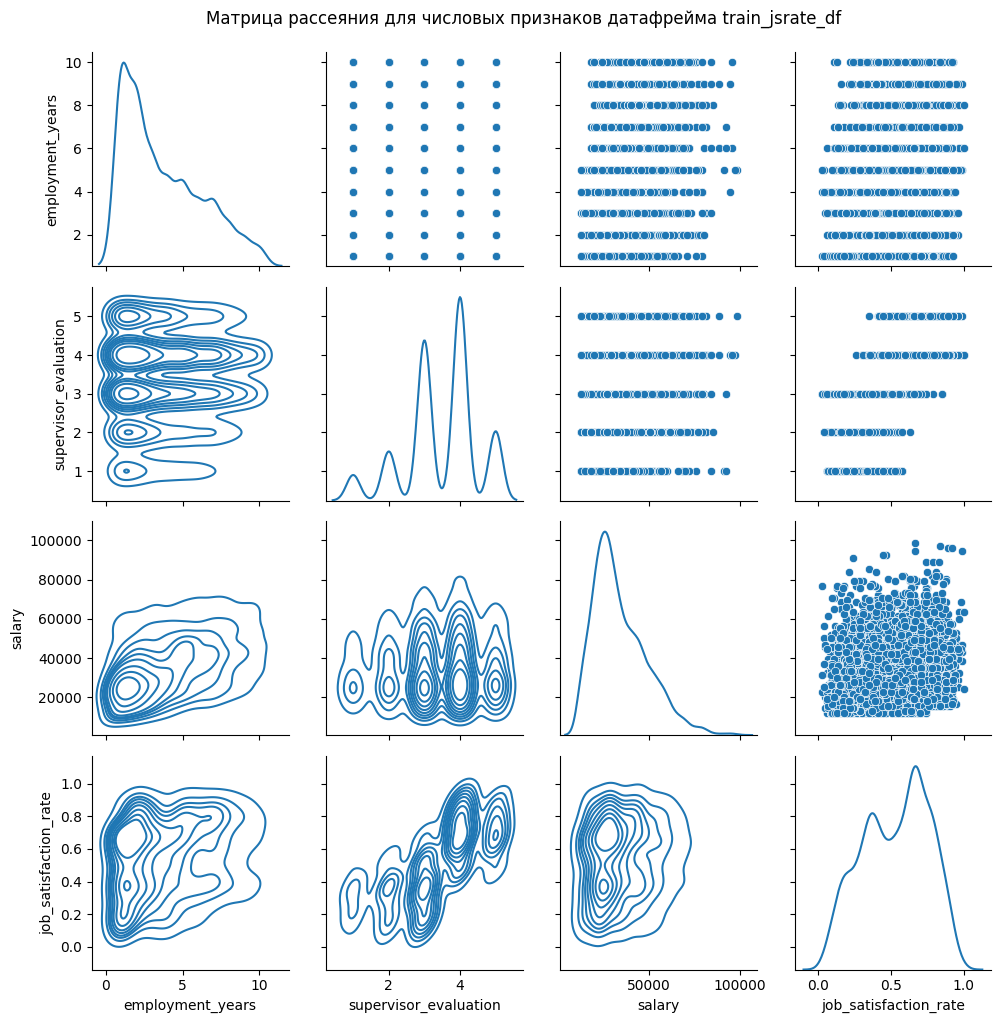

CPU times: total: 25 s
Wall time: 20.1 s


In [50]:
%%time
# строим матрицу рассеяния с помощью PairGrid 
g = sns.PairGrid(train_jsrate_df, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)

# добавляем название диаграммы
g.fig.suptitle('Матрица рассеяния для числовых признаков датафрейма train_jsrate_df', y=1.02)  # увеличиваем значение y, чтобы поднять заголовок)

# показываем диаграмму
plt.show()

На матрице рассеяния наблюдаются пары признаков, которые имеют некоторую степень линейной зависимости: `salary`-`employment_years` и все пары числовых признаков с целевым признаком `job_satisfaction_rate`. Если не разделять данные по категориям, то просматриваются нелинейные зависимости, например, для пар `job_satisfaction_rate`-`employment_years` или `job_satisfaction_rate`-`salary`. Однако их достаточно сложно выявить. Следовательно перед расчетом коэффициентов VIF никаких математических преобразований признаков проводить не будем.

### *Коэффициент инфляции дисперсии*

Коэффициент инфляции дисперсии (variance inflation factor — VIF) измеряет насколько сильно дисперсия коэффициента регрессии увеличивается из-за мультиколлинеарности. Различают следующие категории мультиколлинеарности по значению VIF:
- вблизи 1 — отсутствует или пренебрежимо слабая;
- больше 5–10 — умеренная или сильная (требует внимания);
- больше 100 — критическая (модель ненадежна).

Используем созданную фукнцию `vif_` для расчета коэффициентов инфляции диспресии и рассчитаем их для всех входных признаков датафрейма `market_df`.

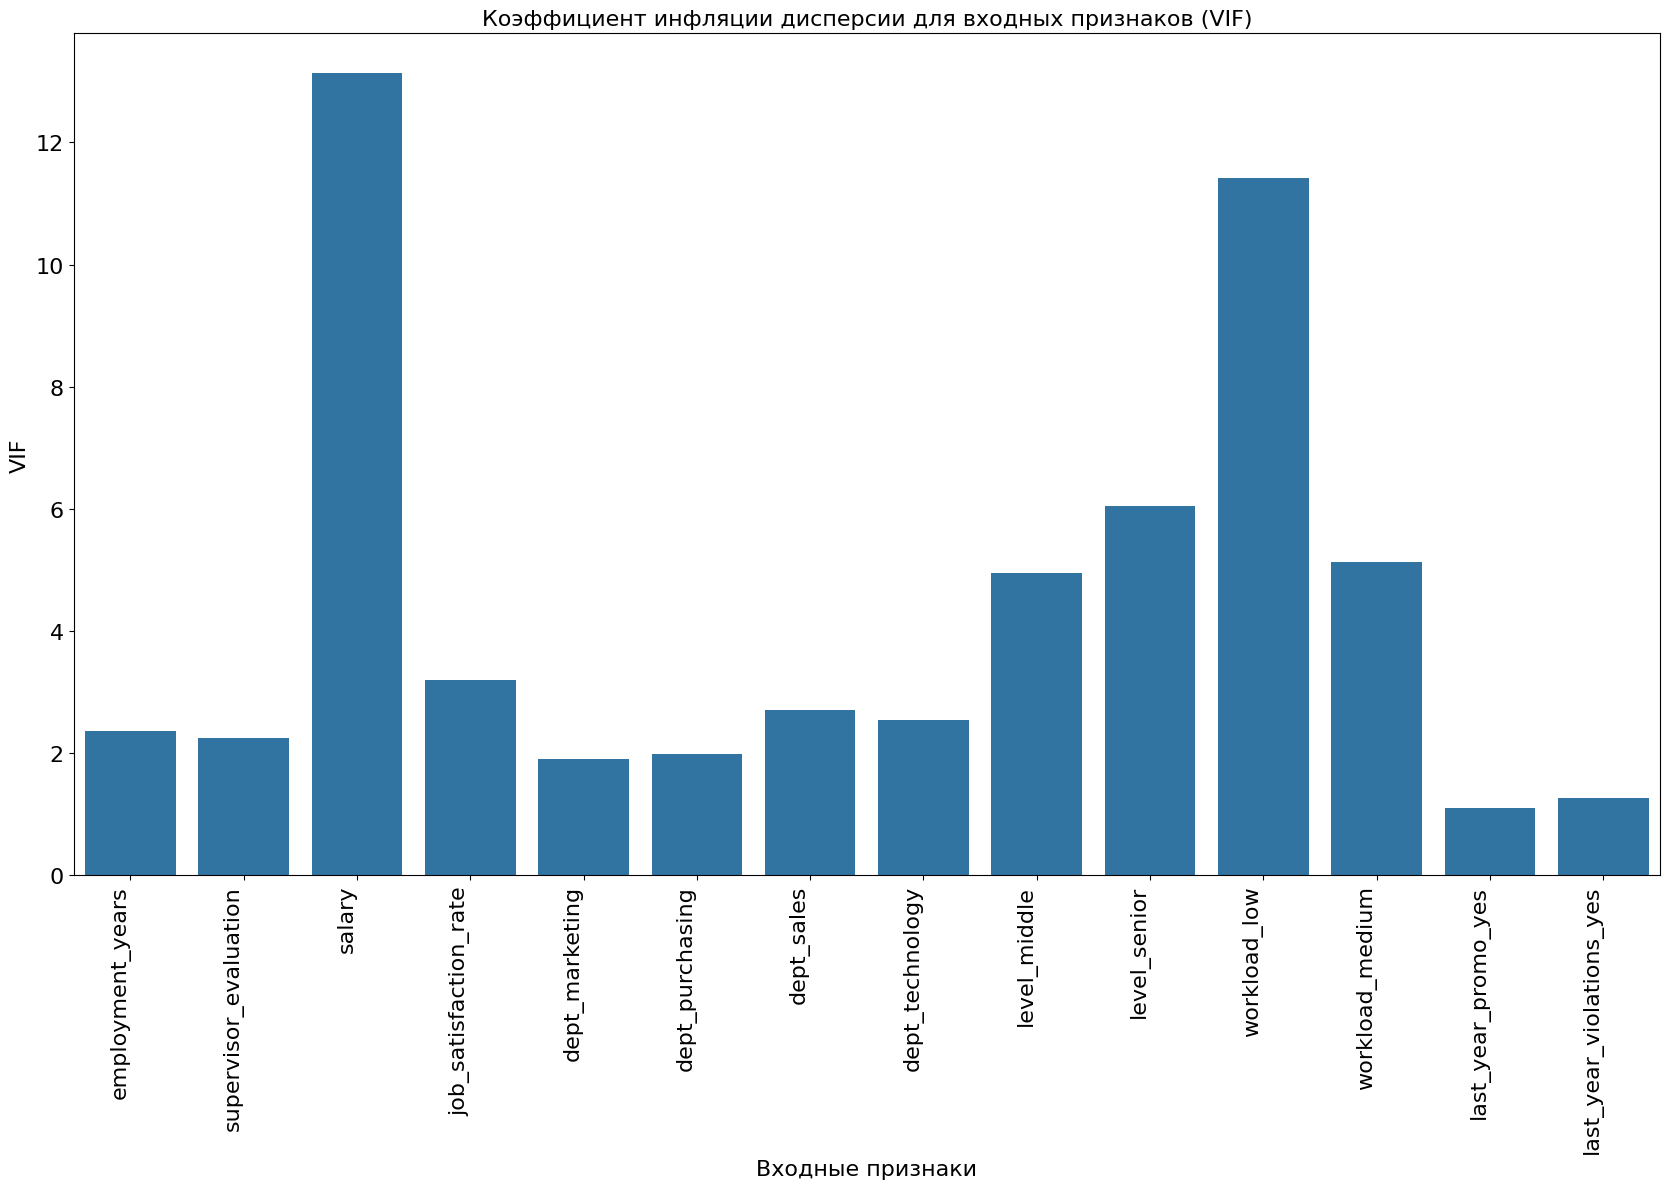

In [51]:
# используем созданную функцию рассчета VIF 
vif_(train_jsrate_df, font_size=16)

**Вывод по расчету коэффициента инфляции дисперсии.**

Мы наблюдаем сильную мултиколлинеарность для признака `salary`, что согласуется с матрицей рассеяния. Также сильная мультиколлинеарность есть и у `workload_low`. То есть данные признаки по отдельности имеют некоторую линейную связь со всеми остальными признаками в совакупности. При моделировании будем иметь в виду о наличие таких зависимостей и при необходимости улучшения метрик сможем с ними поработать. Например, с помощью удаления переменных с мультиколлинеарностью, объединения коррелирующих признаков или использование методов регуляризации (Ridge Regression).

### *Выводы по корреляционному анализу*

1. Отсутствует попарная мультиколлинеарность.
2. Есть входные признаки, которые не имеют корреляции непосредственно с целевым признаком `job_satisfaction_rate`. К таким входным признакам относятся: `workload`, `level` и `dept`.
3. Наличие пары признаков, которые имеют некоторую степень линейной зависимости: `salary`-`employment_years` и все пары числовых признаков с целевым признаком `job_satisfaction_rate`.
4. Имеется сильная мултиколлинеарность для признаков `salary` и `workload_low` по отдельности с совокупностью остальных признаков в виде линейной регрессии.

При моделировании будем иметь в виду о наличие таких зависимостей и при необходимости улучшения метрик сможем с ними поработать. Например, с помощью удаления переменных с мультиколлинеарностью, объединения коррелирующих признаков или использование методов регуляризации (Ridge Regression).

## Выводы по исследовательскому и корреляционному анализам

**Главные факторы удовлетворенности сотрудников**:  
  1. **Оценка руководителя**: Чем выше оценка, тем выше удовлетворенность.
  2. **Повышение за год**: Повышение увеличивает удовлетворенность, но 0.3% таких сотрудников нарушали правила.

---

**Точки соприкосновения исследовательского анализа и корреляционного анализа:**
1. **Оценка руководителя**:  
   - **Прямая зависимость** с удовлетворенностью (высокие оценки → высокая удовлетворенность).  
   - **Phi-k корреляция** подтверждает связь с целевым признаком.  

2. **Зарплата и стаж**:  
   - **Зарплата** коррелирует с удовлетворенностью (Phi-k).  
   - **Стаж** также коррелирует с удовлетворенностью.
   - Но **зарплата и стаж между собой имеют линейную связь** (заметная по шкале Чеддока).  

---

**Разногласия и их объяснения:**
1. **Загруженность (`workload`)**:  
   - **Исследовательский анализ**: Высокая загрузка без высокой оценки → стресс, низкая удовлетворенность.  
   - **Корреляционный анализ (Phi-k)**: Не выявляет сильной связи с целевым признаком.  
   - **Объяснение**:  
     - `workload` — категориальный признак (`low`, `medium`, `high`), но его влияние проявляется **взаимодействием** с другими признаками (например, оценка руководителя).  
     - Phi-k учитывает категориальные связи, но не улавливает **комбинации** (например, «высокая загрузка + низкая оценка»).  

2. **Уровень должности (`level`) и отдел (`dept`)**:  
   - **Исследовательский анализ**: Критически важны (например, «sales senior» с низкой удовлетворенностью).  
   - **Корреляционный анализ (Phi-k)**: Не коррелируют напрямую с целевым признаком.  
   - **Объяснение**:  
     - Эти признаки влияют через **внутрикатегорийные различия** (например, «junior в HR» vs «senior в HR»).  
     - Phi-k не учитывает сложных взаимодействий, требующих анализа групп.  

3. **Аномалии**:  
   - **Исследовательский анализ**: 32% сотрудников с высокой оценкой имеют низкую загрузку.  
   - **Корреляционный анализ**: Не отмечает эту связь.  
   - **Объяснение**: Это может быть следствием **взаимодействия** между оценкой и `workload_low` (например, высокая оценка → меньше нагрузки).  

---

**Рекомендации для моделирования:**

1. Три признака: `dept`, `last_year_promo`, `last_year_violations` — нужно кодировать с помощью OneHotEncoder.
2. Два признака: `level`, `workload` — нужно кодировать с помощью OrdinalEncoder.
3. Один признак `supervisor_evaluation` можно не кодировать, так как он изначально закадирован (1-5).
4. В признаках `dept` и `level`, закодированных этими методами, встречаются пропуски — нужно заполнить их самым часто встречающимся значением с помощью SimpleImputer.
5. Целевой признак — `job_satisfaction_rate`.
6. Количественные признаки `employment_years`, `salary` нужно масштабировать.

## Проверка согласованности тренировочной и тестовой выборок

In [52]:
# создаем копию датафрейма test_features_df, чтобы сам датафрейм test_features_df не изменить
test_jsrate_df = test_features_df.copy()

# добавляем столбец job_satisfaction_rate к копии датафрейма test_features_df для сравнения с train_jsrate_df
test_jsrate_df['job_satisfaction_rate'] = test_target_jsrate_df

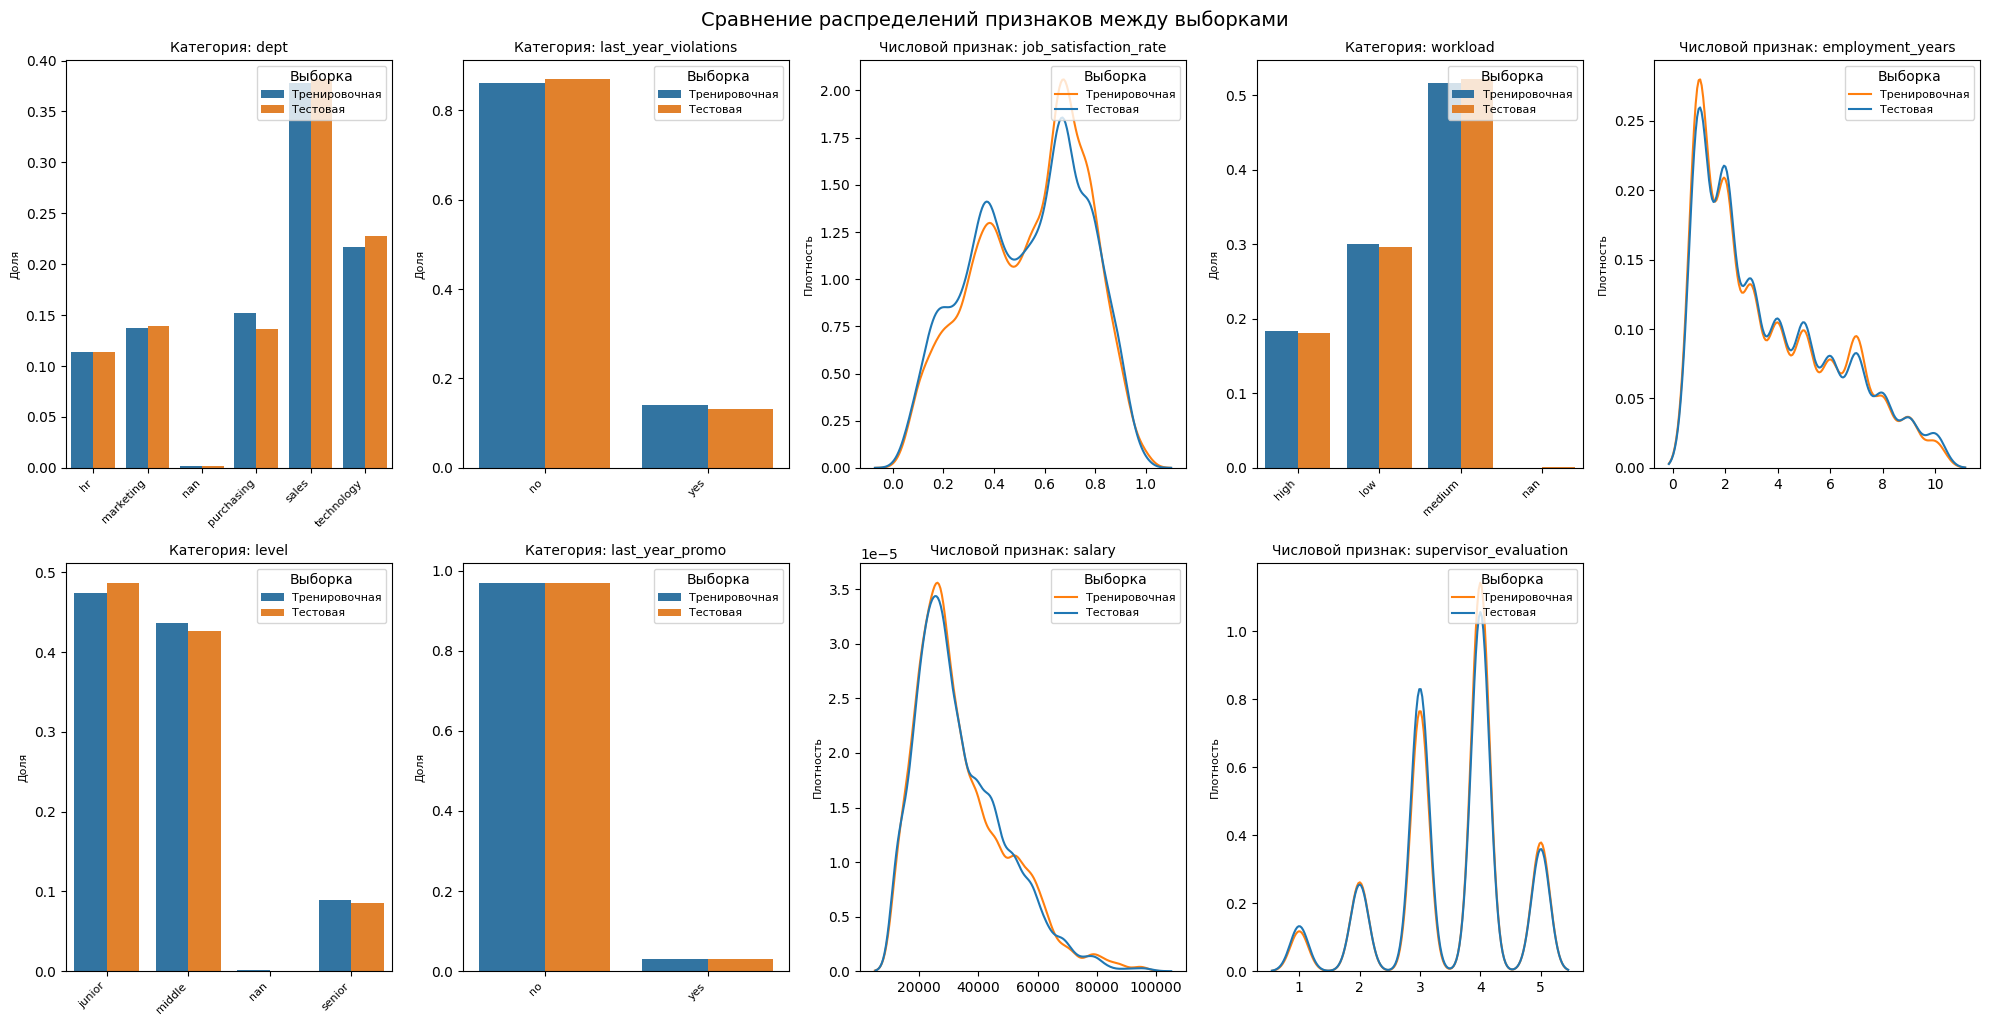

In [53]:
# применяем собственную функцию compare_distributions к датафреймам train_jsrate_df и test_jsrate_df
compare_distributions(train_jsrate_df, test_jsrate_df, n_cols=5)

Мы наблюдаем, что распределения для тренировочной и тестовой выборок достаточно хорошо согласуются друг с другом, что указывает на одинаковые закономерности в обоих выборках. Следовательно обученная на тренировочной выборке модель сможет продемоснтрировать высокую предсказательную способность и на тестовой выборке.

## Подготовка данных

In [54]:
# делим данные на тренировачные и тестовые выборки
X_train = train_jsrate_df.drop(['job_satisfaction_rate'], axis=1)
y_train = train_jsrate_df['job_satisfaction_rate']
X_test = test_features_df
y_test = test_target_jsrate_df

In [55]:
# создаем списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'salary']

In [56]:
# создаем пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_before_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
     ('simpleImputer_after_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
    )

# создаем пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns),
    ], 
    remainder='passthrough'
)

## Обучение моделей

Используем метрику SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение») в качестве scorer. Ранее создана собственная функция smape, которая рассчитывает эту метрику.

In [57]:
# создаём объект пользовательской метрики
scorer = make_scorer(smape, greater_is_better=False)

Сформируем итоговый пайплайн

In [58]:
# создаем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

Проведем кросс-валидацию для установления лучшей модели и ее лучших гипперпараметров

In [59]:
# введем гиперпараметры для каждой модели отдельно
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(7, 15),
        'models__max_features': range(7, 15),
        'preprocessor__num': ['passthrough']  
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

# настроим GridSearchCV для кросс-валидации
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=3,
    scoring=scorer,
   # random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'  # Вызывает исключение при ошибках
)

In [60]:
%%time
# обучаем модель на тренировочных данных с использованием кросс-валидации
grid_search.fit(X_train, y_train)

CPU times: total: 2.03 s
Wall time: 3.48 s


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_before_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('simpleImputer_after_ohe',
                                                                                          SimpleImputer(s...
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(7, 15),
                          'models__max_features': range(7, 15),
                          'preprocessor__num': ['passthrough']},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

Выведем пайплайн лучшей модели

In [61]:
# извлекаем pipline с лучшей моделью
best_model = grid_search.best_estimator_
print('Лучшая модель и ее параметры:\n\n', best_model)

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                              

По результатам кросс-валидации лучшей моделью стала DecisionTreeRegressor с гиперпараметрами max_depth=14, max_features=8. При этом метрика SMAPE лучше, когда scaler для количественных признаков не используется. Этот факт объясняется тем, что DecisionTreeRegressor не зависит от масштаба, так как разбиения выполняются на основе пороговых значений. Это позволяет дереву успешно работать с данными без предварительного масштабирования.

Рассчитаем метрику SMAPE на лучшей модели на кросс-валидацинной выборке и на тестовой выборке

In [62]:
print(f'\033[1mМетрика SMAPE лучшей модели на кросс-валидацинной выборке: {grid_search.best_score_}\n\033[0m')

# рассчитаем прогноз на тестовых данных
try:
    y_test_pred = best_model.predict(X_test)
    print(f'\033[1m\nМетрика SMAPE на тестовой выборке: {scorer(best_model, X_test, y_test)}\033[0m')
except Exception as e:
    print('Произошла ошибка:', e)

Метрика SMAPE лучшей модели на кросс-валидацинной выборке: -15.519353745042197

Тип y_true: <class 'pandas.core.frame.DataFrame'>
Тип y_pred: <class 'numpy.ndarray'>
Первые 5 значений y_true:         job_satisfaction_rate
id                           
100298                   0.80
100480                   0.84
100503                   0.79
100610                   0.75
100692                   0.69
Первые 5 значений y_pred: [0.82863636 0.85       0.66583333 0.81222222 0.7       ]
Размерность y_true после преобразования: (2000,)
Размерность y_pred после преобразования: (2000,)

Метрика SMAPE на тестовой выборке: -14.372674134030232


Условия задачи |SMAPE|<15 для тестовой выборки мы удовлетворили.

## Анализ результатов моделирования

Проанализируем важность признаков и сравним с выводами, сделанными на основе исследовательского и корреляционного анализов.

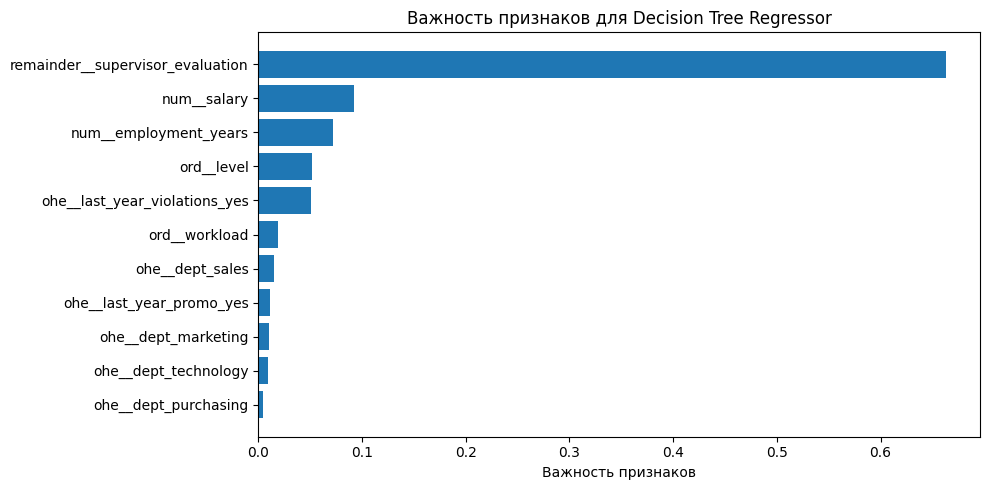

In [63]:
# 1. Извлекаем важности признаков
feature_importances = best_model.named_steps['models'].feature_importances_

# 2. Получаем названия признаков после предобработки
preprocessor = best_model.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# 3. Создаем DataFrame
df_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# 4. Сортируем по убыванию важности
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# 5. Построение графика
plt.figure(figsize=(10, 5))
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.xlabel('Важность признаков')
plt.title('Важность признаков для Decision Tree Regressor')
plt.gca().invert_yaxis()  # Чтобы самый важный признак был сверху
plt.tight_layout()
plt.show()

Наблюдаем, что с точки зрения модели в топ-три признака по важности для прогнозирования удовлетворенности сотрудника входят: оценка руководителя, зарплата и стаж работы.

Проанализируем дисперсии для обеих моделей: LinearRegression и DecisionTreeRegressor. Начнем с DecisionTreeRegressor.

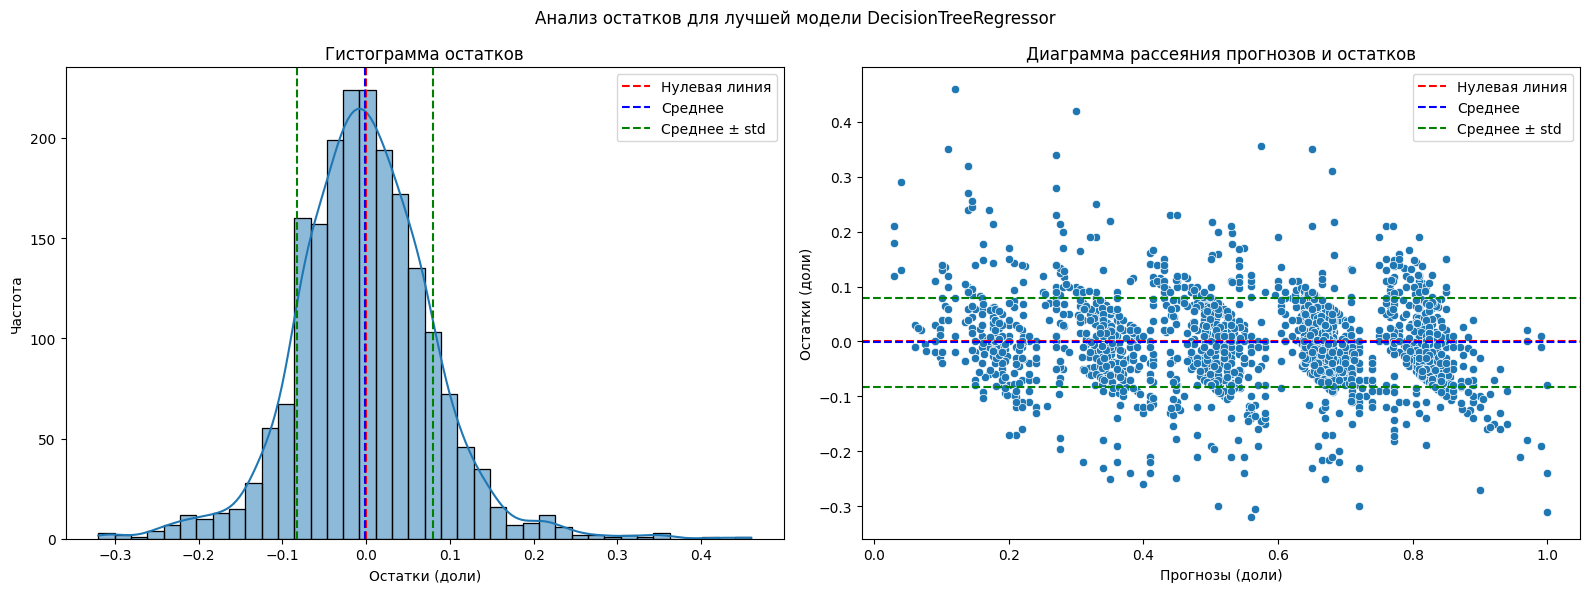

In [64]:
# воспользуемся собственной функцией analyze_residuals для анализа остатков лучшей модели DecisionTreeRegressor
analyze_residuals(
    y_test,
    y_test_pred,
    units="доли",
    bins=40,
    figsize=(16, 6),
    title="Анализ остатков для лучшей модели DecisionTreeRegressor"
)

Центр нормального распределения остатков близок к 0. Что касается дисперсии остатков, то среднее значение остатков для определенной удовлетворенности сотрудников изменяется периодически с изменением ее значений от 0.1 до 0.9. При этом среднее значение остатков для определенной удовлетворенности не выходит за стандартное отклонение для всех остатков. Следовательно, модель DecisionTreeRegressor в целом хорошо замечает взаимосвязи между признаками и будет работать достаточно стабильно с незначительным отклонением от истинного значения удовлетворенности в одну или в другую сторону в зависимости от ее значения.

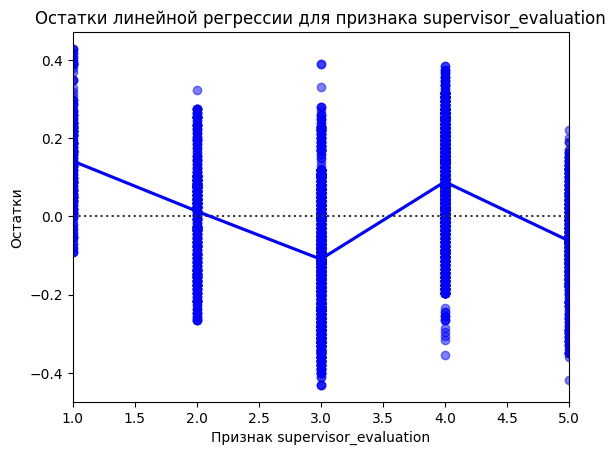

In [65]:
sns.residplot(
    x=train_jsrate_df['supervisor_evaluation'],          # Выбранный признак
    y=train_jsrate_df['job_satisfaction_rate'],          # Целевая переменная
    data=train_jsrate_df,
    lowess=True,    # Добавляет сглаженную кривую
    color='blue',
    scatter_kws={'alpha': 0.5}  # Прозрачность точек для лучшей визуализации
)
plt.title('Остатки линейной регрессии для признака supervisor_evaluation')
plt.xlabel('Признак supervisor_evaluation')
plt.ylabel('Остатки')
plt.show()

Переходим к LinearRegression. Для начала нужно извлечь лучшие гиперпараметры для этой модели, потом обучить модель с ними на тренировочной выборке и применить к тестовой. 

In [66]:
# Извлекаем лучшую LinearRegression
linear_results = []
for i in range(len(grid_search.cv_results_['params'])):
    # Проверка на тип модели
    if isinstance(grid_search.cv_results_['params'][i]['models'], LinearRegression):
        linear_results.append({
            'params': grid_search.cv_results_['params'][i],
            'mean_score': grid_search.cv_results_['mean_test_score'][i]
        })

# Сортируем по среднему значению метрики (по возрастанию модуля)
sorted_linear = sorted(linear_results, key=lambda x: abs(x['mean_score']))
best_linear = sorted_linear[0]

In [67]:
# Создаем пайплайн
linear_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

# Устанавливаем параметры
linear_pipe.set_params(**{
    'preprocessor__num': best_linear['params']['preprocessor__num'],
})

# Обучаем
linear_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['dept', 'last_year_p...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', 'passthrough',
                                                  ['employment_years',
                                                   'salary'])])),
                ('models', LinearRegression())])

In [68]:
# Предсказываем
y_pred = linear_pipe.predict(X_test)

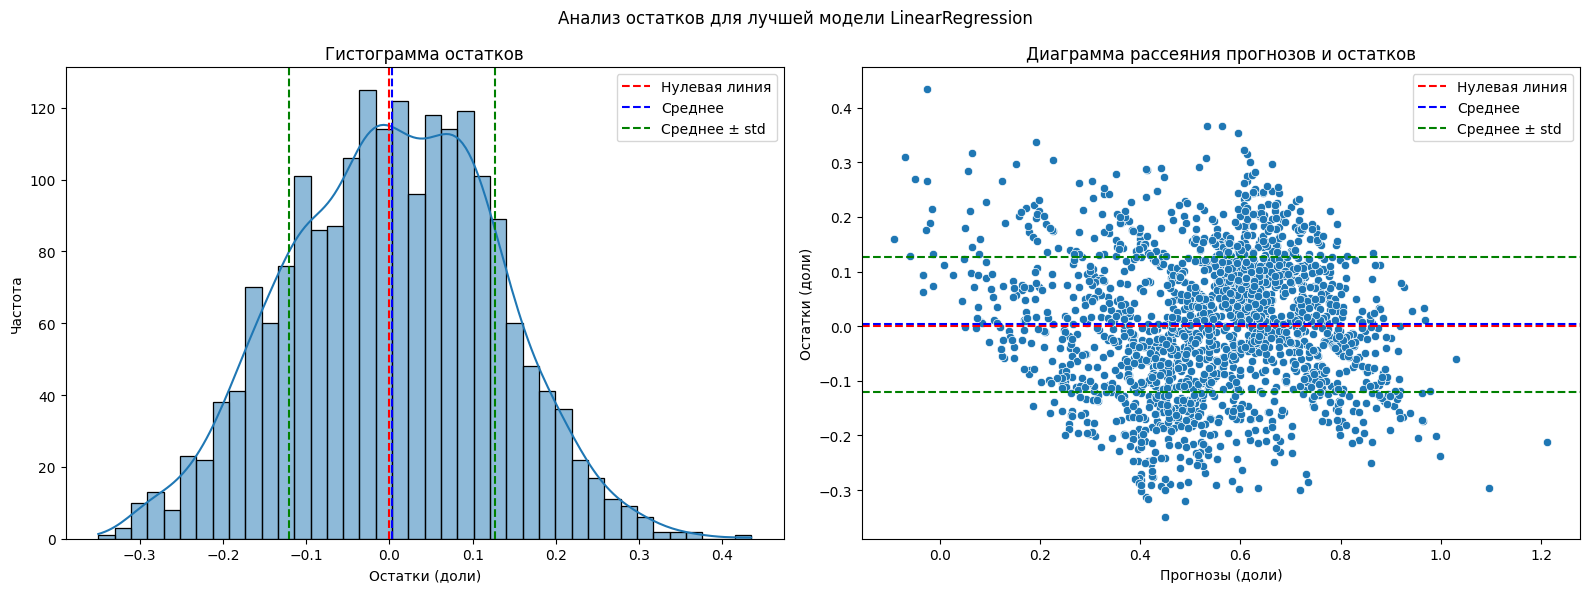

In [69]:
# воспользуемся собственной функцией analyze_residuals для анализа остатков лучшей модели LinearRegression
analyze_residuals(
    y_test,
    y_pred,
    units="доли",
    bins=40,
    figsize=(16, 6),
    title="Анализ остатков для лучшей модели LinearRegression"
)

Центр нормального распределения остатков также близок к 0. Что касается дисперсии остатков, то в данном случае мы наблюдаем его непостоянство. Дисперсия максимальна на промежутке значений удовлетворенности сотрудников от 0.3 до 0.7. При этом в данном промежутке значений удовлетворенности остатки в значительной своей массе расположены за стандартным отклонением для всех остатков. Следовательно, модель LinearRegression хуже замечает взаимосвязи между признаками, чем модель DecisionTreeRegressor, и будет работать нестабильно.

Проанализируем важность признаков в линейной регрессии.

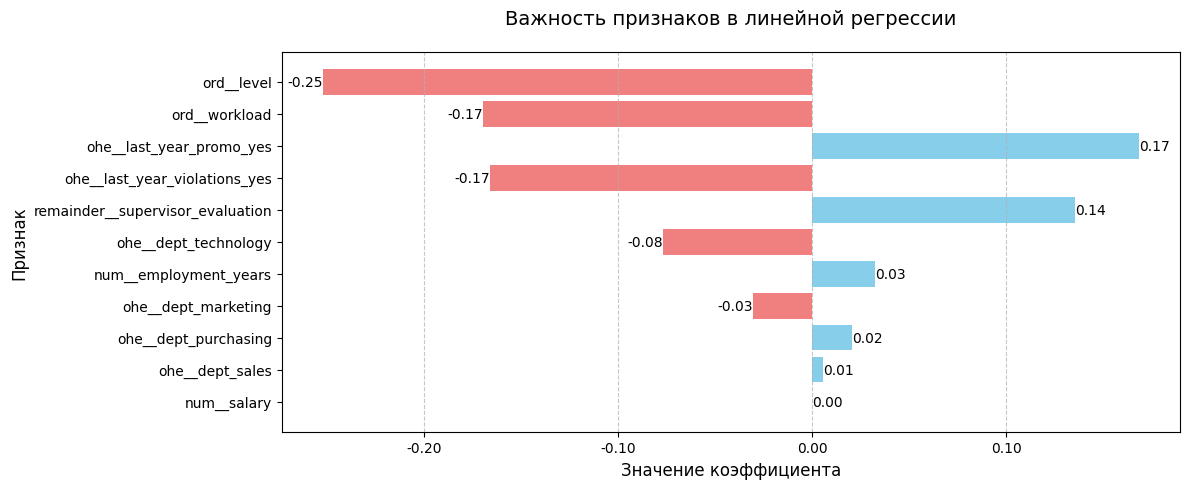

In [70]:
# 1. Получаем обученную модель
trained_model = linear_pipe.named_steps['models']

# 2. Извлекаем коэффициенты и названия признаков
coefficients = trained_model.coef_
preprocessor = linear_pipe.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# 3. Создаем DataFrame для удобства
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# 4. Сортируем по абсолютному значению коэффициентов
sorted_coefficients = coefficients_df.sort_values(
    by='Coefficient', 
    key=lambda x: abs(x), 
    ascending=True  # Сортировка по наименьшим значениям
).reset_index(drop=True)

# 5. Визуализация
plt.figure(figsize=(12, 5))  # Устанавливаем размер графика

# Создаем список цветов в зависимости от знака коэффициента
colors = []
for coeff in sorted_coefficients['Coefficient']:
    if coeff > 0:
        colors.append('skyblue')  # Положительные
    else:
        colors.append('lightcoral')  # Отрицательные

# Создаем горизонтальную столбчатую диаграмму
bars = plt.barh(
    y=sorted_coefficients['Feature'],  # Названия признаков на оси Y
    width=sorted_coefficients['Coefficient'],  # Значения коэффициентов
    color=colors  # Применяем цвета
)

# Добавляем подписи осей и заголовок
plt.xlabel('Значение коэффициента', fontsize=12)  
plt.ylabel('Признак', fontsize=12)  
plt.title('Важность признаков в линейной регрессии', fontsize=14, pad=20)  

# Добавляем сетку
plt.grid(axis='x', linestyle='--', alpha=0.7)  

# Форматирование оси X
plt.gca().xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'{x:.2f}')  
)

# Добавляем значения коэффициентов над столбцами
for bar in bars:
    width = bar.get_width()  
    plt.text(  
        x=width + 0.00 * np.sign(width),  
        y=bar.get_y() + bar.get_height()/2,  
        s=f'{width:.2f}',  
        va='center',  
        ha='center' if width == 0 else 'left' if width > 0 else 'right'  
    )

# Улучшение читаемости
plt.xticks(rotation=0)  
plt.tight_layout()  
plt.show()

Коэффициенты линейной регрессии сильно разнятся, что для предсказательной способности линейной модели может послужить отрицательным фактором. Такие разные значения коэффициентов, вероятно, обусловлены наличием корреляции между некоторыми входными признаками, например, `workload`-`salary`, `level`-`salary`, `level`-`employment_years`, `level`-`workload`. Причем для `salary`-`employment_years` просматривается некоторая степень линейности. Поэтому данная линейная модель будет работать нестабильно. 

## Выводы по моделированию

Результаты лучшей модели DecisionTreeRegressor(max_depth=14, max_features=8) полностью согласуются с выводами, сделанными при исследовательском и корреляционном анализах, что подтверждает корректность модели.

В топ-три признака по влиянию на удовлетворенность сотрудника входят: оценка руководителя, зарплата и стаж работы.

При кросс-валидации исследовались две модели машинного обучения: LinearRegression и DecisionTreeRegressor. Причины, по которой модель DecisionTreeRegressor справилась с нашей задачей лучше, следующие:

-  нелинейные зависимости

Нелинейные зависимости наблюдались при корреляционном анализе на матрице рассеяния для следующих пар признаков: `job_satisfaction_rate`-`employment_years` или `job_satisfaction_rate`-`salary`.

-  взаимодействие между признаками

Взаимодействие между признаками, то есть влияние одного признака на целевой в зависимости от второго, проявляется для следующих пар: `workload`-`supervisor_evaluation`, `level`-`dept` — что обнаружено при исследовательском анализе при исследование категориальных признаков.

-  автоматический отбор признаков

Дерево решений автоматически выбирает наиболее информативные признаки для разбиений. Незначимые или шумовые признаки редко используются в верхних узлах дерева, что улучшает обобщающую способность. В нашем случае для LinearRegression не применялась регуляризация, что могло ухудшить точность модели.
  
-  дисперсия остатков

При анализе остатков лучших моделей LinearRegression и DecisionTreeRegressor установлено, что на всем промежутке значений удовлетворенности сотрудников DecisionTreeRegressor демонстрирует меньшую дисперсию остатков, чем LinearRegression, а значит лучше замечает взаимосвязи между признаками и работает стабильнее. 

-  обработка пороговых значений и разрывов

Поскольку в данных есть пороговые значения, при которых влияние признака на целевую переменную резко меняется (например, класс уровня должности для зарплаты, которая сильно влияет на удовлетворенность сотрудника, оценка работы сотрудника руководителем для удовлетворенности сотрудника), то дерево может разбить данные на соответствующие регионы, что линейная модель не может сделать.

-  мультиколлинеарность

Поскольку при корреляционном анализе выявлена сильная корреляция между входными признаками `workload`-`salary`, `level`-`salary`, `level`-`employment_years`, `level`-`workload`, то линейная модель показала нестабильные коэфициенты регрессии, так как она не может однозначно определить вклад каждого признака. В свою очередь дерево решений не страдает от мультиколлинеарности, так как выбирает признаки для разбиений, и если два признака одинаково полезны, дерево использует любой из них без ухудшения качества.

# Вторая часть

## Загрузка данных

In [71]:
# считываем данные из csv-файлов в датафреймы и сохраняем в переменные
try:
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
    train_quit = pd.read_csv('/datasets/train_quit.csv')
except:
    test_target_quit = pd.read_csv('test_target_quit.csv')
    train_quit = pd.read_csv('train_quit.csv')

In [72]:
# сделаем копии датафреймов
test_target_quit_df = test_target_quit.copy()
train_quit_df = train_quit.copy()

In [73]:
# просматриваем по три последних строки в данных 

# создаем словарь: ключ — название датафрейма, значение — сам датафрейм
dataframes = {
    'test_target_quit_df' : test_target_quit_df,
    'train_quit_df' : train_quit_df,
}

# выводим по три последних строки в каждом датафрейме
for name, df in dataframes.items():
    print(f'\033[1mДатафрейм {name}\033[0m')
    display(df.tail(3))
    print('')

Датафрейм test_target_quit_df


id quit
1997  746018   no
1998  247658   no
1999  460332  yes


Датафрейм train_quit_df


id        dept   level workload  employment_years last_year_promo  \
3997  536432  purchasing  junior      low                 2              no   
3998  692133  purchasing  middle   medium                 2              no   
3999  853842       sales  junior   medium                 2              no   

     last_year_violations  supervisor_evaluation  salary quit  
3997                  yes                      4   12000  yes  
3998                   no                      4   33600   no  
3999                   no                      3   27600  yes

**Промежуточный вывод**

Все данные из описания присутствуют, загрузка прошла успешно. Данные готовы к предобработке.

## Предобработка данных

In [74]:
# выведем общую информацию о датафреймах
# воспользуемся items() и словарем dataframes для обращения к каждому датафрейму в цикле
for name, df in dataframes.items():
    print(f'\033[1mОбщая информация для {name}:\033[0m')
    df.info()
    print('')

Общая информация для test_target_quit_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB

Общая информация для train_quit_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8 

Явные пропуски отсутствуют. Тип данных везде соответствует описанию.

Теперь проанализируем дубликаты во всех датафреймах. Для начала узнаем количество явных дубликатов.

In [75]:
# выведем количество дубликатов в каждом датафрейме
# воспользуемся items() и словарем dataframes для обращения к каждому датафрейму в цикле
for name, df in dataframes.items():
    print(f'\033[1mКоличество явных дубликатов в {name}: {df.duplicated().sum()}\033[0m')

Количество явных дубликатов в test_target_quit_df: 0
Количество явных дубликатов в train_quit_df: 0


Явные дубликаты отсутствуют. Теперь проверим наличие неявных дубликатов и пропусков. Для этого выведем уникальные значения всех категориальных признаков.

In [76]:
# выведем уникальные значения для каждого категориального признака каждого DataFrame
for name, df in dataframes.items():
    print(f'\033[1mУникальные значения для признаков {name}:\033[0m')
    for column in df.select_dtypes(include='object').columns:
        unique_values = df[column].unique()
        print(f'  \033[1m{column}:\033[0m {unique_values}')
    print('')

Уникальные значения для признаков test_target_quit_df:
  quit: ['yes' 'no']

Уникальные значения для признаков train_quit_df:
  dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
  level: ['middle' 'junior' 'sinior']
  workload: ['high' 'medium' 'low']
  last_year_promo: ['no' 'yes']
  last_year_violations: ['no' 'yes']
  quit: ['no' 'yes']



Орфографическая ошибка: `sinior` → `senior`. Устраним ее.

In [77]:
# Исправление опечатки "sinior" на "senior" в столбце level
train_quit_df['level'] = (
    train_quit_df['level']
    .replace('sinior', 'senior')
)

In [78]:
# проверям результат устранения особенностей
for name, df in dataframes.items():
    print(f'\033[1mУникальные значения для признаков {name}:\033[0m')
    for column in df.select_dtypes(include='object').columns:
        unique_values = df[column].unique()
        print(f'  \033[1m{column}:\033[0m {unique_values}')
    print('')

Уникальные значения для признаков test_target_quit_df:
  quit: ['yes' 'no']

Уникальные значения для признаков train_quit_df:
  dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
  level: ['middle' 'junior' 'senior']
  workload: ['high' 'medium' 'low']
  last_year_promo: ['no' 'yes']
  last_year_violations: ['no' 'yes']
  quit: ['no' 'yes']



Ошибка исправлена.

In [79]:
# выведем количество дубликатов в каждом датафрейме
# воспользуемся items() и словарем dataframes для обращения к каждому датафрейму в цикле
for name, df in dataframes.items():
    print(f'\033[1mКоличество явных дубликатов в {name}: {df.duplicated().sum()}\033[0m')

Количество явных дубликатов в test_target_quit_df: 0
Количество явных дубликатов в train_quit_df: 0


Явные дубликаты не появились. 

Теперь в качестве индекса установим столбец `id` и отсортируем датафреймы по возрастанию индекса.

In [80]:
# проведем через цикл все датасеты:
# установим столбец id за индексы
# отсортируем по возрастанию индекса
for df in dataframes.values():
    df.set_index('id', inplace=True)
    df.sort_index(inplace=True)

**Выводы по предобработке данных**

1. Пропуски отсутствуют.
2. Тип данных корректный во всех датафреймах.
3. Один из классов в категориальном признаке `level` имел опечатку, ошибка исправлена.
4. Дубликаты не обнаружены.

Датафреймы готовы для анализа.

## Исследовательский анализ

In [81]:
## просмотрим числовое описание данных train_quit_df

# создадим таблицу с числовым описанием данных
pivot_train_jsrate_df = train_quit_df.describe(include='all')

# добавим рассогласование медианного (medium) и среднего (mean) значений как ((mean-medium)/medium)*100%
# в данном случае берется абсолютная разница (mean-medium) без модуля, чтобы сразу было понятно mean больше или меньше medium
pivot_train_jsrate_df.loc['mismatch%'] = ((pivot_train_jsrate_df.loc['mean']-pivot_train_jsrate_df.loc['50%'])/pivot_train_jsrate_df.loc['50%'])*100
# добавим соотношение стандартного отклонения к медианному значению в процентах,
# чтобы оценить разброс и сравнить его для всех количественных признаков, так как они отличаются по масштабу
pivot_train_jsrate_df.loc['rel_std%'] = pivot_train_jsrate_df.loc['std']/pivot_train_jsrate_df.loc['mean']*100
# добавим долю наиболее популярного класса в категориальных признаках в процентах,
# чтобы оценить дисбаланс целевого класса
pivot_train_jsrate_df.loc['cat_top_ratio%'] = pivot_train_jsrate_df.loc['freq']/pivot_train_jsrate_df.loc['count']*100

# преобразуем в HTML
styled_table = pivot_train_jsrate_df.round(2).T.to_html()

print('\033[1mЧисловое описание данных train_quit_df\033[0m')
HTML(styled_table)

Числовое описание данных train_quit_df


Наблюдаем схожее числовое описание с данными в первой части. Поэтому детальный анализ повторять не будем. Составим портрет «уволившегося сотрудника». 

### Количественные входные признаки в зависимости от категориального целевого признака quit

Добавим столбец `job_satisfaction_rate`, предсказав значения с помощью лучшей модели, подготовленной в первой задачи. 

In [82]:
# Предсказываем значения job_satisfaction_rate
train_quit_df['job_satisfaction_rate'] = best_model.predict(train_quit_df.drop('quit', axis=1))

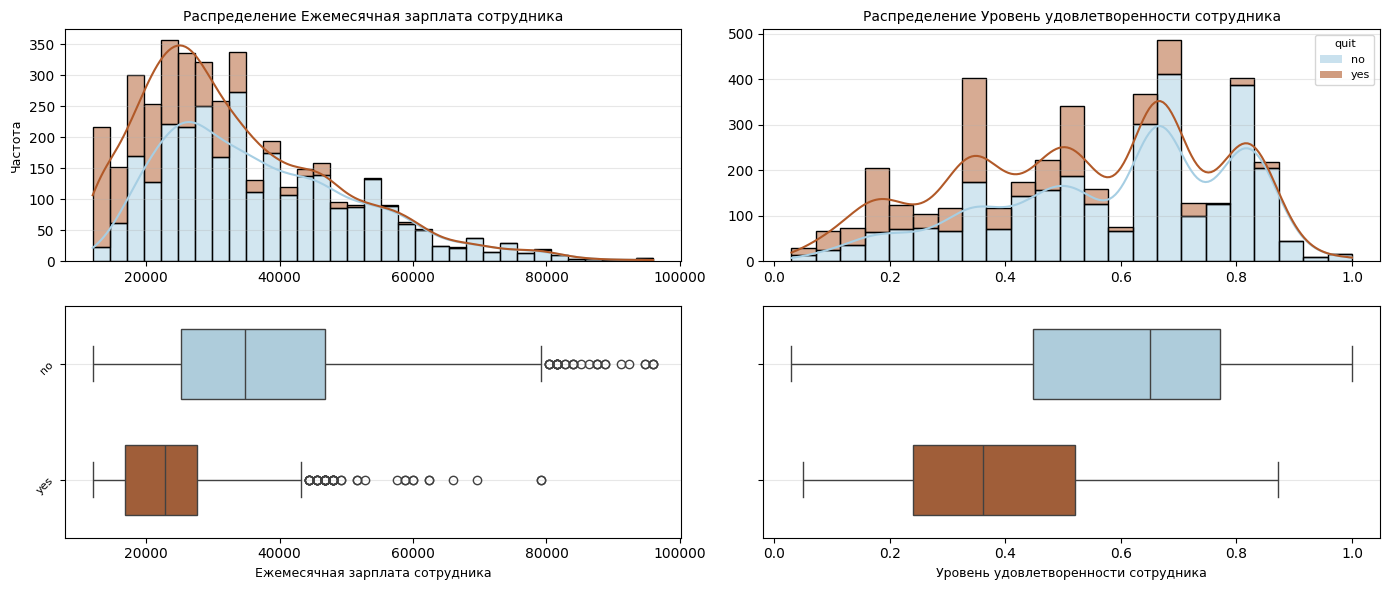

In [83]:
# Применение функции plot_distribution_with_boxplot к количественным непрерывным признакам
features = [
    ('salary', 'Ежемесячная зарплата сотрудника'),
    ('job_satisfaction_rate', 'Уровень удовлетворенности сотрудника')
]

plot_distribution_with_boxplot(
    train_quit_df,
    features,
    'quit'
)

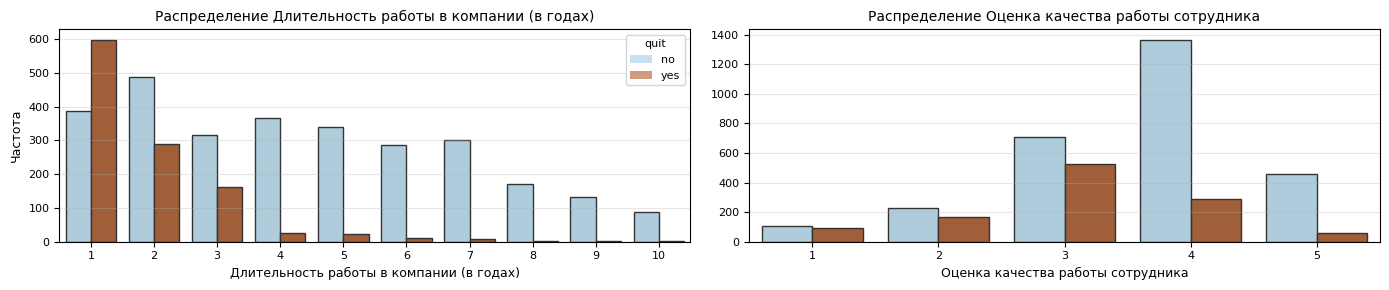

In [84]:
# Применение функции plot_distribution_with_countplot к количественным дискретным признакам
features = [
    ('employment_years', 'Длительность работы в компании (в годах)'),
    ('supervisor_evaluation', 'Оценка качества работы сотрудника')
]

plot_distribution_with_countplot(
    df=train_quit_df,
    features=features,
    target_col='quit'
)

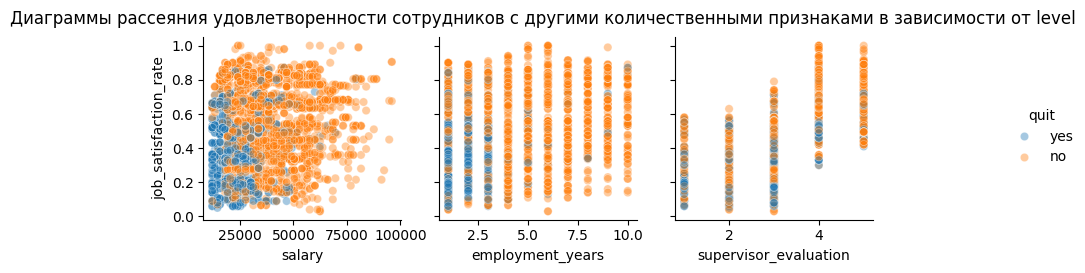

In [85]:
# используем PairGrid для визуализации диаграмм рассеяния
x_vars = ["salary", "employment_years", "supervisor_evaluation"]
y_vars = ["job_satisfaction_rate"]
g = sns.PairGrid(train_quit_df, hue="quit", x_vars=x_vars, y_vars=y_vars)
#g.map_diag(sns.histplot, color=".3")
g.map_offdiag(sns.scatterplot, alpha=0.4)
g.add_legend()
g.fig.suptitle('Диаграммы рассеяния удовлетворенности сотрудников с другими количественными признаками в зависимости от level', y=1.05)
plt.show()

На первый взгляд наблюдаются отличия во всех числовых признаках для сотрудников оставшихся и уволившихся. Проведем ряд t-тестов для определения статистически значимо ли различие между средними значениями того или иного признака для сотрудников оставшихся и уволившихся.

### Проверка гипотез

#### salary

Нулевая гипотеза (H0) — отсутствовали различия в ежемесячной зарплате между оставшимися и уволившимися сотрудниками.

Альтернативная гипотеза (H1) — оставшиеся сотрудники получали зарплату больше, чем уволившиеся.

In [86]:
t_test_group_comparison(train_quit_df, 'salary', alpha=0.05)

Среднее значение по столбцу 'salary' со стандартным отклонением:
    группа 'no' — 37702.23±15218.98,
    группа 'yes' — 23885.11±9351.6

p-value: 0.0000
Отвергаем нулевую гипотезу


Значение p-value стремится к 0, то есть оно меньше статистической значимости, что говорит о том, что разница в зарплате двух групп статистически значима.

**Вывод** — оставшиеся сотрудники получали зарплату больше, чем уволившиеся.

#### job_satisfaction_rate

Нулевая гипотеза (H0) — отсутствовали различия в удовлетворенности работой между оставшимися и уволившимися сотрудниками.

Альтернативная гипотеза (H1) — оставшиеся сотрудники были удовлетворены работой больше, чем уволившиеся.

In [87]:
t_test_group_comparison(train_quit_df, 'job_satisfaction_rate', alpha=0.05)

Среднее значение по столбцу 'job_satisfaction_rate' со стандартным отклонением:
    группа 'no' — 0.59±0.21,
    группа 'yes' — 0.4±0.19

p-value: 0.0000
Отвергаем нулевую гипотезу


Значение p-value стремится к 0, то есть оно меньше статистической значимости, что говорит о том, что разница в удовлетворенности работой двух групп статистически значима.

**Вывод** — оставшиеся сотрудники удовлетворены работой больше, чем уволившиеся.

#### employment_years

Нулевая гипотеза (H0) — отсутствовали различия в стаже между оставшимися и уволившимися сотрудниками.

Альтернативная гипотеза (H1) — оставшиеся сотрудники имели стаж больше, чем уволившиеся.

In [88]:
t_test_group_comparison(train_quit_df, 'employment_years', alpha=0.05)

Среднее значение по столбцу 'employment_years' со стандартным отклонением:
    группа 'no' — 4.43±2.54,
    группа 'yes' — 1.84±1.27

p-value: 0.0000
Отвергаем нулевую гипотезу


Значение p-value стремится к 0, то есть оно меньше статистической значимости, что говорит о том, что разница в стаже двух групп статистически значима.

**Вывод** — оставшиеся сотрудники имели стаж работы больше, чем уволившиеся.

#### supervisor_evaluation

Нулевая гипотеза (H0) — отсутствовали различия в оценке, поставленной руководителем, между оставшимися и уволившимися сотрудниками.

Альтернативная гипотеза (H1) — оставшиеся сотрудники имели оценку, поставленную руководителем, больше, чем уволившиеся.

In [89]:
t_test_group_comparison(train_quit_df, 'supervisor_evaluation', alpha=0.05)

Среднее значение по столбцу 'supervisor_evaluation' со стандартным отклонением:
    группа 'no' — 3.64±0.97,
    группа 'yes' — 3.05±0.97

p-value: 0.0000
Отвергаем нулевую гипотезу


Значение p-value стремится к 0, то есть оно меньше статистической значимости, что говорит о том, что разница в оценке двух групп статистически значима.

**Вывод** — оставшиеся сотрудники имели оценку, поставленную руководителем, больше, чем уволившиеся.

### Распределение категориальных входных признаков по категориальному целевому признаку quit

In [90]:
# Применение созданной функции analyze_categorical_distributions к датафрейму
analyze_categorical_distributions(train_quit_df)

Распределение уволившихся по отделам практически однородно 0.25-0.30. При этом наиболее вероятно увольнение из отдела `technology`. Значительный отрыв уволившихся для уровня должности `junior` — 0.51 против 0.05. Интересным является тот факт, что доля уволившихся уменьшается с ростом нагрузки от `low` до `high` соответственно: 0.43, 0.23, 0.18. Значительный разрыв уволившихся для групп без повышения и с ним: 0.290 против 0.009. Нарушившие трудовой договор сотрудники увольняются с большей вероятностью: 0.42 против 0.26. 

### Портрет уволившегося сотрудника

После проведения исследовательского анализа портрет уволившегося сотрудника сформировался:
- зарплата 23885±9352 в среднем меньше, чем у оставшегося;
- удовлетворенность работой 0.40±0.19 в среднем меньше, чем у оставшегося;
- стаж работы 1.84±1.27 в среднем меньше, чем у оставшегося;
- оценка руководителся 3.05±0.97 в среднем меньше, чем у оставшегося;
- доля уволившихся сотрудников примерно одинакова для всех отделов и варьируется от 0.25 до 0.30;
- уровень должности junior;
- загруженность низкая;
- за последний год отсутствовало повышение и имелось нарушение трудового договора.

### Проверка гипотезы про удовлетворенность работой для тестовой выборки

Добавим к датафрейму test_features_df столбец с целевым признаком `quit`. После чего добавим столбец с предсказанными значениями `job_satisfaction_rate`.

In [91]:
# объединение по индексам датафреймов test_features_df и test_target_quit_df индексов первого
test_full = test_features_df.join(test_target_quit_df)

In [92]:
# создание столбца job_satisfaction_rate 
test_full['job_satisfaction_rate'] = y_test_pred

In [93]:
# проверим уникальность индексов
test_full.index.is_unique

True

Индексы уникальны. Можно переходить к проверке гипотезы.

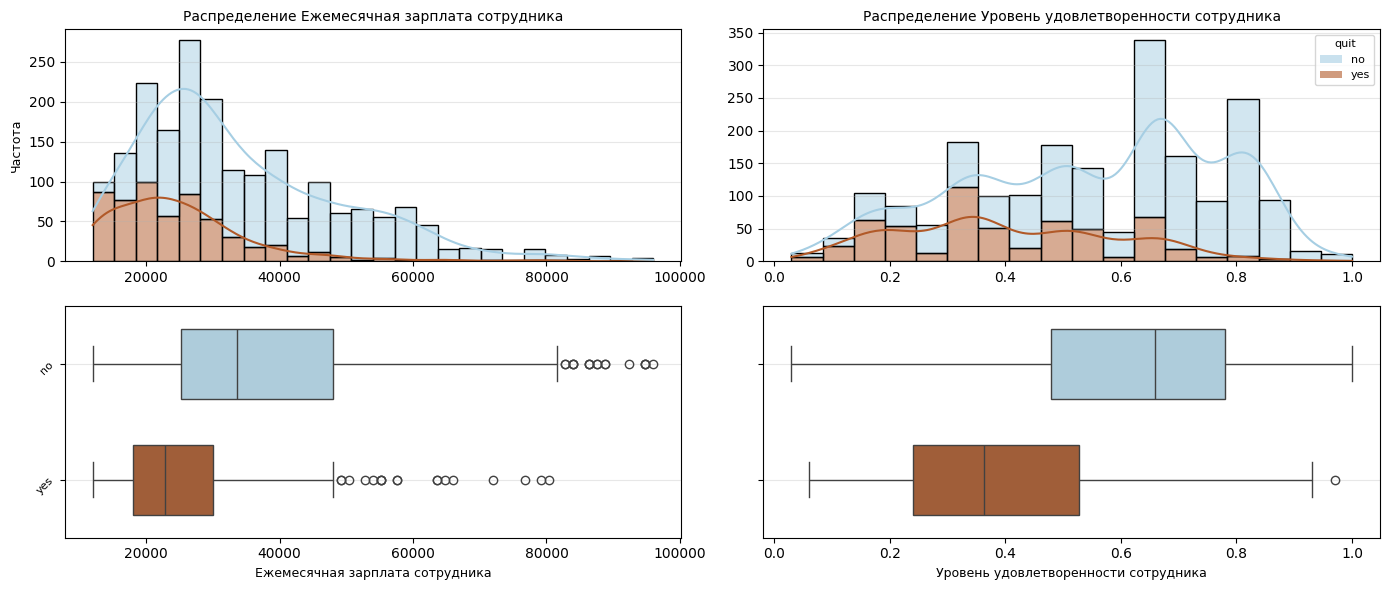

In [94]:
# Применение функции plot_distribution_with_boxplot к количественным непрерывным признакам
features = [
    ('salary', 'Ежемесячная зарплата сотрудника'),
    ('job_satisfaction_rate', 'Уровень удовлетворенности сотрудника')
]

plot_distribution_with_boxplot(
    test_full,
    features,
    'quit'
)

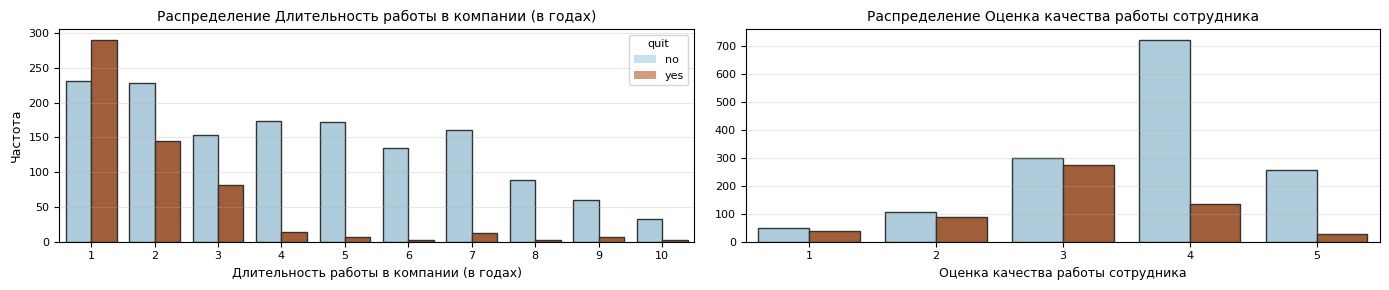

In [95]:
# Применение функции plot_distribution_with_countplot к количественным дискретным признакам
features = [
    ('employment_years', 'Длительность работы в компании (в годах)'),
    ('supervisor_evaluation', 'Оценка качества работы сотрудника')
]

plot_distribution_with_countplot(
    df=test_full,
    features=features,
    target_col='quit'
)

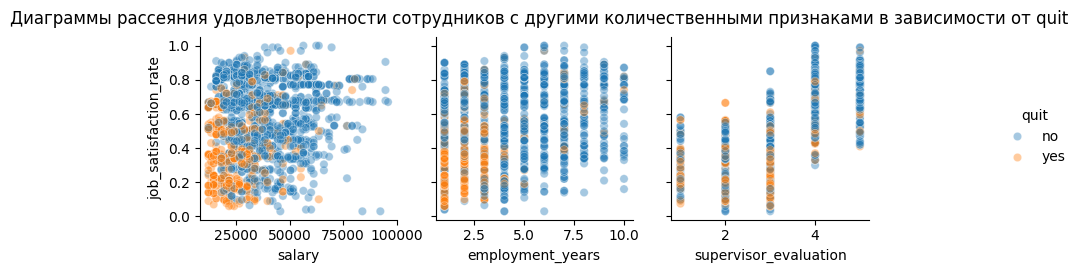

In [96]:
# используем PairGrid для визуализации диаграмм рассеяния
x_vars = ["salary", "employment_years", "supervisor_evaluation"]
y_vars = ["job_satisfaction_rate"]
g = sns.PairGrid(test_full, hue="quit", x_vars=x_vars, y_vars=y_vars)
#g.map_diag(sns.histplot, color=".3")
g.map_offdiag(sns.scatterplot, alpha=0.4)
g.add_legend()
g.fig.suptitle('Диаграммы рассеяния удовлетворенности сотрудников с другими количественными признаками в зависимости от quit', y=1.05)
plt.show()

На первый взгляд наблюдаются отличия во всех числовых признаках для сотрудников оставшихся и уволившихся. Проведем ряд t-тестов для определения статистически значимо ли различие между средними значениями того или иного признака для сотрудников оставшихся и уволившихся.

Нулевая гипотеза (H0) — отсутствовали различия в удовлетворенности работой между оставшимися и уволившимися сотрудниками.

Альтернативная гипотеза (H1) — оставшиеся сотрудники были удовлетворены работой больше, чем уволившиеся.

In [97]:
t_test_group_comparison(test_full, 'job_satisfaction_rate', alpha=0.05)

Среднее значение по столбцу 'job_satisfaction_rate' со стандартным отклонением:
    группа 'no' — 0.61±0.2,
    группа 'yes' — 0.4±0.19

p-value: 0.0000
Отвергаем нулевую гипотезу


Значение p-value стремится к 0, то есть оно меньше статистической значимости, что говорит о том, что разница в удовлетворенности работой двух групп статистически значима.

**Вывод** — оставшиеся сотрудники удовлетворены работой больше, чем уволившиеся.

### Проверка согласованности тренировочной и тестовой выборок

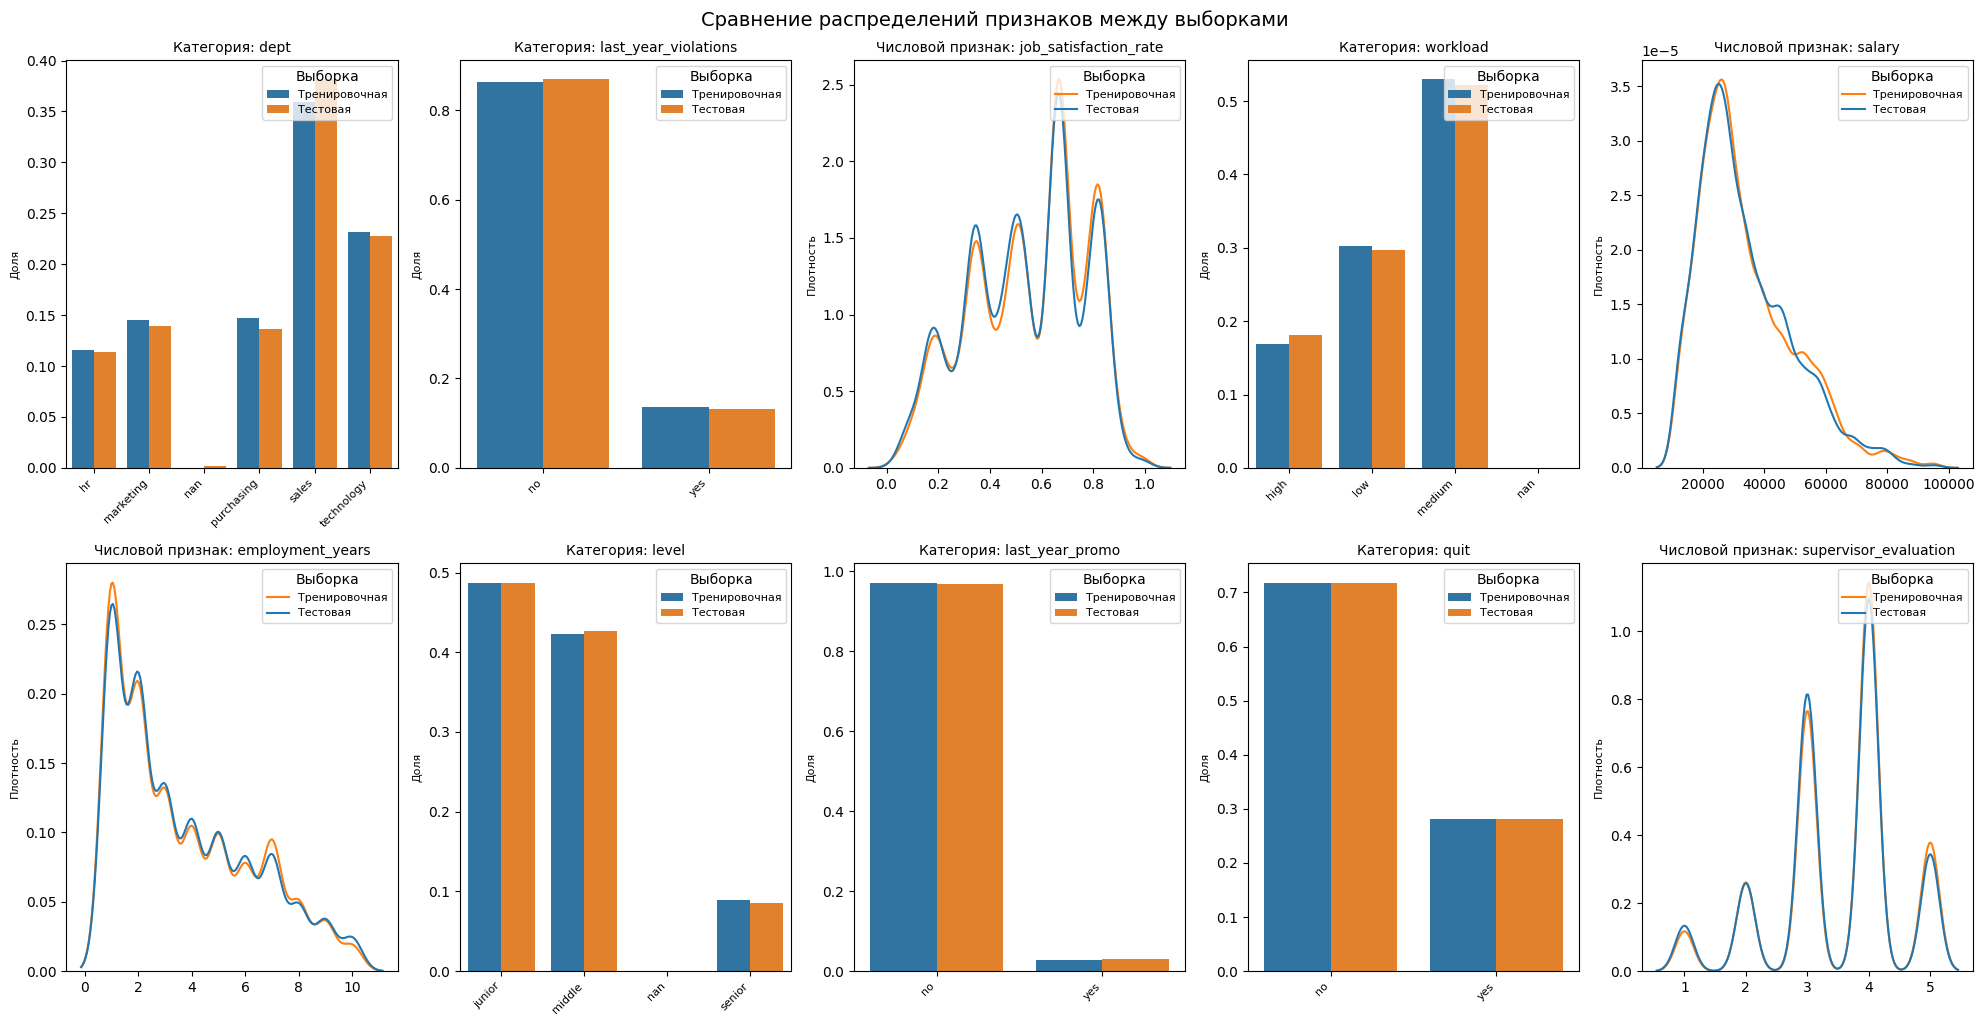

In [98]:
# применяем собственную функцию compare_distributions к датафреймам train_quit_df и test_full
compare_distributions(train_quit_df, test_full, n_cols=5)

Мы наблюдаем, что распределения для тренировочной и тестовой выборок достаточно хорошо согласуются друг с другом, что указывает на одинаковые закономерности в обоих выборках. Следовательно обученная на тренировочной выборке модель сможет продемоснтрировать высокую предсказательную способность и на тестовой выборке.

## Подготовка данных к моделированию quit

При исследовательском анализе обнаружен дисбаланс целевого признака `quit`: класса `no` 72%. Это достаточно большой перевес. Для некоторых моделей он может ослабить предсказательную способность, например, для LogisticRegression. Для решения проблемы дисбаланса классов для всех моделей будем использовать параметр `class_weight='balanced'`. Также в качестве метрики будем использовать `ROC-AUC`, так как она менее чувствительна к дисбалансу классов, чем другие метрики. Данная метрика также выбрана по следующим причинам:
- объективно сравнивает разные модели, так как она измеряет общую способность модели ранжировать примеры;
- независимость от порога классификации.

In [99]:
# делим данные на тренировачные и тестовые выборки
X_train = train_quit_df.drop(['quit'], axis=1)
y_train = train_quit_df['quit']
X_test = test_full.drop(['quit'], axis=1)
y_test = test_full['quit']

<a id='link2'></a>

In [100]:
# используем LabelEncoder для кодирования целевого признака
# инициализируем LabelEncoder 
le = LabelEncoder()
# обучаем LabelEncoder на тренировочной выборке
y_train = le.fit_transform(y_train)
# кодируем целевой признак тестовой выборки
y_test = le.transform(y_test)

In [101]:
# создаем списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'salary', 'job_satisfaction_rate']

In [102]:
# создаем пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_before_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
     ('simpleImputer_after_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
    )

# создаем пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns),
    ], 
    remainder='passthrough'
)

## Обучение моделей

### Общий пайплайн — оценка

In [103]:
# создаем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Проведем кросс-валидацию для установления лучшей модели и ее лучших гипперпараметров

In [104]:
# настроим сетку гиперпараметров
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(
            random_state=RANDOM_STATE,
            class_weight='balanced'
        )],
        'models__max_depth': range(3, 8, 2),
        'models__max_features': range(3, 8, 2),
        'preprocessor__num': ['passthrough']  
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', # алгоритм оптимизации
            penalty='l1', # тип регуляризации Lasso (обнуляет неважные коэффициенты)
            class_weight='balanced'
        )],
        'models__C': [0.1, 1, 10], # коэффициент регуляризации
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели SVC()
    {
        'models': [SVC(
            probability=True,
            class_weight='balanced'
        )],
        'models__kernel': ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

# создадим стратифицированный сплит
cv = StratifiedKFold(
    n_splits=2,
    shuffle=True,
    random_state=RANDOM_STATE
)

# настроим RandomizedSearchCV для поиска лучшей модели
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=cv,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=15
)

In [105]:
%%time
# Обучение и поиск лучших параметров
randomized_search.fit(X_train, y_train)

CPU times: total: 2.77 s
Wall time: 3.92 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_before_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False)),
                                                                                               (...
                                        {'models': [LogisticRegression(class_weight='balanced',
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': [0.1, 1, 10],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(class_weight='balanced',
                                                        probability=True)],
                                         'models__kernel': ['linear', 'rbf'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [106]:
# извлекаем pipline с лучшей моделью
best_model = randomized_search.best_estimator_
print('Лучшая модель и ее параметры:\n\n', best_model)

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                              

По результатам кросс-валидации лучшей моделью стала SVC с ядром rbf и со StandardScaler для количественных признаков.

Рассчитаем метрику ROC-AUC на лучшей модели на кросс-валидацинной выборке и на тестовой выборке

In [107]:
print ('Метрика ROC-AUC лучшей модели на кросс-валидацинной выборке:', randomized_search.best_score_)

# рассчитаем прогноз на тестовых данных
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC лучшей модели на кросс-валидацинной выборке: 0.9267897800233114
Метрика ROC-AUC на тестовой выборке: 0.9232050959126021


Получим метрики и гиперпараметры лучшей модели каждого типа

In [108]:
# Получаем результаты поиска
cv_results = randomized_search.cv_results_
best_params_dict = {}

# Список классов моделей, для которых нужно найти лучшие параметры
model_classes = [DecisionTreeClassifier, LogisticRegression, SVC]

for model_class in model_classes:
    # Фильтруем параметры, чтобы найти те, где используется model_class
    mask = []
    for params in cv_results['params']:
        if isinstance(params['models'], model_class):
            mask.append(True)
        else:
            mask.append(False)
    # Если нет комбинаций для этой модели, пропускаем
    if not any(mask):
        continue
    # Извлекаем scores и параметры для отфильтрованных комбинаций
    mean_scores = cv_results['mean_test_score'][mask]
    params_list = np.array(cv_results['params'])[mask]
    # Находим индекс максимального score
    best_idx = np.argmax(mean_scores)
    best_params = params_list[best_idx]
    best_score = mean_scores[best_idx]
    best_params_dict[model_class.__name__] = {
        "params": best_params,
        "score": best_score
    }

# Выводим лучшие параметры для каждой модели
print("Лучшие параметры:")
for model_name, data in best_params_dict.items():
    print(f"\n{model_name}:")
    print(f"  ROC-AUC: {data['score']:.4f}")
    print("  Параметры:")
    for key, value in data['params'].items():
        if key != 'models':
            print(f"    {key}: {value}")

Лучшие параметры:

DecisionTreeClassifier:
  ROC-AUC: 0.9206
  Параметры:
    preprocessor__num: passthrough
    models__max_features: 7
    models__max_depth: 5

LogisticRegression:
  ROC-AUC: 0.9176
  Параметры:
    preprocessor__num: passthrough
    models__C: 0.1

SVC:
  ROC-AUC: 0.9268
  Параметры:
    preprocessor__num: StandardScaler()
    models__kernel: rbf


Выясним какое количество вариантов каждой модели рассматривалось при кросс-валидации

In [109]:
# выводим количество комбинаций для каждой модели
counts = defaultdict(int)
for params in cv_results['params']:
    model_name = type(params['models']).__name__
    counts[model_name] += 1
print("Количество комбинаций:", dict(counts))

Количество комбинаций: {'DecisionTreeClassifier': 7, 'LogisticRegression': 6, 'SVC': 2}


Мы видим, что все модели удовлетворяют критериям успеха ROC-AUC > 0.91, правда на кросс-валидационной выборке, а не тестовой. Тем не менее значения метрики для лучших моделей каждого типа близки друг к другу. Следовательно, чтобы не усложнять решение задачи акцентируем внимание на линейной модели LogisticRegression и попробуем улучшить ее результат.

### LogisticRegression

In [110]:
# создаем итоговый пайплайн: подготовка данных и модель
pipe_final_lr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [111]:
# настроим сетку гиперпараметров
param_grid = [
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', # алгоритм оптимизации
            penalty='l1',  # Lasso (обнуляет коэффициенты)
            class_weight='balanced'
        )],
        'models__C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear',
            penalty='l2',  # Ridge (смягчает коэффициенты)
            class_weight='balanced'
        )],
        'models__C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            penalty='elasticnet',  # Комбинация L1 и L2
            solver='saga',        # Требуется для elasticnet
            l1_ratio=0.5,         # Смешивание L1 и L2 (0.5 — 50% L1, 50% L2)
            class_weight='balanced'
        )],
        'models__C': [0.01, 0.1, 1.0, 10.0],
        'models__l1_ratio': [0.2, 0.5, 0.8],  # Добавьте параметр l1_ratio
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

# создадим стратифицированный сплит
cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=RANDOM_STATE
)

# настроим GridSearchCV для кросс-валидации
grid_search_lr = GridSearchCV(
    pipe_final_lr, 
    param_grid, 
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    error_score='raise'  # Вызывает исключение при ошибках
)

In [112]:
%%time
# Обучение и поиск лучших параметров
grid_search_lr.fit(X_train, y_train)

CPU times: total: 1.22 s
Wall time: 5.13 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_before_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_ou...
                          'models__C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LogisticRegression(class_weight='balanced',
                                                        l1_ratio=0.5,
                                                        penalty='elasticnet',
                                                        random_state=42,
                                                        solver='saga')],
                          'models__C': [0.01, 0.1, 1.0, 10.0],
                          'models__l1_ratio': [0.2, 0.5, 0.8],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [113]:
# извлекаем pipline с лучшей моделью LogisticRegression
best_model_lr = grid_search_lr.best_estimator_
print('Лучшая модель LogisticRegression и ее параметры:\n\n', best_model_lr)

Лучшая модель LogisticRegression и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
           

Лучшие гиперпараметры для LogisticRegression:
- C=0.1,
- penalty='l1'.

Рассчитаем метрику ROC-AUC на лучшей модели LogisticRegression на кросс-валидацинной выборке и на тестовой выборке

In [114]:
print ('Метрика ROC-AUC лучшей модели LogisticRegression на кросс-валидацинной выборке:', grid_search_lr.best_score_)

# рассчитаем прогноз на тестовых данных
y_test_pred = best_model_lr.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC лучшей модели LogisticRegression на кросс-валидацинной выборке: 0.9185432644025343
Метрика ROC-AUC на тестовой выборке: 0.9024544884331971


Удовлетворить критерий ROC-AUC > 0.91 на тестовой выборке для LogisticRegression не удалось. В таком случае переходим к более сложным моделям. Ранее мы исследовали еще DecisionTreeClassifier и SVC. Разница между ними по метрике незначительна. Однако разница в интерпретируемости и сложности объяснения очень существенна. В этом плане DecisionTreeClassifier выигрывает. Попытаемся выполнить задачу с помощью DecisionTreeClassifier.

### DecisionTreeClassifier

In [115]:
# создаем итоговый пайплайн: подготовка данных и модель
pipe_final_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [116]:
# настроим сетку гиперпараметров
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(
            random_state=RANDOM_STATE,
            class_weight='balanced'
        )],
        'models__max_depth': range(9, 14, 2),  # управление сложностью модели и риском переобучения
        'models__max_features': [0.3, 0.5, 0.7, 'sqrt', 'log2'],  # снижает риск переобучения, повышает разнообразие
        'models__min_samples_leaf': range(14, 19, 2),  # делает дерево более устойчивым к шуму данных
        'preprocessor__num': ['passthrough']
    }
]

# создадим стратифицированный сплит
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

# настроим GridSearchCV для кросс-валидации
grid_search_tree = GridSearchCV(
    pipe_final_tree, 
    param_grid, 
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    error_score='raise'  # Вызывает исключение при ошибках
)

In [117]:
%%time
# Обучение и поиск лучших параметров
grid_search_tree.fit(X_train, y_train)

CPU times: total: 1.08 s
Wall time: 3.07 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_before_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_ou...
                                                                          'job_satisfaction_rate'])])),
                                       ('models',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeClassifier(class_weight='balanced',
                                                            random_state=42)],
                          'models__max_depth': range(9, 14, 2),
                          'models__max_features': [0.3, 0.5, 0.7, 'sqrt',
                                                   'log2'],
                          'models__min_samples_leaf': range(14, 19, 2),
                          'preprocessor__num': ['passthrough']}],
             scoring='roc_auc')

In [118]:
# извлекаем pipline с лучшей моделью DecisionTreeClassifier
best_model_tree = grid_search_tree.best_estimator_
print('Лучшая модель DecisionTreeClassifier и ее параметры:\n\n', best_model_tree)

Лучшая модель DecisionTreeClassifier и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
       

Лучшие гиперпараметры для DecisionTreeClassifier:
- max_depth=11,
- max_features=0.5,
- min_samples_leaf=18

Рассчитаем метрику ROC-AUC на лучшей модели DecisionTreeClassifier на кросс-валидацинной выборке и на тестовой выборке

In [119]:
print ('Метрика ROC-AUC лучшей модели DecisionTreeClassifier на кросс-валидацинной выборке:', grid_search_tree.best_score_)

# рассчитаем прогноз на тестовых данных
y_test_pred = best_model_tree.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC лучшей модели DecisionTreeClassifier на кросс-валидацинной выборке: 0.9311046241466647
Метрика ROC-AUC на тестовой выборке: 0.926972209051937


Критерий успеха ROC-AUC > 0.910 достигли, ROC-AUC на тестовой выборке: 0.927. Разница между ROC-AUC на кросс-валидационной выборке и на тестовой выборке минимальна, в 3 знаке после запятой. Следовательно модель DecisionTreeClassifier обучилась оптимально. Анализ результатов моделирования будем проводить на ней.

Однако в проекте нужно сделать выводы о том, какая модель справилась лучше и почему. Для этого проведем аналогичный подбор гиперпараметров для модели SVC.

### SVC

Ранее было установлено, что ядро `rbf` справляется с задаче лучше, чем ядро `linear`. Поэтому акцентируем внимание на ядре `rbf`.

In [120]:
# создаем итоговый пайплайн: подготовка данных и модель
pipe_final_svc = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC())
])

In [121]:
# настроим сетку гиперпараметров
param_grid = [
    # словарь для модели SVC()
    {
        'models': [SVC(
            probability=True,
            class_weight='balanced'
        )],
        'models__kernel': ['rbf'],
        'models__C': range(150, 400, 50),
        'models__gamma': ['scale', 0.001, 0.01, 0.1, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

# создадим стратифицированный сплит
cv = StratifiedKFold(
    n_splits=2,
    shuffle=True,
    random_state=RANDOM_STATE
)

# настроим RandomizedSearchCV для поиска лучшей модели
randomized_search_svc = RandomizedSearchCV(
    pipe_final_svc, 
    param_grid, 
    cv=cv,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=30
)

In [122]:
%%time
# Обучение и поиск лучших параметров
randomized_search_svc.fit(X_train, y_train)

CPU times: total: 3.34 s
Wall time: 24.7 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_before_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False)),
                                                                                               (...
                                                                                'salary',
                                                                                'job_satisfaction_rate'])])),
                                             ('models', SVC())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions=[{'models': [SVC(class_weight='balanced',
                                                        probability=True)],
                                         'models__C': range(150, 400, 50),
                                         'models__gamma': ['scale', 0.001, 0.01,
                                                           0.1, 1],
                                         'models__kernel': ['rbf'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [123]:
# извлекаем pipline с лучшей моделью SVC
best_model_svc = randomized_search_svc.best_estimator_
print('Лучшая модель SVC и ее параметры:\n\n', best_model_svc)

Лучшая модель SVC и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                          

Лучшие гиперпараметры для SVC с ядром rbf:
- С=200-300,
- gamma=0.01

Рассчитаем метрику ROC-AUC на лучшей модели SVC на кросс-валидацинной выборке и на тестовой выборке

In [124]:
print ('Метрика ROC-AUC лучшей модели SVC на кросс-валидацинной выборке:', randomized_search_svc.best_score_)

# рассчитаем прогноз на тестовых данных
y_test_pred = best_model_svc.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC лучшей модели SVC на кросс-валидацинной выборке: 0.9346104600051364
Метрика ROC-AUC на тестовой выборке: 0.9247077431399278


Критерий успеха ROC-AUC > 0.910 достигли, ROC-AUC на тестовой выборке: 0.925. Разница между ROC-AUC на кросс-валидационной выборке и на тестовой выборке минимальна, в 3 знаке после запятой. Однако при более детальном подборе гиперпараметров оказалось, что модель DecisionTreeClassifier демонстрирует лучшую метрику на тестовой выборке — 0.927. В результате выбор DecisionTreeClassifier для анализа результатов моделирования обусловолен не только простотой, но и более высокой предсказательной способностью.

## Анализ результатов моделирования DecisionTreeClassifier

Проанализируем важность признаков и сравним с выводами, сделанными на основе исследовательского анализа.

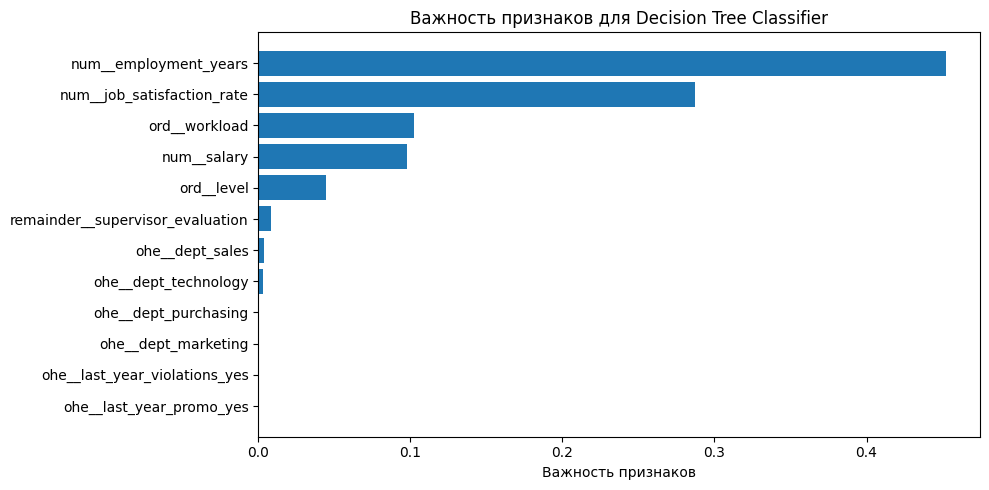

In [125]:
# 1. Извлекаем важности признаков
feature_importances = best_model_tree.named_steps['models'].feature_importances_

# 2. Получаем названия признаков после предобработки
preprocessor = best_model_tree.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# 3. Создаем DataFrame
df_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# 4. Сортируем по убыванию важности
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# 5. Построение графика
plt.figure(figsize=(10, 5))
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.xlabel('Важность признаков')
plt.title('Важность признаков для Decision Tree Classifier')
plt.gca().invert_yaxis()  # Чтобы самый важный признак был сверху
plt.tight_layout()
plt.show()

Наиболее сильное влияние на предсказательную способность модели оказывают следующие признаки:
- стаж работы
- удовлетворенность работой
- загруженность
- зарплата
- уровень должности

In [126]:
# Извлекаем только модель из пайплайна
tree_model = best_model_tree.named_steps['models']
print("Модель DecisionTreeClassifier извлечена.")

# Извлекаем только preprocessor из пайплайна
preprocessor = best_model_tree.named_steps['preprocessor']

# Применяем преобразования данных из пайплайна к X_train и X_test
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
print("Данные трансформированы.")

# Создаем объект explainer для SHAP
explainer = shap.TreeExplainer(tree_model)
print("Explainer создан.")

Модель DecisionTreeClassifier извлечена.
Данные трансформированы.
Explainer создан.


In [127]:
# Вычисляем SHAP-значения для тестовой выборки
shap_values = explainer.shap_values(X_test_transformed)  # Используем подвыборку
print("SHAP-значения вычислены.")

SHAP-значения вычислены.


In [128]:
# Смотрим порядок классов
print("Порядок классов в модели:", best_model_tree.classes_)

Порядок классов в модели: [0 1]


Размерность shap_values_trimmed: (2000, 12)
Размерность X_test_transformed: (2000, 12)


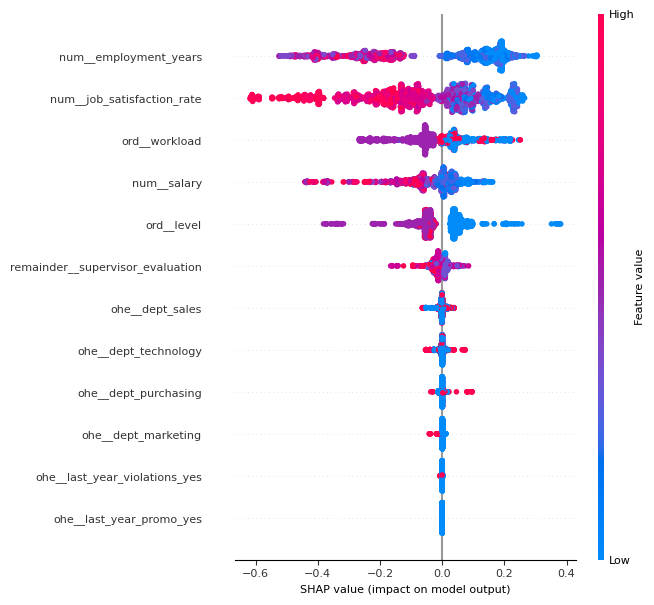

In [129]:
# Выбираем SHAP-значения для класса 1, так как столбцу с индексом 1 сответствует вероятность того,
# что сотрудник уволился
shap_values_positive_class = shap_values[:, :, 1]  

# Проверяем размерности
print("Размерность shap_values_trimmed:", shap_values_positive_class.shape)
print("Размерность X_test_transformed:", X_test_transformed.shape)

assert shap_values_positive_class.shape[1] == X_test_transformed.shape[1], "Количество признаков в shap_values_positive_class и X_test_transformed не совпадает"

# Получаем корректные имена признаков после преобразований
feature_names = test_full.drop(['quit'], axis=1).columns
transformed_feature_names = preprocessor.get_feature_names_out(input_features=feature_names)

# Построение графика важности признаков
shap.summary_plot(shap_values_positive_class, X_test_transformed, feature_names=transformed_feature_names, show=False)

# Настройка размера шрифта
for ax in plt.gcf().axes:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(8)  # Устанавливаем размер шрифта

# Показываем график
plt.show()

График представляет собой SHAP (SHapley Additive exPlanations) beeswarm plot, который показывает влияние различных признаков на предсказание модели. По оси X отображается значение SHAP, которое указывает на степень влияния каждого признака на выход модели. Положительные значения SHAP смещают предсказание в сторону увольнения сотрудника (положительная связь с таргетом), а отрицательные — отсутствия увольнения (отрицательная связь с таргетом).

*Положительная связь с таргетом:*
- низкие значения стажа работы
- низкое значение удовлетворенности
- низкая зарплата
- низкий уровень должности
- загруженность и оценка руководителя неоднозначно: как низкие, так и высокие значения (преимущественно низкие)

*Отрицательная связь с таргетом:* все тоже самое (как для положительной связи), только высокие значения

*Слабая или нейтральная связь:*
- повышение за последний год
- нарушение трудового договора за последний год

Что касается отдела, то чаще всего увольнения происходят в отделах purchasing, technology, sales.

Наблюдается досточно хорошее соответствие с результатами исследовательского анализа, что указывает на высокое качество модели.

## Выводы о лучшей модели

Установлено, что лучшая модель из исследуемых для решения нашей задачи — DecisionTreeClassifier. Предполагается несколько причин такого результата:
- DecisionTreeClassifier менее чувствителен к шумам, а так как есть признаки (`last_year_promo`, `last_year_violations`), которые слабо влияют на предсказательную способность согласно анализу результатов моделирования DecisionTreeClassifier, то на SVC данные шумы могли повлиять отрицательным образом.
- Много бинарных категориальных признаков, с которыми DecisionTreeClassifier справляется лучше, чем SVC с ядром rbf.
- SVC очень чувстивтелен к масштабированию, по сравнению с DecisionTreeClassifier, а так как категориальный признак оценки руководителя не масштабирован и принимает значение не от 0 до 1, а от 1 до 5, то это могло усложнить обучение для SVC.
- Малое количество данных для обучения, что критично для сложных ядер, таких как rbf.
- Наличие выбросов, к которым SVC уязвим, так как они могут влиять на выбор опорных векторов.
В целом многие из этих причин можно попытаться решить с целью улучшения метрики для модели SVC с ядром rbf, но в этом нет значительного смысла. Во-первых, модель DecisionTreeClassifier существенно быстрее, проще в интерпретации. Во-вторых, с помощью DecisionTreeClassifier задача проекта успешно решена. Следовательно DecisionTreeClassifier справилась лучше.

# Общий вывод

**Цель проекта** состояла в разработке моделей машинного обучения для прогнозирования уровня удовлетворенности сотрудников и их оттока, чтобы помочь компании «Работа с заботой» минимизировать риски, связанные с внезапными увольнениями, и снизить финансовые потери за счет оптимизации управления персоналом.

**Этапы работы:**

*1. Предобработка и анализ данных:*
- Очистка данных от пропусков, дубликатов и аномалий.
- Исследование распределения признаков и их взаимосвязи с целевыми переменными (уровень удовлетворенности и отток).
- Визуализация ключевых тенденций в данных (например, зависимость удовлетворенности от стажа, должности или зарплаты).
- Корреляционный анализ для выявления взаимосвязей между признаками.

*2. Построение модели прогнозирования удовлетворенности сотрудников:*
- Подготовка признаков для моделирования
- Выбор и обучение регрессионных моделей для предсказания уровня удовлетворенности (от 0 до 1).
- Оценка качества моделей с использованием метрик SMAPE.
- Выявление ключевых факторов, влияющих на удовлетворенность (через важность признаков в моделях).

*3. Построение модели прогнозирования оттока сотрудников:*
- Формирование датасета для классификации (целевой признак: уволился/не уволился).
- Обучение классификаторов.
- Оценка качества моделей с учетом бизнес-последствий (метрики: AUC-ROC).
- Выявление ключевых факторов, влияющих на увольнение.

*4. Исследование взаимосвязи удовлетворенности и оттока:*
- Анализ корреляции между уровнем удовлетворенности и вероятностью оттока.
- Построение визуализаций для демонстрации связи между этими переменными.

*5. Рекомендации для бизнеса:*
- Разработка стратегий удержания сотрудников на основе ключевых факторов, выявленных моделями.
- Предоставление интерпретируемых результатов (например, топ-5 факторов риска оттока).
- Составление портрета "уволившегося сотрудника".

---
**Удовлетворенность сотрудника**

В топ-три признака по влиянию на удовлетворенность сотрудника входят: оценка руководителя, зарплата и стаж работы.

1. **Оценка руководителя**: Чем выше оценка, тем выше удовлетворенность.
2. **Повышение за год**: Повышение увеличивает удовлетворенность.
3. **Оценка руководителя**: **Прямая зависимость** с удовлетворенностью (высокие оценки → высокая удовлетворенность).  
4. **Зарплата и стаж**: Чем выше, тем выше удовлетворенность.
5. **Загруженность**: Высокая загрузка без высокой оценки → стресс, низкая удовлетворенность.  
6. **Уровень должности и отдел**: Критически важны (например, «sales senior» с низкой удовлетворенностью).
---

**Увольнение сотрудников**

*Портрет уволившегося сотрудника*
- зарплата 23885±9352 в среднем меньше, чем у оставшегося;
- удовлетворенность работой 0.40±0.19 в среднем меньше, чем у оставшегося;
- стаж работы 1.84±1.27 в среднем меньше, чем у оставшегося;
- оценка руководителся 3.05±0.97 в среднем меньше, чем у оставшегося;
- доля уволившихся сотрудников примерно одинакова для всех отделов и варьируется от 0.25 до 0.30;
- уровень должности junior;
- загруженность низкая;
- за последний год отсутствовало повышение и имелось нарушение трудового договора.

*Сильные связи с увольнением*
- низкие значения стажа работы
- низкое значение удовлетворенности
- низкая зарплата
- низкий уровень должности
- загруженность и оценка руководителя неоднозначно: как низкие, так и высокие значения (преимущественно низкие)

*Слабая или нейтральная связь*
- повышение за последний год
- нарушение трудового договора за последний год

Что касается отдела, то чаще всего увольнения происходят в отделах purchasing, technology, sales.

---

**Стратегия удержания сотрудников:**  

1. **Улучшение качества руководства**  
   - Обучить менеджеров работе с командой (коммуникация, обратная связь).  
   - Проводить ежегодные анонимные опросы оценки руководителей и оперативно решать проблемы.  

2. **Конкурентоспособная зарплата**  
   - Аудит зарплат, особенно для junior-позиций (например, в sales, purchasing, technology).  
   - Убедиться, что зарплаты соответствуют рынку, особенно у сотрудников с низкими стажем и должностью.  

3. **Поддержка новых сотрудников**  
   - Ввести программы наставничества и карьерного роста для сотрудников с низким стажем.  
   - Регулярные встречи для фидбэка и постановки целей.  

4. **Акцент на проблемные отделы**  
   - Анализ отделов с высокой текучкой (sales, purchasing, technology):  
     - Проверить уровень зарплат, нагрузку, отношения в команде.  
     - Устранять причины недовольства (например, нехватка задач или плохая коммуникация).  

5. **Баланс загруженности и мотивации**  
   - Избегать «недозагрузки»: распределять задачи, вовлекать в проекты даже молодых сотрудников.  
   - Для тех, кто работает в «спокойный период», предлагать обучение или кросс-департаментные задачи.  

6. **Регулярные повышения и рост**  
   - Увеличить частоту оценок и повышений (даже небольших), чтобы сотрудники видели перспективы.  
   - Для junior-уровня ввести «ступенчатые» цели с наградами (например, после 1 года работы).  

7. **Мониторинг удовлетворенности**  
   - Квартальные анонимные опросы по ключевым факторам (зарплата, руководитель, нагрузка).  
   - Реагировать на «красные флаги» (например, резкое падение удовлетворенности в отделе).  

**Итог:** Фокус на руководителях, зарплате, развитии молодых сотрудников и проблемных отделах. Это снизит увольнения и повысит лояльность.

# Анализ confusion matrix с точки зрения бизнес-постановки задачи

Цель — минимизировать убытки и максимизировать прибыль за счет правильного распределения ресурсов. Задача — прогнозирование увольнения сотрудников.  Рассмотрим каждую ячейку матрицы:

---

**1. TP (True Positive) — Сотрудник уволился, и модель это предсказала**  
**Экономия и потенциальная прибыль:**  
- **Почему важно увеличивать TP:**  
  - Если модель правильно предсказывает увольнение, бизнес может **вовремя предпринять меры для удержания сотрудника** (например, повысить зарплату, улучшить условия, провести беседу).  
  - Это **экономия затрат** на поиск и обучение нового сотрудника.  
  - Также сохраняется **продуктивность** текущего сотрудника, что предотвращает потери прибыли от простоя.  
  - **Увеличение TP** повышает уверенность бизнеса в эффективности моделей и снижает риски.

---

**2. TN (True Negative) — Сотрудник остался, и модель это предсказала**  
**Экономия и потенциальная прибыль:**  
- **Почему важно увеличивать TN:**  
  - Модель не тратит ресурсы на удержание сотрудников, которые и так остаются. Это избегает **лишних расходов** (например, бонусы, дополнительные программы лояльности).  
  - Уменьшает **дополнительную нагрузку на HR-отдел**, который не будет заниматься ненужными действиями.  
  - **Увеличение TN** улучшает точность прогноза, что снижает вероятность ошибок в будущем.

---

**3. FP (False Positive) — Модель предсказала увольнение, но сотрудник остался**  
**Лишние расходы и упущенная прибыль:**  
- **Почему важно снижать FP:**  
  - Бизнес **тратит ресурсы** на удержание сотрудников, которые не планировали уходить (например, неоправданные бонусы, дополнительные выходные).  
  - Это **излишние расходы**, которые снижают прибыль.  
  - Возможны **негативные последствия** для морального климата: сотрудники могут воспринимать излишнее внимание как давление или несправедливость.  
  - **Снижение FP** улучшает репутацию модели в глазах бизнеса и уменьшает скепсис по отношению к прогнозам.

---

**4. FN (False Negative) — Модель предсказала, что сотрудник останется, но он уволился**  
**Лишние расходы и упущенная прибыль:**  
- **Почему важно снижать FN:**  
  - **Прямые убытки** от увольнения: затраты на поиск и обучение нового сотрудника, потеря знаний и опыта, снижение эффективности команды.  
  - **Упущенная прибыль** из-за простоя вакантной позиции или потери клиентов, связанных с уволившимся сотрудником.  
  - FN часто связаны со **скрытыми проблемами** в компании (например, конфликты, неудовлетворенность), которые могли быть решены, если бы модель их предсказала.  
  - **Снижение FN** улучшает репутацию модели и позволяет бизнесу оперативно реагировать на риски.

---

**Итоги для бизнеса**  
- **Цель №1:** **Увеличить TP и TN** (правильные прогнозы), чтобы:  
  - Снизить затраты на увольнение сотрудников.  
  - Экономить ресурсы, не тратя их на ненужные меры.  
  - Укрепить доверие к модели.  

- **Цель №2:** **Снизить FP и FN** (ошибки), чтобы:  
  - Избежать лишних расходов на FP.  
  - Предотвратить убытки от FN.  
  - Снизить риски, связанные с упущенной прибылью.  

---

Рассмотрим результат нашей модели

In [130]:
# рассчитаем прогноз на тестовых данных
y_pred = best_model_tree.predict(X_test)

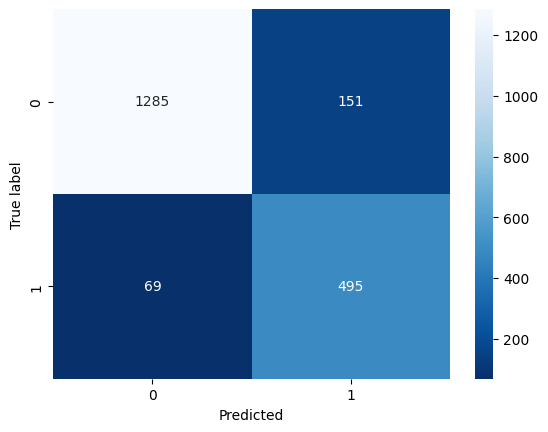

In [131]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

In [132]:
# Расчет метрик
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Вывод метрик
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-score: {f1:.4f}')

Accuracy: 0.8900
Recall: 0.8777
Precision: 0.7663
F1-score: 0.8182


**Характеристика confusion matrix с точки зрения бизнес-постановки задачи**

**Данные матрицы:**  
- **TN (True Negative):** 1285 (сотрудники, которые остались, и модель их правильно предсказала).  
- **FP (False Positive):** 151 (сотрудники, которые остались, но модель ошибочно предсказала их увольнение).  
- **FN (False Negative):** 69 (сотрудники, которые уволились, но модель их не определила).  
- **TP (True Positive):** 495 (сотрудники, которые уволились, и модель их правильно предсказала).  

---

**1. Общая оценка матрицы**  
- **Точность (Accuracy):**  
Высокая точность (89%), но она может быть обманчивой из-за несбалансированного класса (большинство сотрудников остаются).  

- **Полнота (Recall):**  
Модель хорошо определяет увольнения (88%), но есть небольшой процент FN (69).  

- **Precision (точность для класса 1):**  
Каждое предсказание увольнения верное лишь в 77% случаев.  

- **F1-мера:**  
Гармоническое среднее между Recall и Precision 82% — сбалансированная оценка, но есть пространство для улучшения.  

---

**2. Бизнес-интерпретация**

**Плюсы:**  
- **Высокая TN (1285):**  
  Модель редко ошибается с сотрудниками, которые остаются. Это экономит ресурсы компании (не тратятся на удержание тех, кто не уходит).  

- **Высокая TP (495):**  
  Модель успешно идентифицирует большинство увольнений (88% recall). Это позволяет бизнесу оперативно реагировать, предотвращая убытки.  

**Проблемы:**
- **Высокий FP (151 против 69 FN):**  
  Модель **переоценивает риск увольнения**. Это означает, что модель чаще ошибается, предсказывая увольнение там, где его нет (FP), чем пропускает увольнения (FN).  
    - **Бизнес-следствие:**  
      - Из-за FP компания тратит ресурсы (например, бонусы, переговоры) на сотрудников, которые не планировали уходить.  
      - Это **лишние расходы**, которые могут превысить потери от FN, если стоимость FP выше FN.  

- **FP/FN-баланс:**  
  Если **FP дороже FN**, то модель требует корректировки порога вероятности (например, повысить порог, чтобы снизить FP).  
  Если **FN дороже FP**, то стоит улучшать recall (например, через ансамблирование или понижения порога вероятности, чтобы снизить FN).  

---

**Итог:**  
Модель **эффективна в прогнозировании увольнений** (высокий recall), но **переоценивает риск** (FP > FN). Для бизнеса это означает:  
1. **Потенциальные излишние расходы** из-за FP.  
2. **Стоит оптимизировать порог вероятности** по ситуации в бизнесе:
- если FP дороже FN, приоритет — сокращение FP (увеличиваем порог);
- если FN критичнее (например, ключевые сотрудники), фокус — на снижение FN (уменьшаем порог).